In [ ]:
%pip install copent

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from copent import transent

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.gaussian_process import GaussianProcessRegressor

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.losses import MeanSquaredError, Huber
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError

import torch
from torch import nn, optim

from itertools import product
import pickle as pkl
from tqdm.notebook import tqdm

%matplotlib inline

In [ ]:
strategy = tf.distribute.MirroredStrategy()

## Import data and preprocessing

In [4]:
data = pd.read_csv('/kaggle/input/world-stock/stock.csv')
data.rename({'Unnamed: 0': 'Date'}, axis=1, inplace=True)
data.head()

Date  Price_AAPL  Price_AMZN   Price_BA  Price_DIS  Price_GOOGL  \
0  2004-08-19    2.193571   38.630001  50.250000  22.097601    50.220219   
1  2004-08-20    2.200000   39.509998  50.459999  22.137060    54.209209   
2  2004-08-21    2.200000   39.509998  50.459999  22.137060    54.209209   
3  2004-08-22    2.200000   39.509998  50.459999  22.137060    54.209209   
4  2004-08-23    2.220000   39.450001  50.650002  21.870705    54.754753   

   Price_INTC  Price_MSFT  Price_NKE  Price_NVDA  Price_SBUX  
0   22.010000   27.120001    9.20625    3.886667     11.1625  
1   21.620001   27.200001    9.28250    4.116667     11.2600  
2   21.620001   27.200001    9.28250    4.116667     11.2600  
3   21.620001   27.200001    9.28250    4.116667     11.2600  
4   21.889999   27.240000    9.24250    4.206666     11.2475

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5705 entries, 0 to 5704
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         5705 non-null   object 
 1   Price_AAPL   5705 non-null   float64
 2   Price_AMZN   5705 non-null   float64
 3   Price_BA     5705 non-null   float64
 4   Price_DIS    5705 non-null   float64
 5   Price_GOOGL  5705 non-null   float64
 6   Price_INTC   5705 non-null   float64
 7   Price_MSFT   5705 non-null   float64
 8   Price_NKE    5705 non-null   float64
 9   Price_NVDA   5705 non-null   float64
 10  Price_SBUX   5705 non-null   float64
dtypes: float64(10), object(1)
memory usage: 490.4+ KB


In [6]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.head()

Date  Price_AAPL  Price_AMZN   Price_BA  Price_DIS  Price_GOOGL  \
0 2004-08-19    2.193571   38.630001  50.250000  22.097601    50.220219   
1 2004-08-20    2.200000   39.509998  50.459999  22.137060    54.209209   
2 2004-08-21    2.200000   39.509998  50.459999  22.137060    54.209209   
3 2004-08-22    2.200000   39.509998  50.459999  22.137060    54.209209   
4 2004-08-23    2.220000   39.450001  50.650002  21.870705    54.754753   

   Price_INTC  Price_MSFT  Price_NKE  Price_NVDA  Price_SBUX  
0   22.010000   27.120001    9.20625    3.886667     11.1625  
1   21.620001   27.200001    9.28250    4.116667     11.2600  
2   21.620001   27.200001    9.28250    4.116667     11.2600  
3   21.620001   27.200001    9.28250    4.116667     11.2600  
4   21.889999   27.240000    9.24250    4.206666     11.2475

In [7]:
data.describe()

Date   Price_AAPL   Price_AMZN     Price_BA  \
count                 5705  5705.000000  5705.000000  5705.000000   
mean   2012-06-10 00:00:00    80.268048   483.661252   133.029341   
min    2004-08-19 00:00:00     2.193571    26.070000    29.360001   
25%    2008-07-15 00:00:00    19.624287    77.099998    68.849998   
50%    2012-06-10 00:00:00    64.121429   225.229996    89.529999   
75%    2016-05-06 00:00:00   116.949997   679.750000   144.440002   
max    2020-04-01 00:00:00   327.200012  2170.219971   440.619995   
std                    NaN    69.658238   578.706657    98.829057   

         Price_DIS  Price_GOOGL   Price_INTC   Price_MSFT    Price_NKE  \
count  5705.000000  5705.000000  5705.000000  5705.000000  5705.000000   
mean     64.084173   509.208047    29.010631    47.812812    35.616663   
min      15.590000    50.055054    12.080000    15.150000     9.206250   
25%      31.459484   238.433426    21.170000    26.870001    14.285000   
50%      46.240002   328.828827    24.820000    30.610001    24.497499   
75%     100.970001   758.479980    34.669998    54.189999    54.939999   
max     151.639999  1524.869995    68.470001   188.699997   104.580002   
std      37.489668   357.247775    11.062003    34.099912    24.986873   

        Price_NVDA   Price_SBUX  
count  5705.000000  5705.000000  
mean     54.938924    33.344510  
min       3.886667     3.585000  
25%      13.150000    13.485000  
50%      18.780001    25.264999  
75%      37.770000    55.119999  
max     314.700012    99.110001  
std      74.086555    23.190949

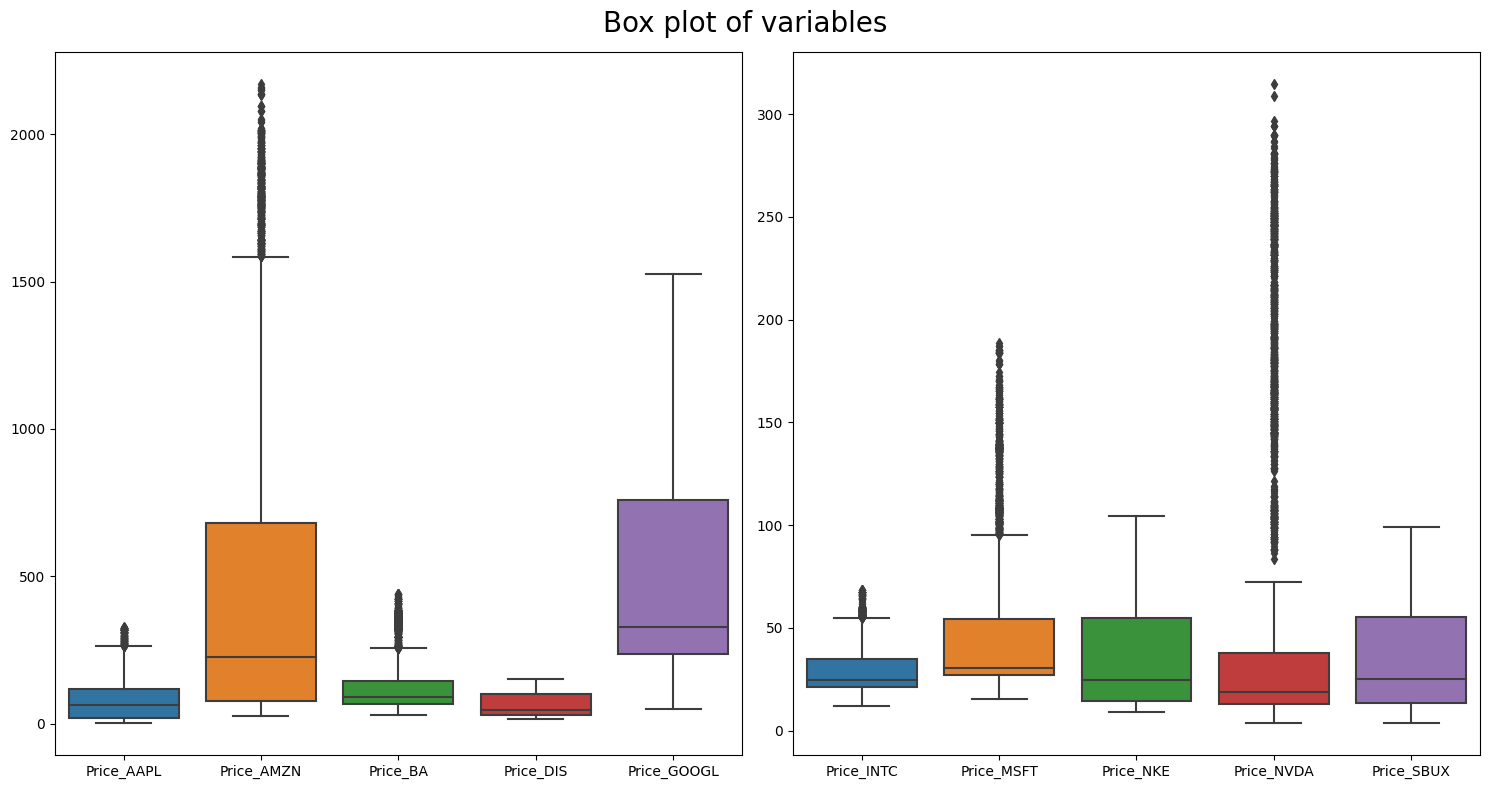

In [8]:
plt.figure(figsize=(15, 8))
plt.suptitle('Box plot of variables', fontsize=20)

plt.subplot(1, 2, 1)
sns.boxplot(data[['Price_AAPL', 'Price_AMZN', 'Price_BA', 'Price_DIS', 'Price_GOOGL']])

plt.subplot(1, 2, 2)
sns.boxplot(data[['Price_INTC', 'Price_MSFT', 'Price_NKE', 'Price_NVDA', 'Price_SBUX']])

plt.tight_layout()
plt.show()

## Data Visualization

In [9]:
def plot_ts(data, label):
    sns.lineplot(data=data, x='Date', y=label)
    plt.title(label)
    plt.ylabel('')
    plt.xlabel('')
    
    plt.xticks(
        ticks=pd.date_range(start='2004-05-01', end='2020-05-01', freq='YS'),
        labels=[str(year) for year in range(2004, 2020)],
        rotation=45
    )

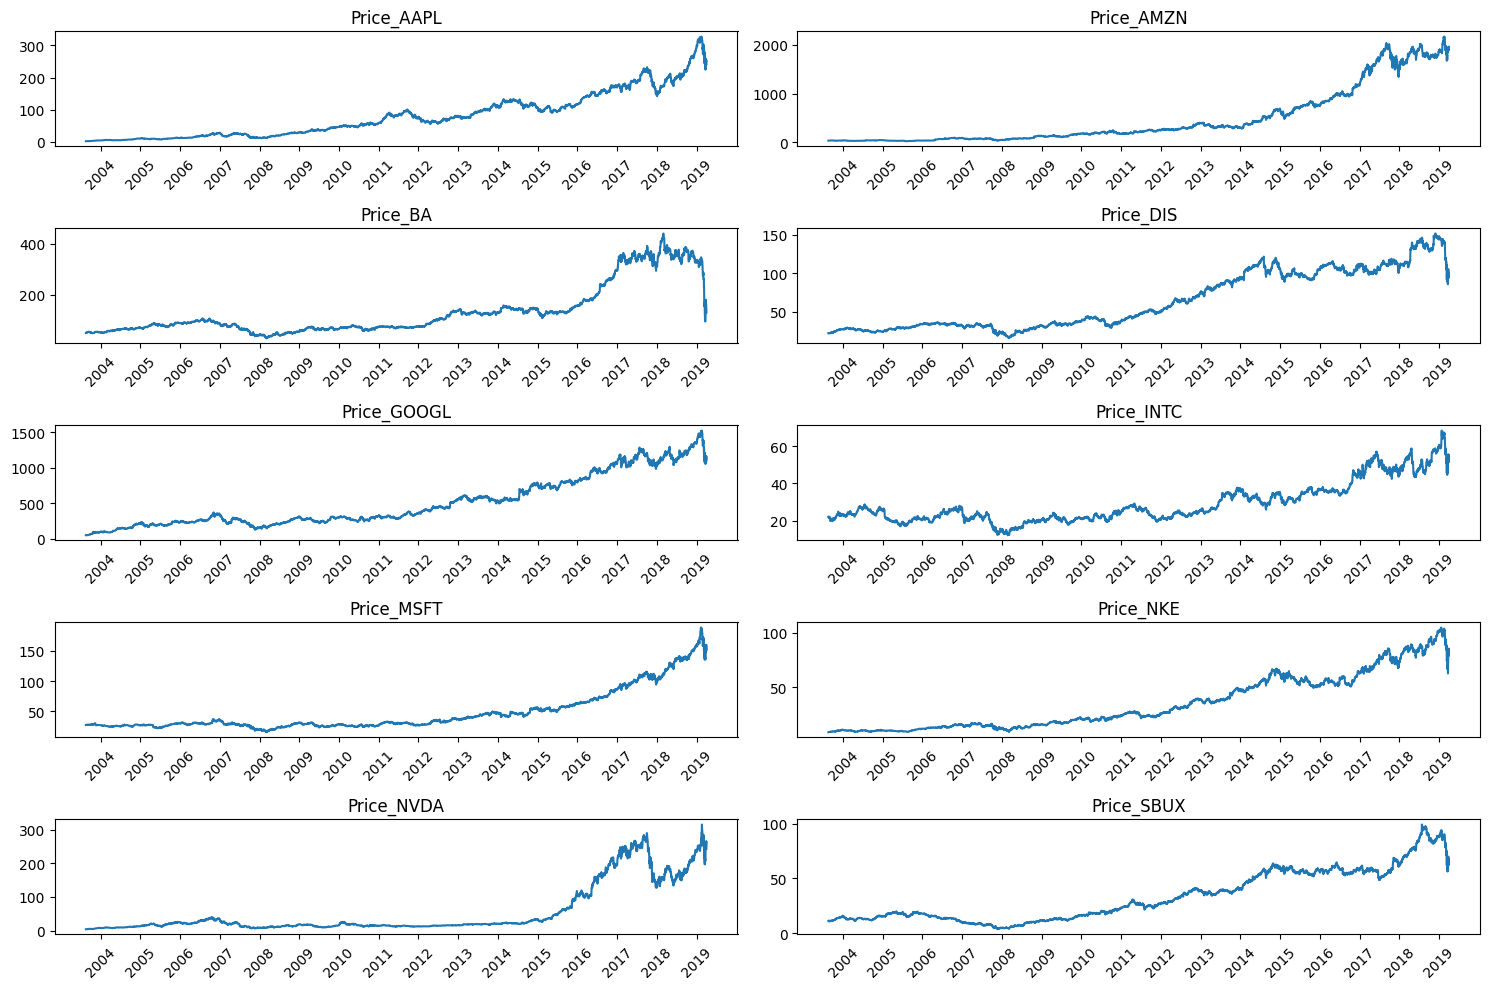

In [10]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(data.columns[1:]):
    plt.subplot(5, 2, i + 1)
    plot_ts(data, col)

plt.tight_layout()
plt.show()

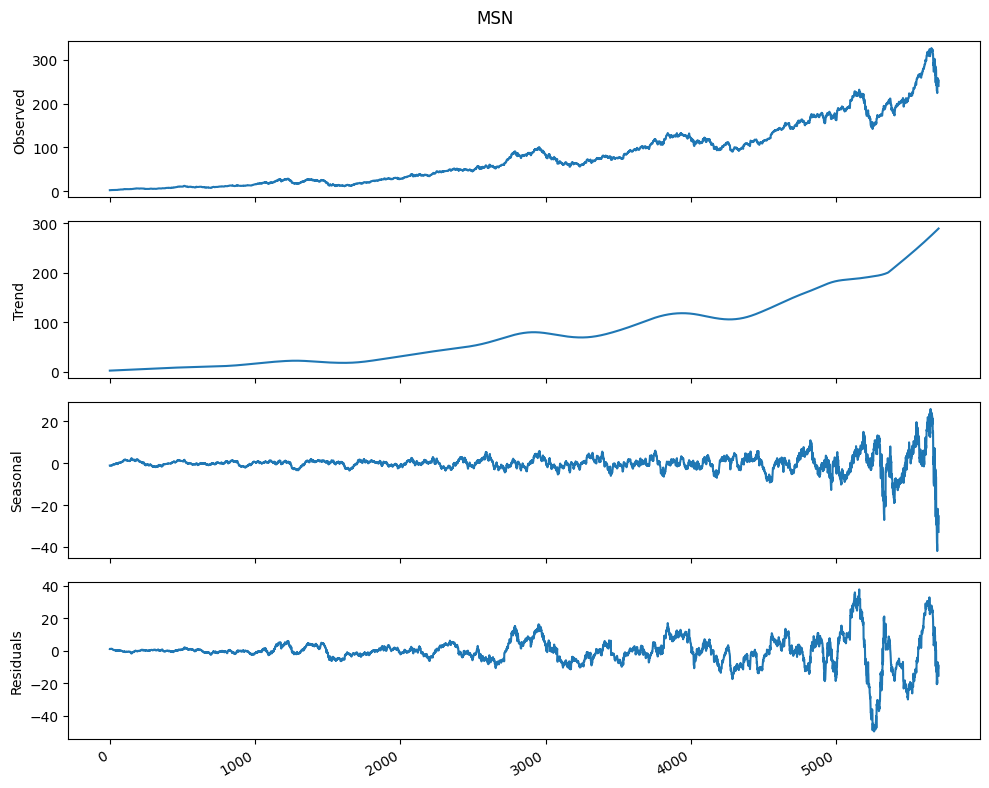

In [11]:
decomposition = STL(data['Price_AAPL'], period=365).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.suptitle('MSN')
plt.tight_layout()

## Split & Scale Data

In [ ]:
len(data[data['Date'] < '2019-01-01'])

5248

In [ ]:
train_df = data[:5248].drop(columns=['Date']).reset_index(drop=True)
test_df = data[5248:].drop(columns=['Date']). reset_index(drop=True)

In [13]:
scalers={}

scaled_train = train_df.copy()
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    s_s = scaler.fit_transform(scaled_train[i].values.reshape(-1,1))
    s_s = np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    scaled_train[i]=s_s
    
scaled_test = test_df.copy()
for i in test_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(scaled_test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    scaled_test[i]=s_s

## SARIMAX

In [ ]:
statistic = []
p_value = []
for i in range(1, 11):
    ad_fuller_result = adfuller(data[data.columns[i]])
    statistic.append(ad_fuller_result[0])
    p_value.append(round(ad_fuller_result[1], 5))
    
ADF_res = pd.DataFrame({'Statistic': statistic, 'P-value': p_value}, index=data.columns[1:])
ADF_res

Statistic  P-value
Price_AAPL   -0.426044  0.90566
Price_AMZN    1.752502  0.99825
Price_BA     -1.474616  0.54603
Price_DIS    -1.051789  0.73391
Price_GOOGL  -0.565212  0.87865
Price_INTC   -0.820875  0.81291
Price_MSFT    2.917981  1.00000
Price_NKE    -0.215483  0.93665
Price_NVDA    0.402054  0.98157
Price_SBUX   -0.637134  0.86237

In [ ]:
diff_data = scaled_train.diff()
diff_data = diff_data.iloc[1:, :]

statistic = []
p_value = []
for i in range(10):
    ad_fuller_result = adfuller(diff_data[diff_data.columns[i]])
    statistic.append(ad_fuller_result[0])
    p_value.append(round(ad_fuller_result[1], 5))
    
ADF_res = pd.DataFrame({'Statistic': statistic, 'P-value': p_value}, index=diff_data.columns)
ADF_res

Statistic  P-value
Price_AAPL  -10.907818      0.0
Price_AMZN  -11.072580      0.0
Price_BA    -11.690744      0.0
Price_DIS   -16.128862      0.0
Price_GOOGL -23.031412      0.0
Price_INTC  -16.996233      0.0
Price_MSFT  -18.713874      0.0
Price_NKE   -12.941202      0.0
Price_NVDA   -9.385581      0.0
Price_SBUX  -73.052309      0.0

### Find the optimize hyperparameters

In [ ]:
def optimize_SARIMAX(endog, exog, order_list, d, D, s):
    results = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog, exog, 
                order=(order[0], d, order[1]), 
                seasonal_order=(order[2], D, order[3], s), 
                simple_differencing=False
            ).fit(disp=False)
            aic = model.aic
            results.append([order, aic])
        except:
            continue
    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [ ]:
p = range(0, 4)
d = 1
q = range(0, 4)
P = range(0, 4)
D = 0
Q = range(0, 4)
s = 30
parameters = list(product(p, q, P, Q))

In [ ]:
def recursive_forecast(endog, exog, train_len, horizon, window, order, seasonal_order):
    pred_SARIMAX = []
    for i in range(train_len, train_len + horizon, window):
        try:
            model = SARIMAX(endog[:i], exog[:i], 
                            order=order, 
                            seasonal_order=seasonal_order, 
                            simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog[i:i + window])
            oos_pred = predictions.predicted_mean.iloc[:window]
            pred_SARIMAX.extend(oos_pred)
        except:
            pred_SARIMAX.extend([np.nan] * window)
    return pred_SARIMAX[:horizon]

### Model training

In [ ]:
metrics = []
prediction_SARIMAX = []

# Loop through each variable as the target
for i, target_col in enumerate(scaled_train.columns):
    target = scaled_train[target_col]
    exog = scaled_train.drop(columns=[target_col])

    # Find best parameters for the SARIMAX model
    result_df = optimize_SARIMAX(target, exog, parameters, d, D, s)
    best_order = result_df.iloc[0]['(p,q,P,Q)']
    
    # Train SARIMAX with best parameters
    start = time.time()
    best_model = SARIMAX(target, exog, 
                         order=(best_order[0], d, best_order[1]), 
                         seasonal_order=(best_order[2], D, best_order[3], s), 
                         simple_differencing=False)
    best_model_fit = best_model.fit(disp=False)
    end = time.time()
    
    # Forecast on the test set
    target_test = scaled_test[target_col]
    exog_test = scaled_test.drop(columns=[target_col])
    train_len = len(target)
    horizon = len(target_test)
    window = 30
    
    pred_SARIMAX = recursive_forecast(target, exog, train_len, horizon, window, 
                                      (best_order[0], d, best_order[1]), 
                                      (best_order[2], D, best_order[3], s))
    
    # Compute performance metrics
    mse = mean_squared_error(target_test, pred_SARIMAX, squared=True)
    rmse = mean_squared_error(target_test, pred_SARIMAX, squared=False)
    mae = mean_absolute_error(target_test, pred_SARIMAX)
    r2 = r2_score(target_test, pred_SARIMAX)

    # Unscale predictions
    scaler = scalers[f'scaler_{target_col}']
    unscaled_SARIMAX = scaler.inverse_transform(
        np.array(pred_SARIMAX[:horizon]).reshape(-1, 1)
    )
    prediction_SARIMAX.append(unscaled_SARIMAX)
    
    # Unscaled target
    real_values = data.loc[5248:, target_col].values  # Adjust index as needed
    
    # Compute unscaled metrics
    unscale_mse = mean_squared_error(real_values, unscaled_SARIMAX)
    unscale_rmse = mean_squared_error(real_values, unscaled_SARIMAX, squared=False)
    unscale_mae = mean_absolute_error(real_values, unscaled_SARIMAX)
    
    
    # Store metrics
    metrics.append({
        'Variable': target_col,
        'Best Order': best_order,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'Unscale MSE': unscale_mse,
        'Unscale RMSE': unscale_rmse,
        'Unscale MAE': unscale_mae,
        'R2': r2,
        'Time': end-start
    })

In [ ]:
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

      Variable    Best Order       MSE      RMSE       MAE   Unscale MSE  \
0   Price_AAPL  (2, 2, 2, 0)  3.900241  1.974903  1.928613  5.152528e+04   
1   Price_AMZN  (2, 2, 0, 2)  3.105700  1.762300  1.757777  3.147580e+06   
2     Price_BA  (0, 0, 0, 1)  2.707351  1.645403  1.616187  8.915674e+04   
3    Price_DIS  (0, 1, 0, 2)  4.174484  2.043155  2.024229  1.174826e+04   
4  Price_GOOGL  (0, 1, 0, 0)  3.621898  1.903128  1.893464  1.382048e+06   
5   Price_INTC  (0, 1, 0, 0)  2.130042  1.459466  1.433704  1.078334e+03   
6   Price_MSFT  (2, 2, 0, 0)  4.983088  2.232283  2.195943  1.257259e+04   
7    Price_NKE  (2, 1, 1, 2)  4.240935  2.059353  2.048665  6.179434e+03   
8   Price_NVDA  (1, 0, 1, 0)  1.753654  1.324256  1.293582  3.572851e+04   
9   Price_SBUX  (0, 1, 0, 0)  4.727113  2.174192  2.153334  5.013775e+03   

   Unscale RMSE  Unscale MAE          R2        Time  
0    226.991810   221.671391  -21.078536  177.838240  
1   1774.142184  1769.588887 -219.239811  185.553558 

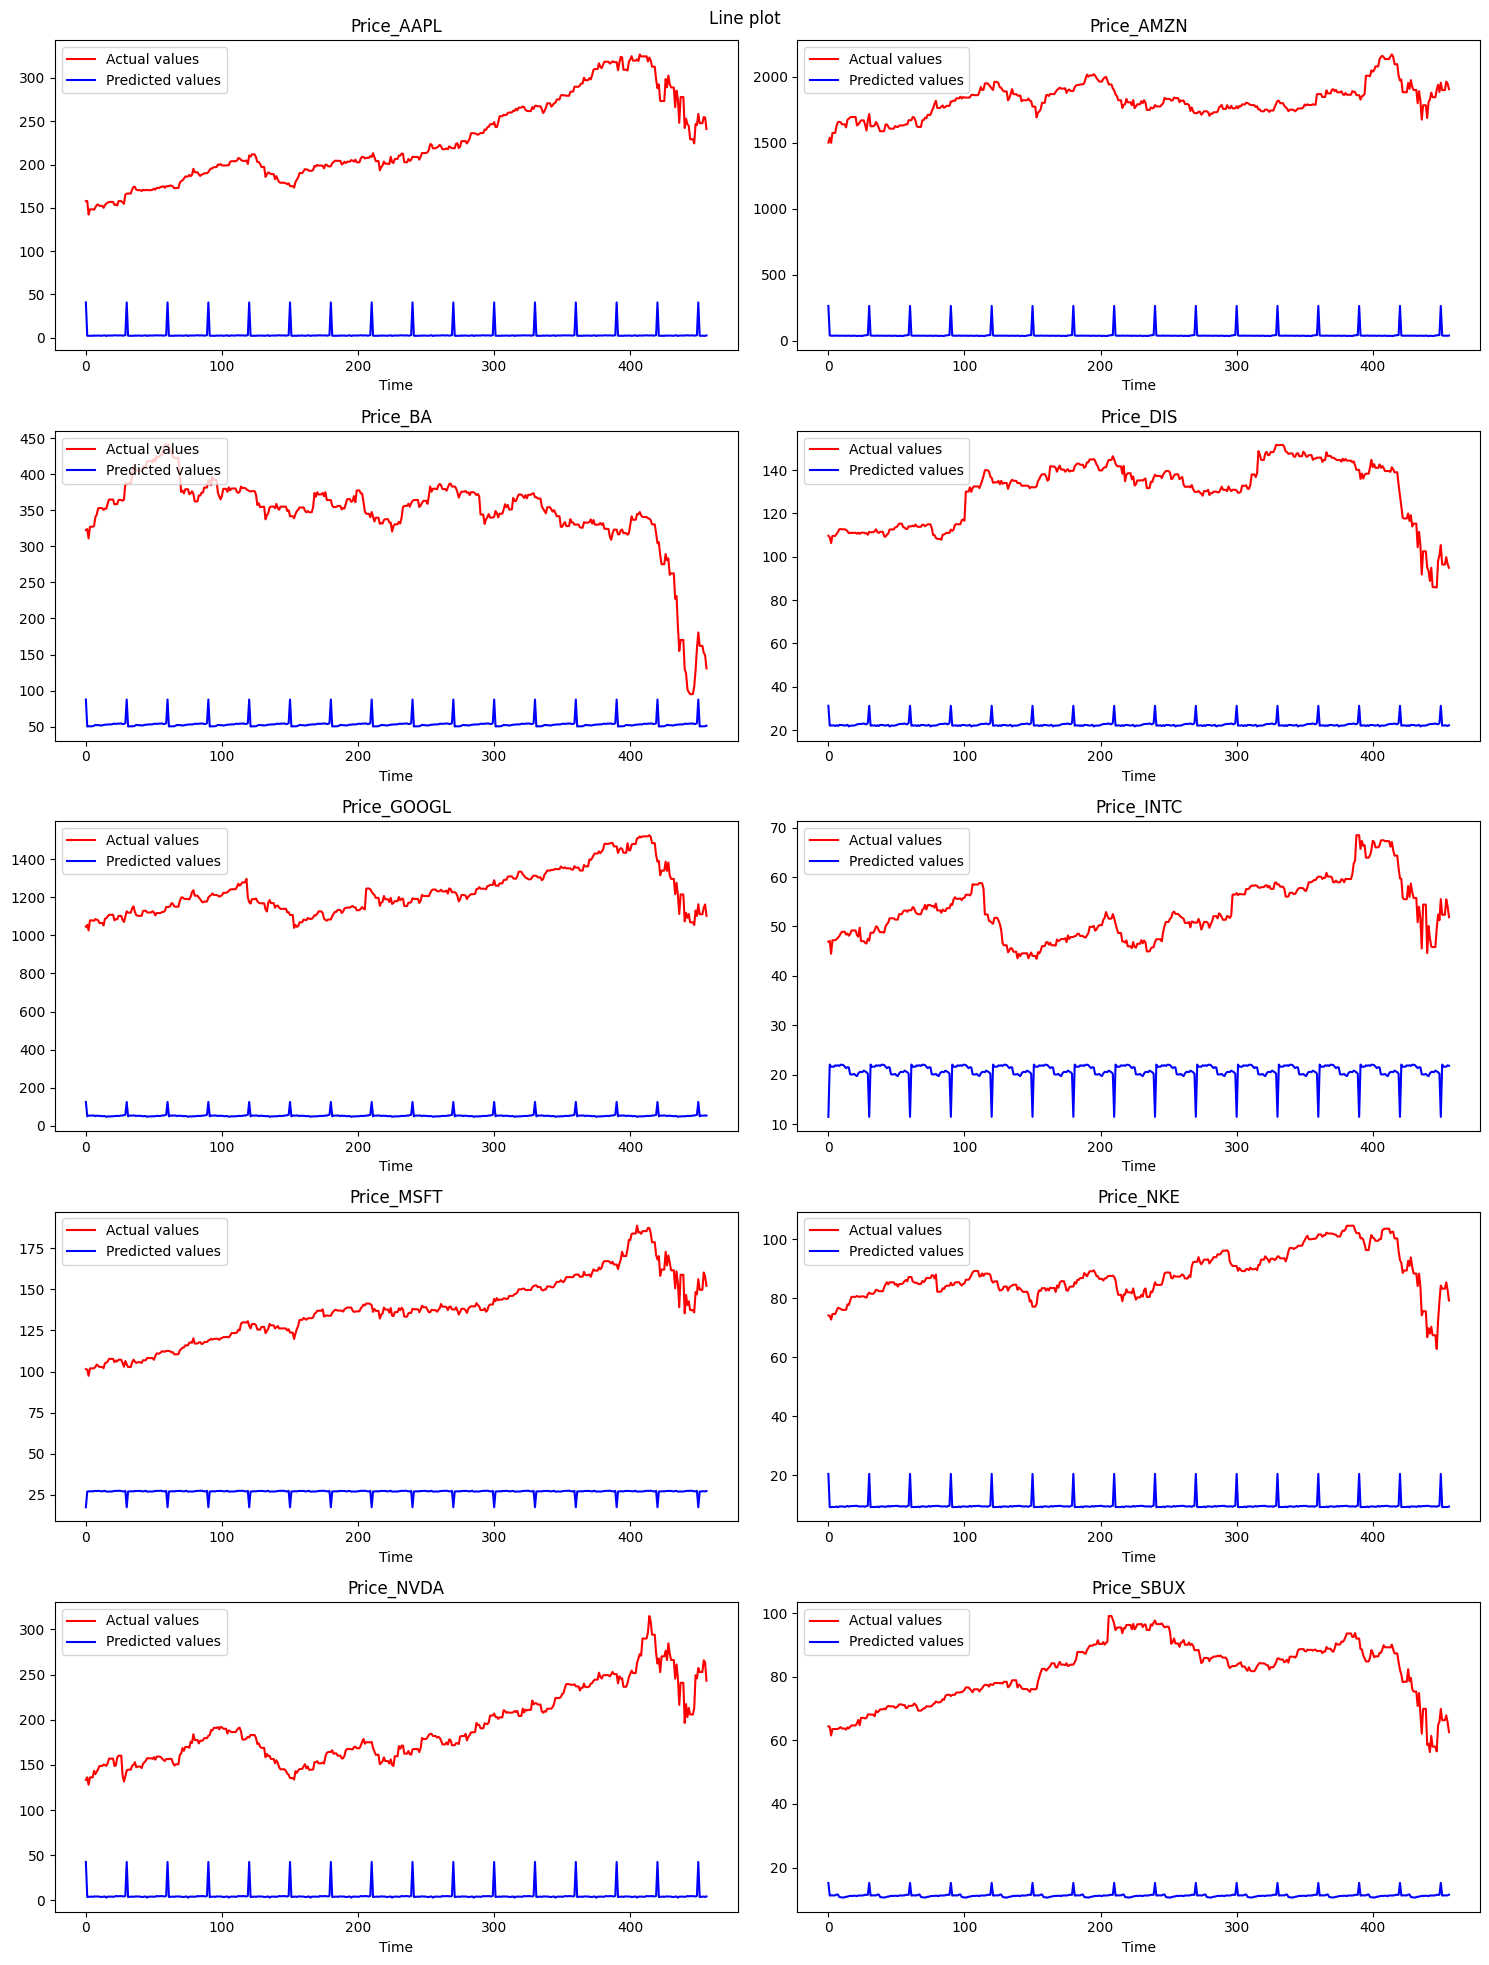

In [ ]:
plt.figure(figsize=(15, 20))
prediction_SARIMAX = np.array(prediction_SARIMAX)
for i in range(10):
    plt.subplot(5, 2, i + 1)  
    plt.plot(test_df.index, test_df.iloc[:, i], 'r-', markersize=10, label='Actual values')
    plt.plot(test_df.index, prediction_SARIMAX[i], 'b-', label='Predicted values')
    plt.xlabel('Time')
    plt.title(f'{test_df.columns[i]}')
    plt.legend(loc='upper left')

plt.suptitle('Line plot')
plt.tight_layout()
plt.show()

# ARIMAX

In [ ]:
def optimize_ARIMAX(endog, exog, order_list, d):
    results = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog, exog, 
                order=(order[0], d, order[1]),
                simple_differencing=False
            ).fit(disp=False)
            aic = model.aic
            results.append([order, aic])
        except:
            continue
    result_df = pd.DataFrame(results, columns=['(p,q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [ ]:
p = range(0, 14)
d = 1
q = range(0, 14)
parameters = list(product(p, q))

In [ ]:
metrics = []
prediction_SARIMAX = []

for i, target_col in enumerate(scaled_train.columns):
    target = scaled_train[target_col]
    exog = scaled_train.drop(columns=[target_col])

    result_df = optimize_SARIMAX(target, exog, parameters, d)
    best_order = result_df.iloc[0]['(p,q)']
        
    start = time.time()
    best_model = SARIMAX(target, exog, 
                         order=(best_order[0], d, best_order[1]),
                         simple_differencing=False)
    best_model_fit = best_model.fit(disp=False)
    end = time.time()
    
    target_test = scaled_test[target_col]
    exog_test = scaled_test.drop(columns=[target_col])
    train_len = len(target)
    horizon = len(target_test)
    window = 7

    pred_SARIMAX = recursive_forecast(endog=target, exog=exog, train_len=train_len, horizon=horizon, window=window,
                                      order=(best_order[0], d, best_order[1]))
    
    mse = mean_squared_error(target_test, pred_SARIMAX, squared=True)
    rmse = mean_squared_error(target_test, pred_SARIMAX, squared=False)
    mae = mean_absolute_error(target_test, pred_SARIMAX)
    r2 = r2_score(target_test, pred_SARIMAX)

    scaler = scalers[f'scaler_{target_col}']
    unscaled_SARIMAX = scaler.inverse_transform(
        np.array(pred_SARIMAX[:horizon]).reshape(-1, 1)
    )
    prediction_SARIMAX.append(unscaled_SARIMAX)
    
    real_values = test_df.loc[:, target_col].values  
    
    # Compute unscaled metrics
    unscale_mse = mean_squared_error(real_values, unscaled_SARIMAX)
    unscale_rmse = mean_squared_error(real_values, unscaled_SARIMAX, squared=False)
    unscale_mae = mean_absolute_error(real_values, unscaled_SARIMAX)
    
    # Store metrics
    metrics.append({
        'Variable': target_col,
        'Best Order': best_order,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'Unscale MSE': unscale_mse,
        'Unscale RMSE': unscale_rmse,
        'Unscale MAE': unscale_mae,
        'R2': r2,
        'Time': end-start
    })

In [ ]:
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

      Variable Best Order       MSE      RMSE       MAE   Unscale MSE  \
0   Price_AAPL     (0, 3)  3.627627  1.904633  1.805651  2.341250e+04   
1   Price_AMZN     (0, 4)  2.572646  1.603947  1.596984  1.975449e+06   
2     Price_BA    (5, 13)  2.277805  1.509240  1.466183  4.588438e+04   
3    Price_DIS     (0, 0)  4.743548  2.177969  2.103160  3.169746e+03   
4  Price_GOOGL     (0, 1)  3.078616  1.754598  1.727826  4.784459e+05   
5   Price_INTC     (1, 0)  2.805925  1.675090  1.638700  7.900598e+02   
6   Price_MSFT     (1, 2)  6.355332  2.520978  2.470798  1.032932e+04   
7    Price_NKE     (0, 3)  3.811029  1.952186  1.926910  2.410082e+03   
8   Price_NVDA     (9, 0)  1.592752  1.262043  1.221573  2.989435e+04   
9   Price_SBUX     (0, 0)  6.458915  2.541440  2.476676  1.905809e+03   

   Unscale RMSE  Unscale MAE          R2        Time  
0    153.011428   145.059530   -9.032233    9.552648  
1   1405.506686  1399.405284 -137.224432   13.293033  
2    214.206398   208.095364  -

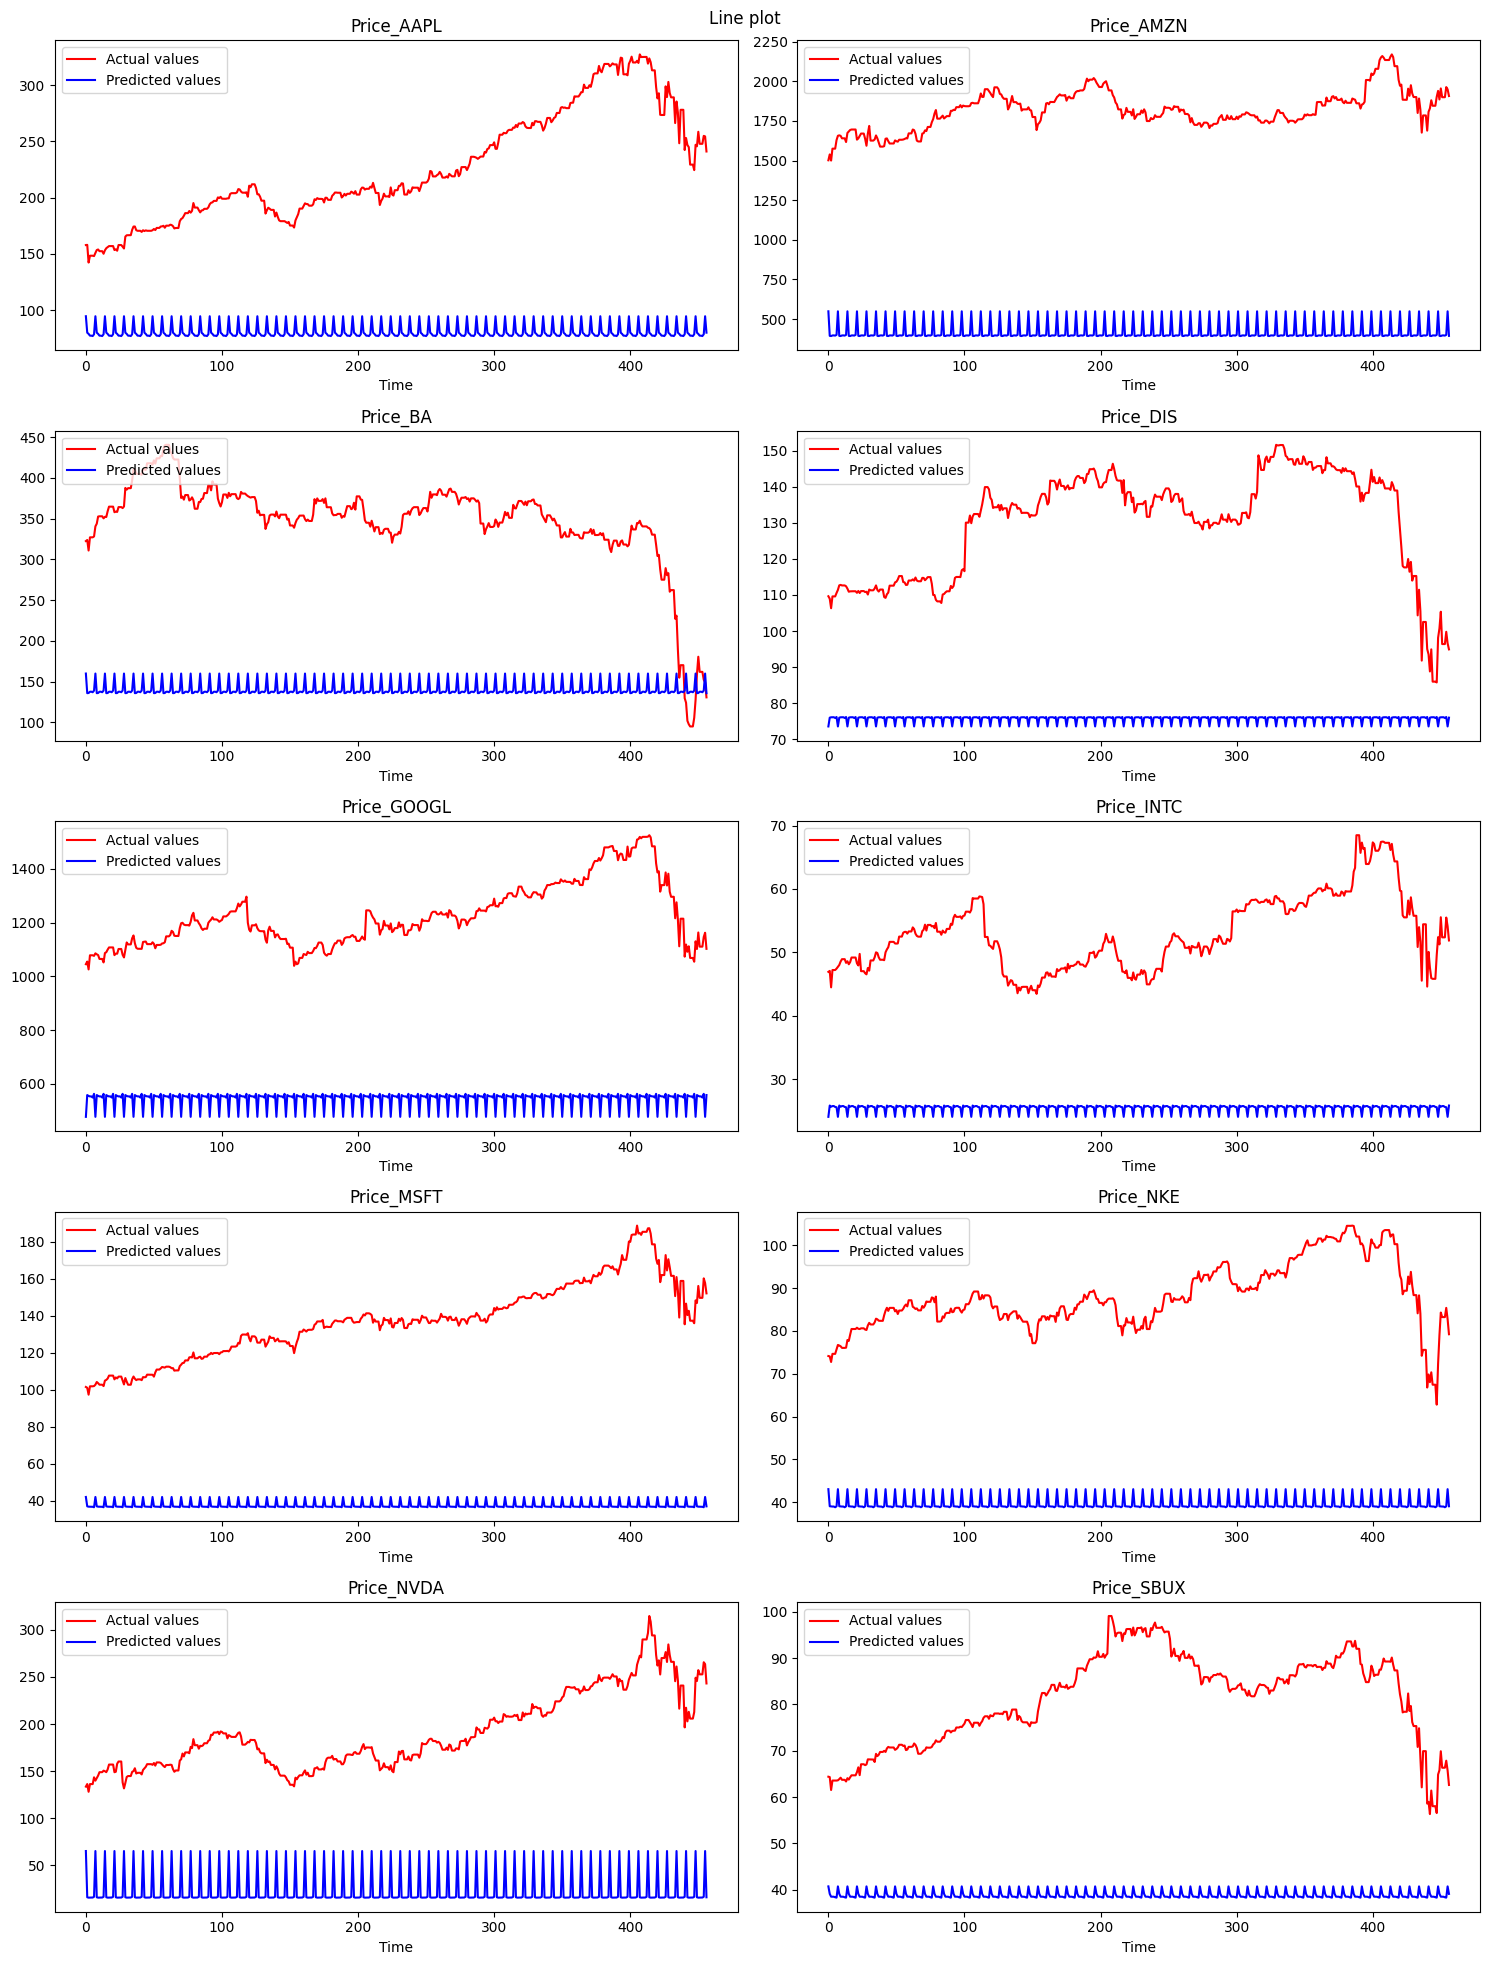

In [ ]:
plt.figure(figsize=(15, 20))
prediction_SARIMAX = np.array(prediction_SARIMAX)
for i in range(10):
    plt.subplot(5, 2, i + 1)  
    plt.plot(test_df.index, test_df.iloc[:, i], 'r-', markersize=10, label='Actual values')
    plt.plot(test_df.index, prediction_SARIMAX[i], 'b-', label='Predicted values')
    plt.xlabel('Time')
    plt.title(f'{test_df.columns[i]}')
    plt.legend(loc='upper left')

plt.suptitle('Line plot')
plt.tight_layout()
plt.show()

# Gaussian Process

### Define model

In [43]:
train_Gaussian = diff_data
test_Gaussian = scaled_test

In [ ]:
X_train = train_Gaussian.index.values.reshape(-1, 1)
y_train = train_Gaussian.values

X_test = test_Gaussian.index.values.reshape(-1, 1)
y_test = test_Gaussian.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5247, 1) (5247, 10) (457, 1) (457, 10)


In [ ]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, ConstantKernel as C

kernel = (C(7.07, (1e-1, 1e5)) * RBF(length_scale=3) + 
          C(2.12, (1e-1, 1e5)) * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=90) + 
          C(0.707, (1e-5, 1e1)) * RationalQuadratic(alpha=1, length_scale=3))

### Model training

In [46]:
start = time.time()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_train, y_train)
end = time.time()

In [ ]:
gp

GaussianProcessRegressor(kernel=2.66**2 * RBF(length_scale=3) + 1.46**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=90) + 0.841**2 * RationalQuadratic(alpha=1, length_scale=3),
                         n_restarts_optimizer=10)

In [ ]:
print(gp.score(X_train, y_train))
print(end-start)

0.9999999999995565
9302.479202985764


In [49]:
def unscale(data):
    temp = data.copy()
    for index, i in enumerate(train_df.columns):
        scaler = scalers['scaler_' + i]
        temp[:, index] = scaler.inverse_transform(np.reshape(data[:, index], (-1, 1))).flatten()
    return temp

In [50]:
y_pred, sigma = gp.predict(X_test, return_std=True)
last_value = scaled_train.iloc[-1, :].values
y_pred = y_pred.cumsum(axis=0) + last_value

In [51]:
y_pred_unscale = unscale(y_pred)
sigma_unscale = unscale(sigma)

In [ ]:
pred_scaled_Gau = pd.DataFrame(data=y_pred, columns=data.drop(columns=['Date']).columns)
pred_scaled_Gau.index = pd.RangeIndex(5248,5248 + len(pred_scaled_Gau))
pred_scaled_Gau.head()

Price_AAPL  Price_AMZN  Price_BA  Price_DIS  Price_GOOGL  Price_INTC  \
5248    0.353483    0.465843  0.615260   0.773221     0.610785    0.548807   
5249    0.353539    0.466717  0.616418   0.773965     0.617243    0.531474   
5250    0.353539    0.466717  0.616418   0.773965     0.617243    0.531474   
5251    0.353539    0.466717  0.616418   0.773965     0.617243    0.531474   
5252    0.353713    0.466658  0.617465   0.768944     0.618126    0.543473   

      Price_MSFT  Price_NKE  Price_NVDA  Price_SBUX  
5248    0.720317   0.701062   -0.091941    0.867413  
5249    0.721909   0.703060   -0.090330    0.870407  
5250    0.721909   0.703060   -0.090330    0.870407  
5251    0.721909   0.703060   -0.090330    0.870407  
5252    0.722706   0.702012   -0.089699    0.870023

In [ ]:
pred_Gau = pd.DataFrame(y_pred_unscale, columns=data.drop(columns=['Date']).columns)
pred_Gau.index = pd.RangeIndex(5248,5248 + len(pred_Gau))
pred_Gau.head()

Price_AAPL   Price_AMZN    Price_BA   Price_DIS  Price_GOOGL  \
5248  157.760549  1501.763588  322.481282  109.659398  1045.073215   
5249  157.766978  1502.643585  322.691281  109.698858  1049.062203   
5250  157.766978  1502.643584  322.691281  109.698858  1049.062203   
5251  157.766978  1502.643584  322.691281  109.698858  1049.062203   
5252  157.786978  1502.583587  322.881283  109.432502  1049.607747   

      Price_INTC  Price_MSFT  Price_NKE  Price_NVDA  Price_SBUX  
5248   46.928156  101.561505  74.138984  133.499957   64.401975  
5249   46.538157  101.641505  74.215234  133.729957   64.499474  
5250   46.538157  101.641505  74.215234  133.729957   64.499474  
5251   46.538157  101.641505  74.215234  133.729957   64.499474  
5252   46.808155  101.681504  74.175234  133.819956   64.486975

### Model Evaluation
#### Scaled data

In [ ]:
for i in range(10):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(scaled_test.iloc[:, i], pred_scaled_Gau.iloc[:, i])}')
    
print(f'MSE total: {mean_squared_error(scaled_test, pred_scaled_Gau)}')

MSE for Price_AAPL: 0.4828011100134915
MSE for Price_AMZN: 0.11199142460336126
MSE for Price_BA: 0.11359060811149518
MSE for Price_DIS: 0.16809899747711016
MSE for Price_GOOGL: 0.06136283420001134
MSE for Price_INTC: 0.08687084759692584
MSE for Price_MSFT: 0.7007224898296028
MSE for Price_NKE: 0.15284804944033026
MSE for Price_NVDA: 0.20758272782288276
MSE for Price_SBUX: 0.30731025315831895
MSE total: 0.239317934225353


In [ ]:
for i in range(10):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(scaled_test.iloc[:, i], pred_scaled_Gau.iloc[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(scaled_test, pred_scaled_Gau, squared=False)}')

RMSE for Price_AAPL: 0.6948389093980644
RMSE for Price_AMZN: 0.334651198419132
RMSE for Price_BA: 0.33703205798780506
RMSE for Price_DIS: 0.4099987774092871
RMSE for Price_GOOGL: 0.24771522803415083
RMSE for Price_INTC: 0.29473860893497794
RMSE for Price_MSFT: 0.8370916854381023
RMSE for Price_NKE: 0.39095786146377753
RMSE for Price_NVDA: 0.45561247549083067
RMSE for Price_SBUX: 0.5543557099537435
RMSE total: 0.45569925125298705


In [ ]:
for i in range(10):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(scaled_test.iloc[:, i], pred_scaled_Gau.iloc[:, i])}')
    
print(f'MAE total: {mean_absolute_error(scaled_test, pred_scaled_Gau)}')

MAE for Price_AAPL: 0.5663150452398903
MAE for Price_AMZN: 0.3131886232629445
MAE for Price_BA: 0.23521459104160952
MAE for Price_DIS: 0.35149166166404894
MAE for Price_GOOGL: 0.20168424181224012
MAE for Price_INTC: 0.22273249023703437
MAE for Price_MSFT: 0.7287021911088908
MAE for Price_NKE: 0.34178819041751013
MAE for Price_NVDA: 0.3689495559778231
MAE for Price_SBUX: 0.47898907202019647
MAE total: 0.38090556627821887


In [ ]:
for i in range(10):
    print(f'R2 for {scaled_test.columns[i]}: {r2_score(scaled_test.iloc[:, i], pred_scaled_Gau.iloc[:, i])}')
    
print(f'R2 total: {r2_score(scaled_test, pred_scaled_Gau)}')

R2 for Price_AAPL: -1.7330468132289765
R2 for Price_AMZN: -6.9418402626362345
R2 for Price_BA: -0.2079595933109195
R2 for Price_DIS: -1.2160459451493209
R2 for Price_GOOGL: -0.7006036841878962
R2 for Price_INTC: -0.3074294033294023
R2 for Price_MSFT: -3.3832674700044816
R2 for Price_NKE: -2.722891523620409
R2 for Price_NVDA: -1.6657515565335377
R2 for Price_SBUX: -2.4312051332473748
R2 total: -2.131004138524854


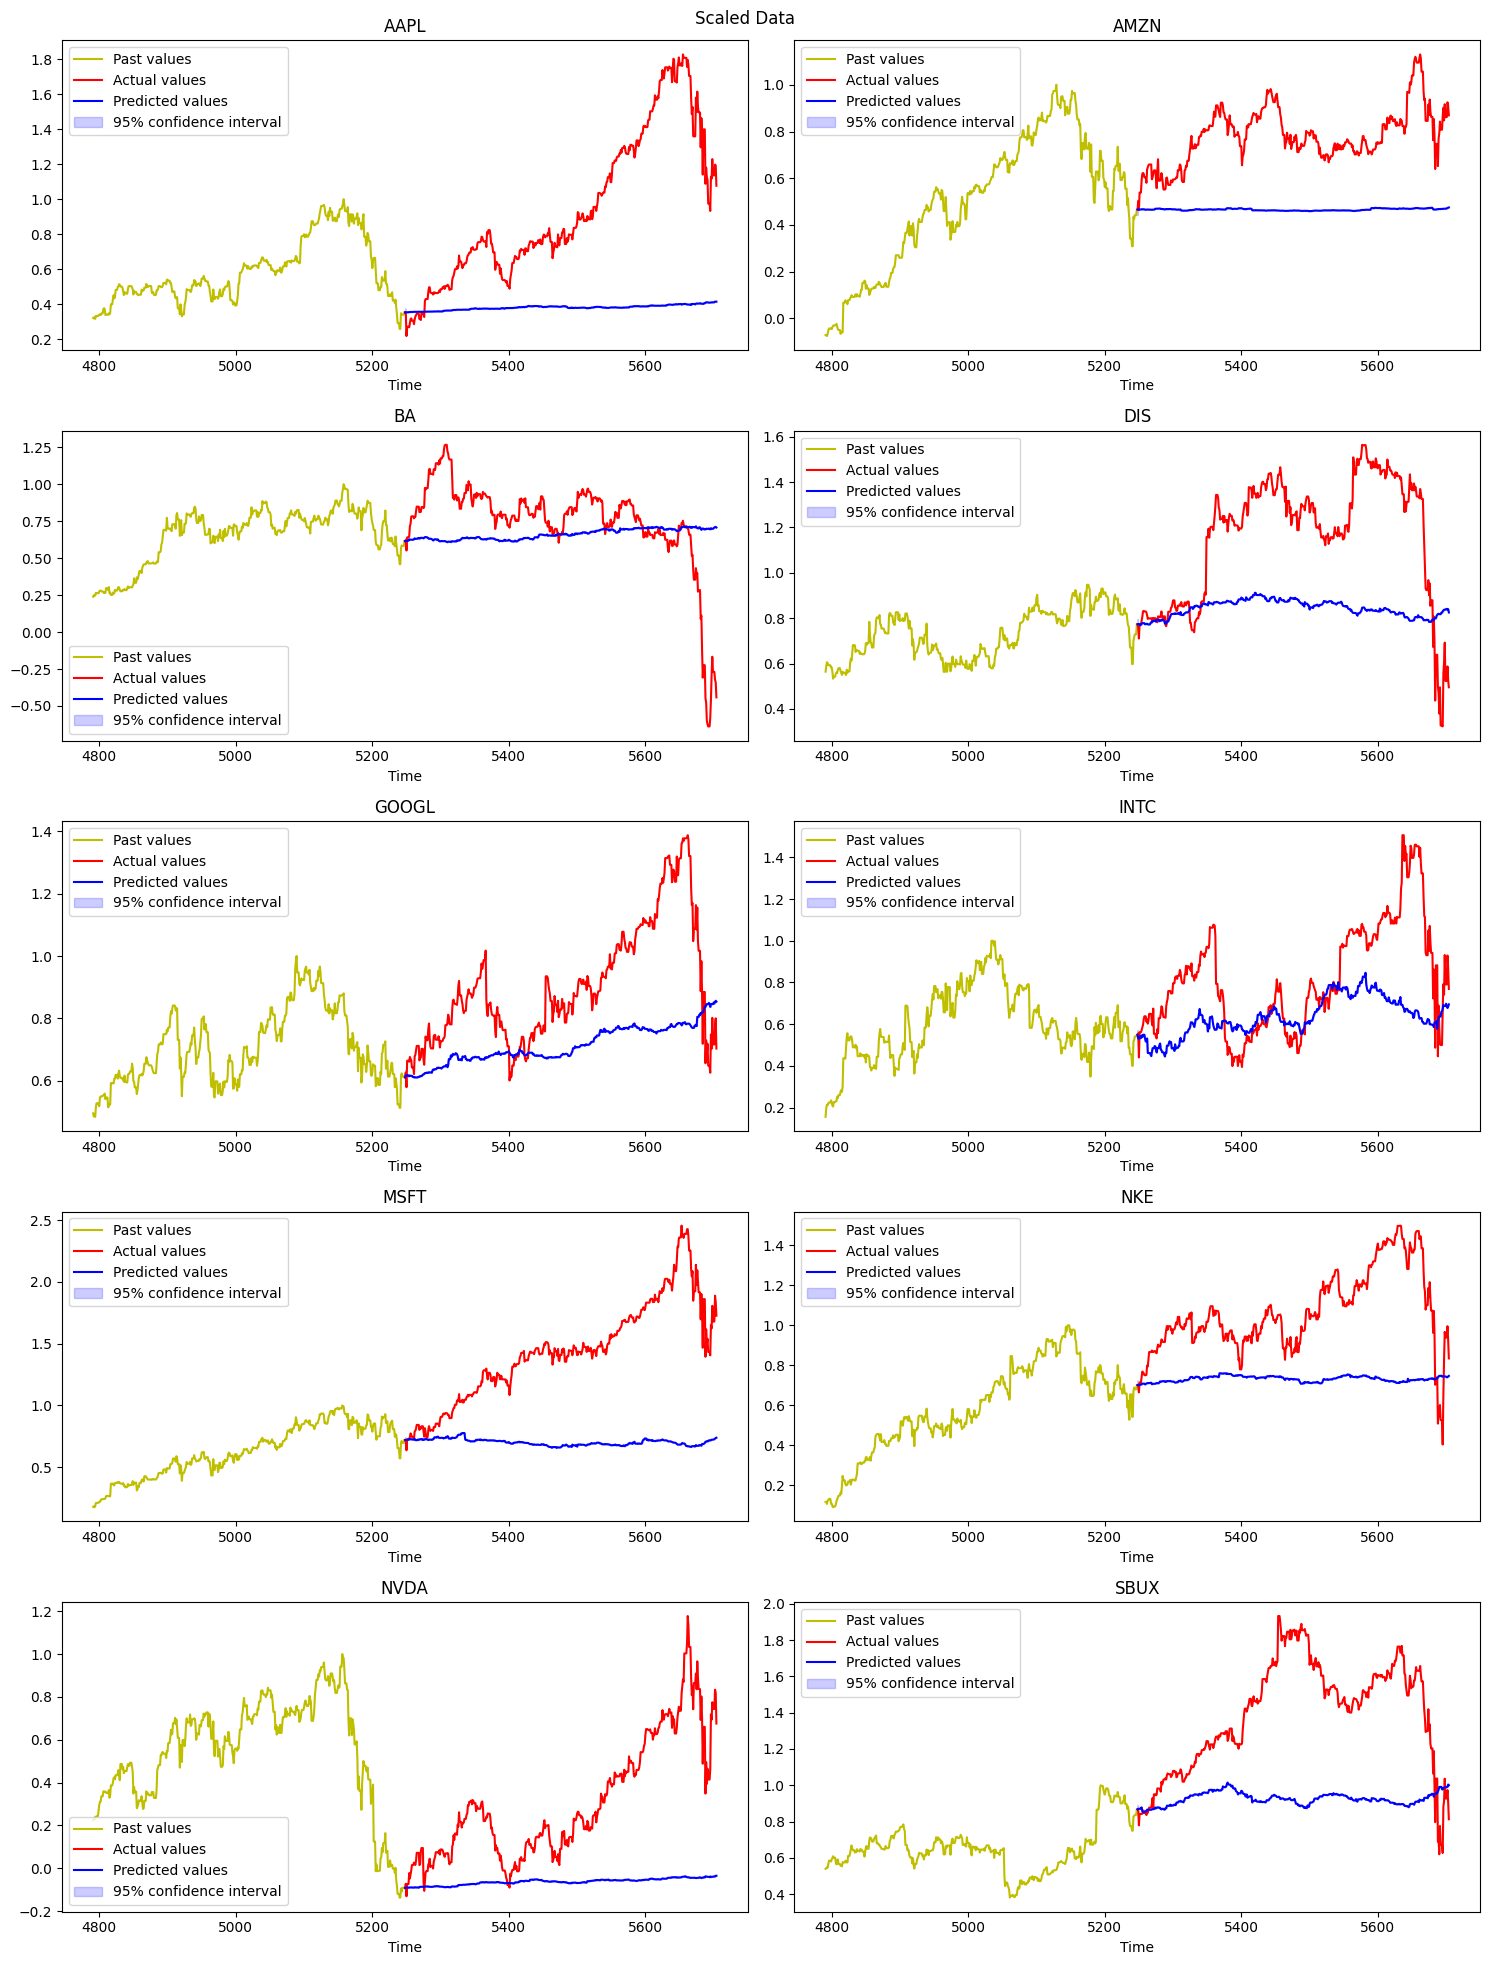

In [ ]:
plt.figure(figsize=(15, 20))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(X_train[-len(pred_scaled_Gau):, :], scaled_train.iloc[-len(pred_scaled_Gau):, i], 'y-', markersize=10, label='Past values')
    plt.plot(pred_scaled_Gau.index, y_test[:, i], 'r-', markersize=10, label='Actual values')
    plt.plot(pred_scaled_Gau.index, pred_scaled_Gau.iloc[:, i], 'b-', label='Predicted values')
    plt.fill_between(pred_scaled_Gau.index, pred_scaled_Gau.iloc[:, i] - 1.96 * sigma[:, i], pred_scaled_Gau.iloc[:, i] + 1.96 * sigma[:, i], alpha=0.2, color='blue', label='95% confidence interval')
    plt.xlabel('Time')
    plt.title(f'{train_Gaussian.columns[i][6:]}')
    plt.legend()

plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

#### Unscaled data

In [ ]:
for i in range(10):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(test_df.iloc[:, i], pred_Gau.iloc[:, i])}')
    
print(f'MSE total: {mean_squared_error(test_df, pred_Gau)}')

MSE for Price_AAPL: 6378.1859863348145
MSE for Price_AMZN: 113501.64783900167
MSE for Price_BA: 3740.693046361722
MSE for Price_DIS: 473.08144925821017
MSE for Price_GOOGL: 23414.894939900656
MSE for Price_INTC: 43.97837032403613
MSE for Price_MSFT: 1767.959944969223
MSE for Price_NKE: 222.713693016897
MSE for Price_NVDA: 4229.239411553525
MSE for Price_SBUX: 325.9461906519558
MSE total: 15409.834087137267


In [ ]:
for i in range(10):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(test_df.iloc[:, i], pred_Gau.iloc[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(test_df, pred_Gau, squared=False)}')

RMSE for Price_AAPL: 79.86354604157528
RMSE for Price_AMZN: 336.90005615761135
RMSE for Price_BA: 61.16120540311253
RMSE for Price_DIS: 21.750435610769046
RMSE for Price_GOOGL: 153.01926329681717
RMSE for Price_INTC: 6.631618982121646
RMSE for Price_MSFT: 42.047115774678566
RMSE for Price_NKE: 14.923595177332338
RMSE for Price_NVDA: 65.03260268168209
RMSE for Price_SBUX: 18.053979911696917
RMSE total: 79.93834190373968


In [ ]:
for i in range(10):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(test_df.iloc[:, i], pred_Gau.iloc[:, i])}')
    
print(f'MAE total: {mean_absolute_error(test_df, pred_Gau)}')

MAE for Price_AAPL: 65.09124212507544
MAE for Price_AMZN: 315.2932523883016
MAE for Price_BA: 42.684390328903156
MAE for Price_DIS: 18.646633053528078
MAE for Price_GOOGL: 124.58488864653665
MAE for Price_INTC: 5.011481242747529
MAE for Price_MSFT: 36.60271142077075
MAE for Price_NKE: 13.046696570025322
MAE for Price_NVDA: 52.66262706621536
MAE for Price_SBUX: 15.599476886233486
MAE total: 68.92233997283375


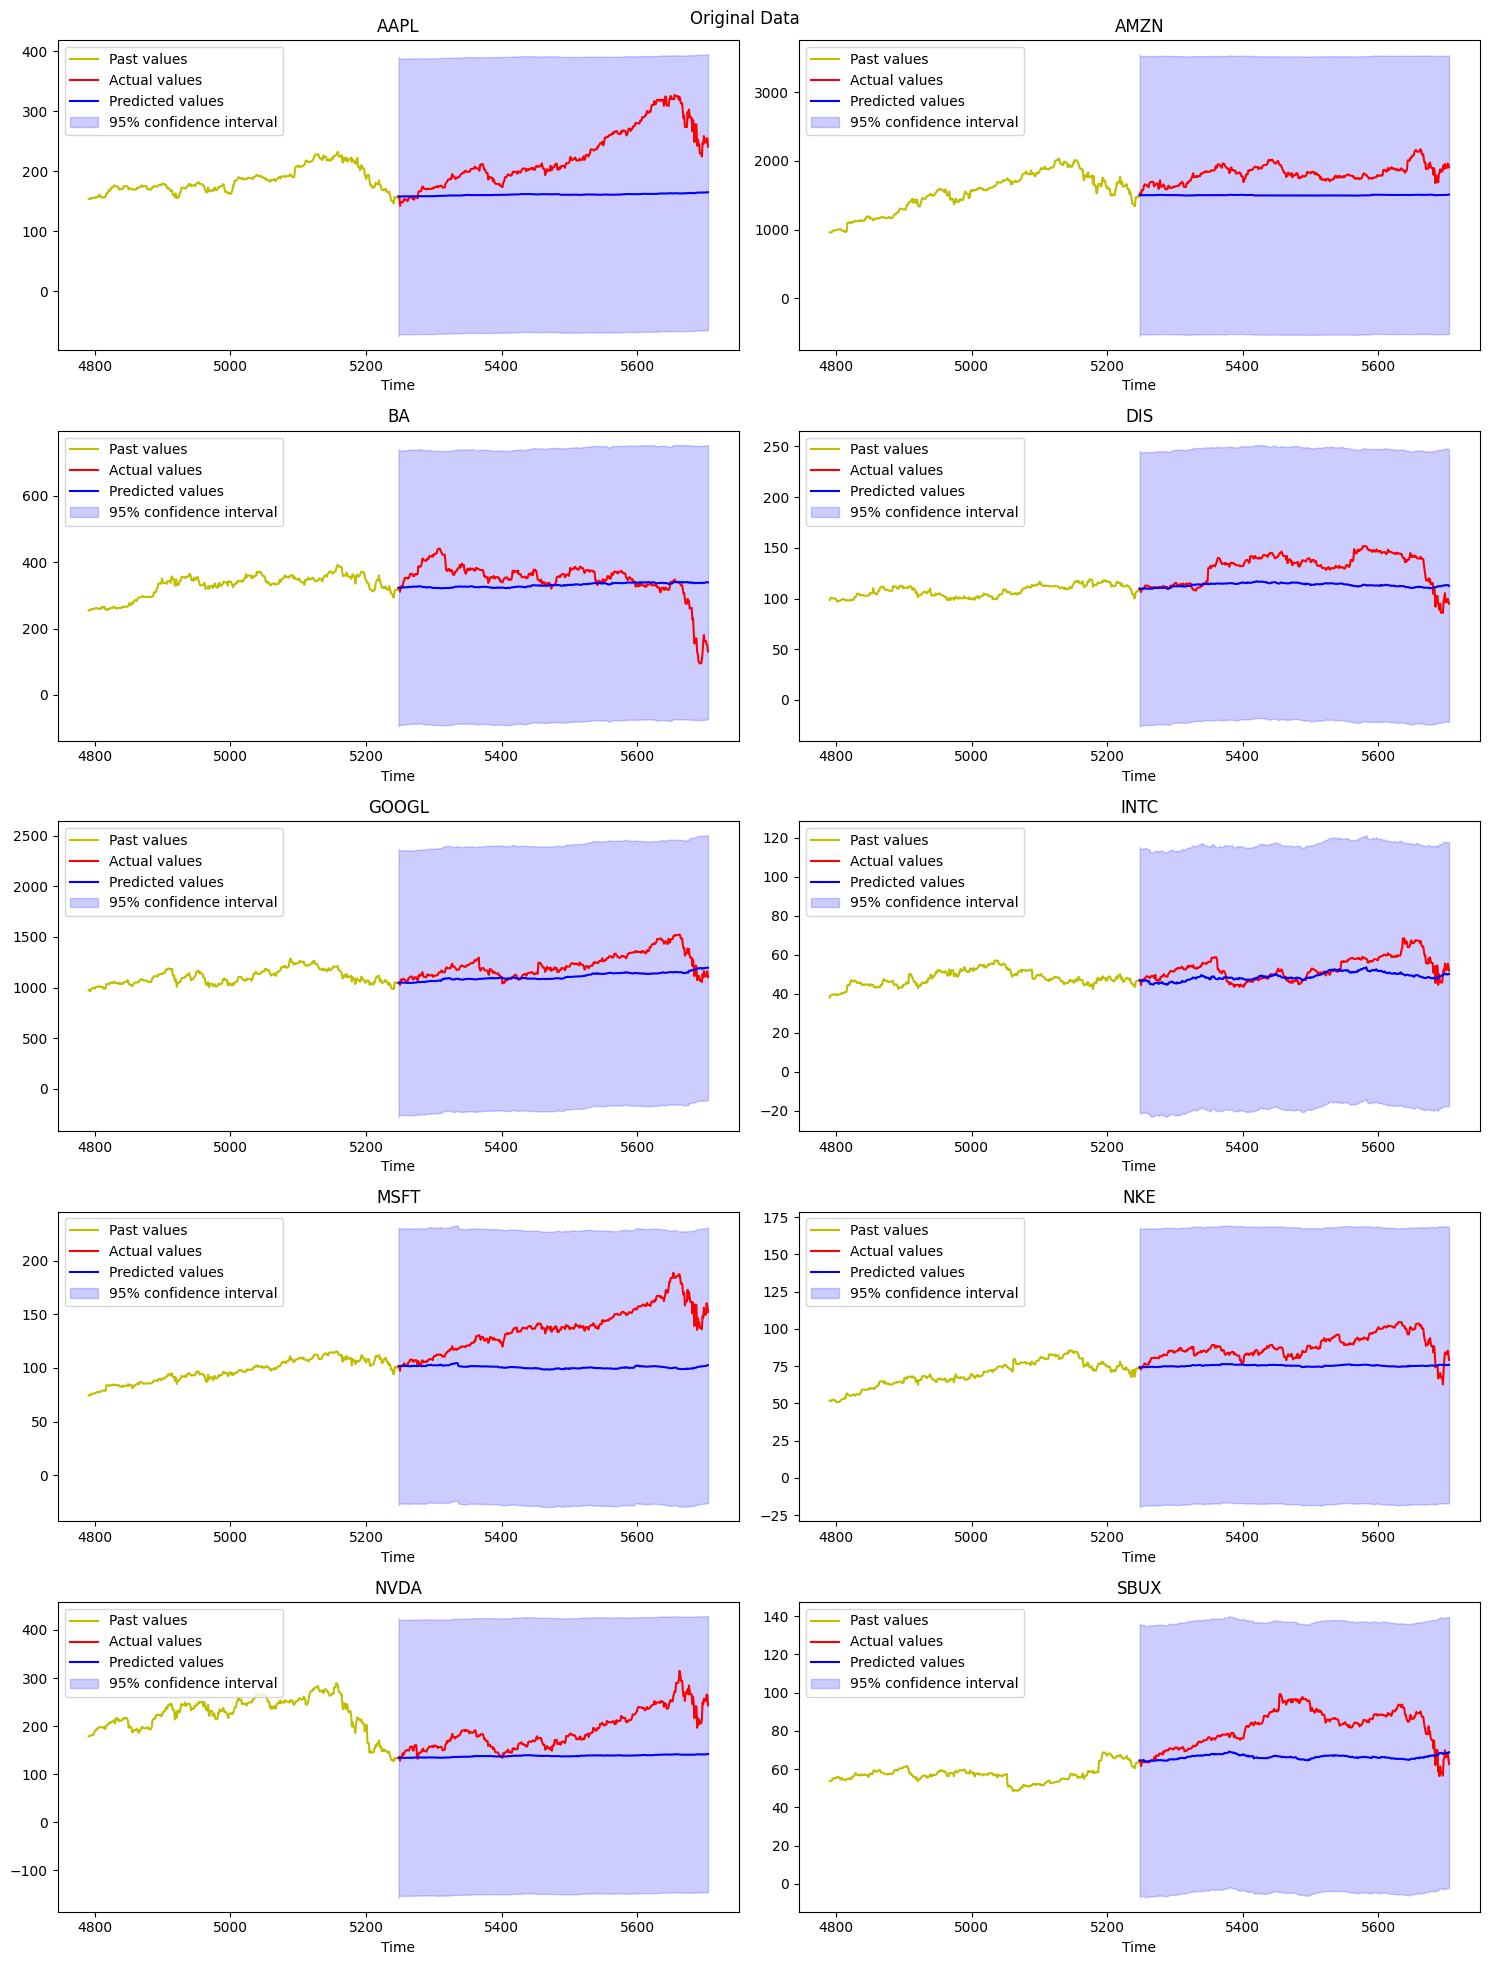

In [ ]:
plt.figure(figsize=(15, 20))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(X_train[-len(pred_Gau):, :], train_df.iloc[-len(pred_Gau):, i], 'y-', markersize=10, label='Past values')
    plt.plot(pred_Gau.index, test_df.iloc[:, i], 'r-', markersize=10, label='Actual values')
    plt.plot(pred_Gau.index, pred_Gau.iloc[:, i], 'b-', label='Predicted values')
    plt.fill_between(pred_Gau.index, pred_Gau.iloc[:, i] - 1.96 * sigma_unscale[:, i], pred_Gau.iloc[:, i] + 1.96 * sigma_unscale[:, i], alpha=0.2, color='blue', label='95% confidence interval')
    plt.xlabel('Time')
    plt.title(f'{train_Gaussian.columns[i][6:]}')
    plt.legend(loc='upper left')
 
plt.suptitle('Original Data')
plt.tight_layout()
plt.show()

## VAR
### Find the optimize hyperparameters

In [ ]:
def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    
    results = []
    
    for i in tqdm_notebook(range(1, 15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        aic = model.aic
        results.append([i, aic])
        print(results)
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
result_df = optimize_VAR(diff_data)
result_df

  0%|          | 0/1 [00:00<?, ?it/s]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          165     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.20293D+01    |proj g|=  4.59993D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  165      3     39      2     0     0   1.330D-01  -3.203D+01
  F =  -32.029342480652517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


[[2, -335858.2762101097], [3, -335968.344847776], [4, -336104.8505978511], [5, -336248.0115256344], [6, -336330.30038219696], [7, -336562.9591011047], [8, -336579.2055910511], [9, -336631.8191163222], [10, -336658.1241173941], [11, -336653.4223165944], [12, -336716.2908896506], [13, -336783.1638928994], [14, -336989.0582531051], [1, -335785.9199919675]]


p            AIC
0   14 -336989.058253
1   13 -336783.163893
2   12 -336716.290890
3   10 -336658.124117
4   11 -336653.422317
5    9 -336631.819116
6    8 -336579.205591
7    7 -336562.959101
8    6 -336330.300382
9    5 -336248.011526
10   4 -336104.850598
11   3 -335968.344848
12   2 -335858.276210
13   1 -335785.919992

### Performing tests

In [ ]:
def granger_causality_matrix(data, max_lag):
    variables = data.columns
    df = pd.DataFrame(index=variables, columns=variables)
    for var1 in variables:
        for var2 in variables:
            test_result = grangercausalitytests(data[[var1, var2]], max_lag, verbose=False)
            p_values = [round(test[0]['ssr_ftest'][1], 4) for test in test_result.values()]
            min_p_value = np.min(p_values)
            df.loc[var1, var2] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
result = granger_causality_matrix(diff_data, 14)
result

Price_AAPL_x Price_AMZN_x Price_BA_x Price_DIS_x Price_GOOGL_x  \
Price_AAPL_y           1.0          0.0        0.0      0.0004           0.0   
Price_AMZN_y        0.0101          1.0        0.0      0.0001        0.0001   
Price_BA_y             0.0          0.0        1.0         0.0           0.0   
Price_DIS_y            0.0       0.0001     0.0864         1.0        0.0132   
Price_GOOGL_y       0.0005          0.0        0.0        0.16           1.0   
Price_INTC_y        0.2673       0.0003     0.0001      0.2365        0.1155   
Price_MSFT_y        0.1325       0.0052     0.0003      0.2285        0.0002   
Price_NKE_y            0.0          0.0        0.0      0.0005           0.0   
Price_NVDA_y           0.0          0.0        0.0      0.0234        0.0003   
Price_SBUX_y           0.0          0.0        0.0       0.001           0.0   

              Price_INTC_x Price_MSFT_x Price_NKE_x Price_NVDA_x Price_SBUX_x  
Price_AAPL_y           0.0          0.0      0.0061          0.0       0.0008  
Price_AMZN_y           0.0          0.0         0.0          0.0       0.0002  
Price_BA_y             0.0          0.0      0.0004          0.0       0.0157  
Price_DIS_y            0.0          0.0      0.0001          0.0       0.4426  
Price_GOOGL_y          0.0          0.0      0.0124          0.0       0.0003  
Price_INTC_y           1.0       0.0002      0.0011          0.0       0.0065  
Price_MSFT_y        0.0003          1.0         0.0          0.0       0.0003  
Price_NKE_y            0.0          0.0         1.0          0.0       0.0018  
Price_NVDA_y        0.0023          0.0      0.0022          1.0          0.0  
Price_SBUX_y        0.0006          0.0      0.0347       0.0002          1.0

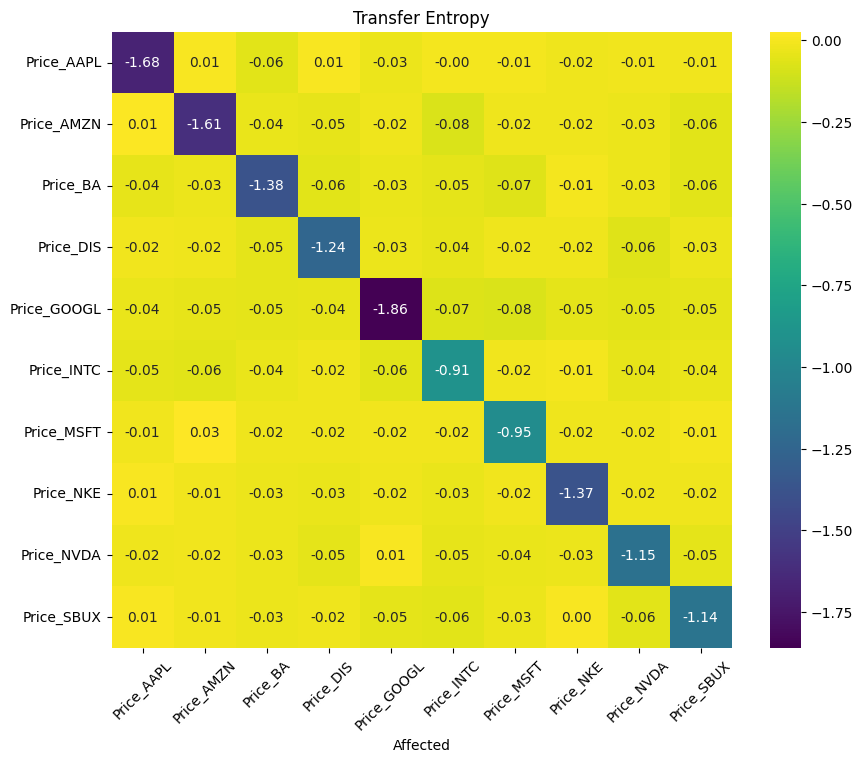

In [ ]:
transfer_entropy_matrix = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        transfer = transent(diff_data.iloc[:, i], diff_data.iloc[:, j], lag=14)
        transfer_entropy_matrix[i, j] = transfer

transfer_entropy_df = pd.DataFrame(transfer_entropy_matrix, 
                                   columns=[f'{diff_data.columns[i]}' for i in range(10)], 
                                   index=[f'{diff_data.columns[j]}' for j in range(10)])

plt.figure(figsize=(10, 8))
sns.heatmap(transfer_entropy_df, annot=True, cmap='viridis', fmt=".2f")
plt.title('Transfer Entropy')
plt.xlabel('Affected')
plt.xticks(rotation=45)
plt.show()

In [ ]:
VAR_train = scaled_train.drop(columns=['Price_INTC', 'Price_MSFT', 'Price_DIS'])
VAR_test = scaled_test.drop(columns=['Price_INTC', 'Price_MSFT', 'Price_DIS'])

diff_data = VAR_train.diff()
diff_data = diff_data.iloc[1:, :]

In [ ]:
granger_causality_matrix(diff_data, 14)

Price_AAPL_x Price_AMZN_x Price_BA_x Price_GOOGL_x Price_NKE_x  \
Price_AAPL_y           1.0          0.0        0.0           0.0      0.0061   
Price_AMZN_y        0.0101          1.0        0.0        0.0001         0.0   
Price_BA_y             0.0          0.0        1.0           0.0      0.0004   
Price_GOOGL_y       0.0005          0.0        0.0           1.0      0.0124   
Price_NKE_y            0.0          0.0        0.0           0.0         1.0   
Price_NVDA_y           0.0          0.0        0.0        0.0003      0.0022   
Price_SBUX_y           0.0          0.0        0.0           0.0      0.0347   

              Price_NVDA_x Price_SBUX_x  
Price_AAPL_y           0.0       0.0008  
Price_AMZN_y           0.0       0.0002  
Price_BA_y             0.0       0.0157  
Price_GOOGL_y          0.0       0.0003  
Price_NKE_y            0.0       0.0018  
Price_NVDA_y           1.0          0.0  
Price_SBUX_y        0.0002          1.0

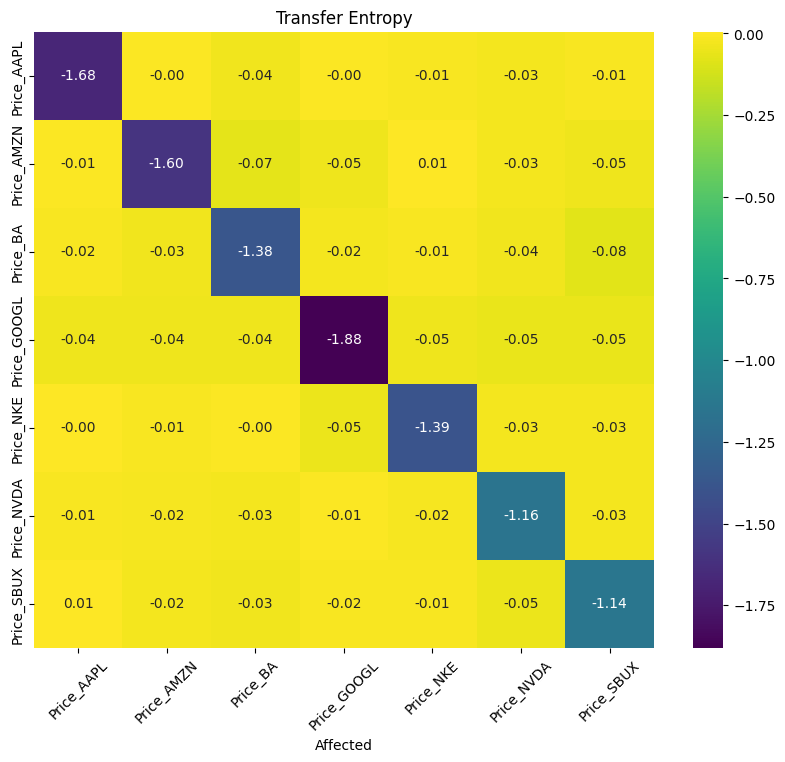

In [ ]:
transfer_entropy_matrix = np.zeros((7, 7))

for i in range(7):
    for j in range(7):
        transfer = transent(diff_data.iloc[:, i], diff_data.iloc[:, j], lag=14)
        transfer_entropy_matrix[i, j] = transfer

transfer_entropy_df = pd.DataFrame(transfer_entropy_matrix, 
                                   columns=[f'{diff_data.columns[i]}' for i in range(7)], 
                                   index=[f'{diff_data.columns[j]}' for j in range(7)])

plt.figure(figsize=(10, 8))
sns.heatmap(transfer_entropy_df, annot=True, cmap='viridis', fmt=".2f")
plt.title('Transfer Entropy')
plt.xlabel('Affected')
plt.xticks(rotation=45)
plt.show()

### Model training

In [ ]:
start = time.time()
best_model = VARMAX(diff_data, order=(14,0))
best_model_fit = best_model.fit(disp=False)
end = time.time()
print(best_model_fit.summary())

                                                                  Statespace Model Results                                                                  
Dep. Variable:     ['Price_AAPL', 'Price_AMZN', 'Price_BA', 'Price_GOOGL', 'Price_NKE', 'Price_NVDA', 'Price_SBUX']   No. Observations:                 5247
Model:                                                                                                      VAR(14)   Log Likelihood              119874.690
                                                                                                        + intercept   AIC                        -238307.380
Date:                                                                                              Wed, 27 Nov 2024   BIC                        -233573.718
Time:                                                                                                      13:56:00   HQIC                       -236652.350
Sample:                                                   

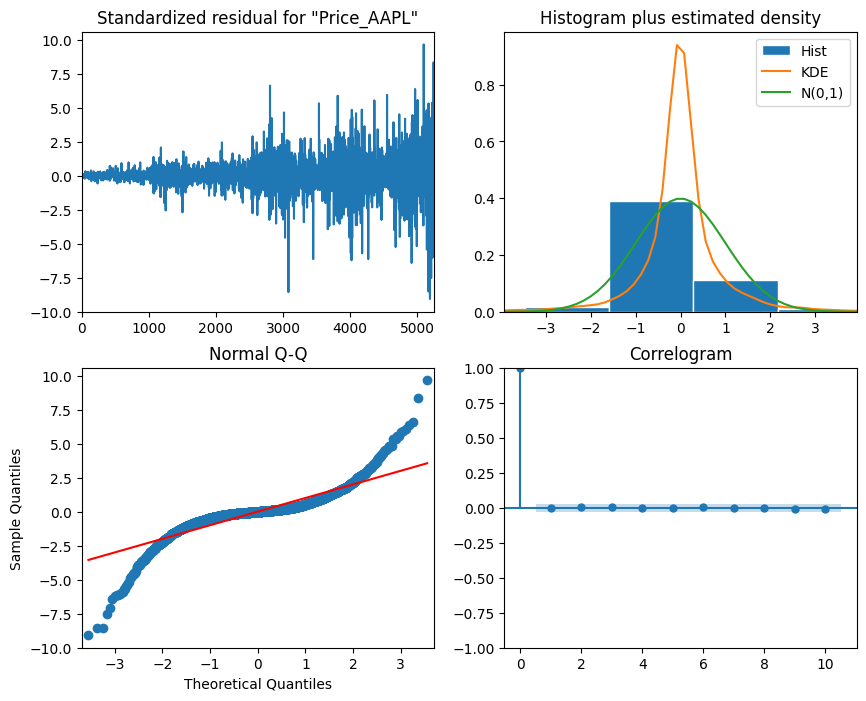

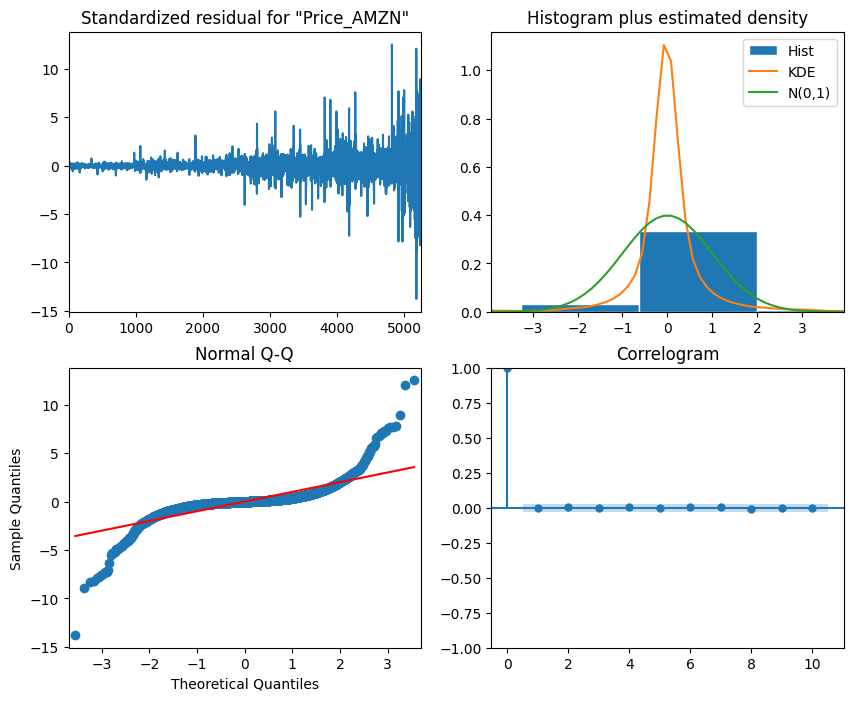

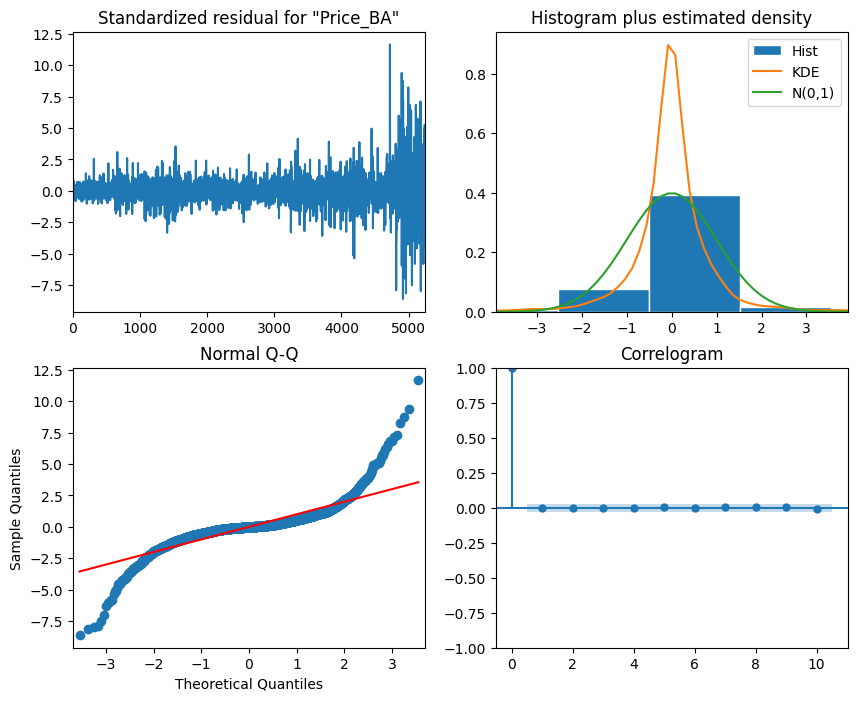

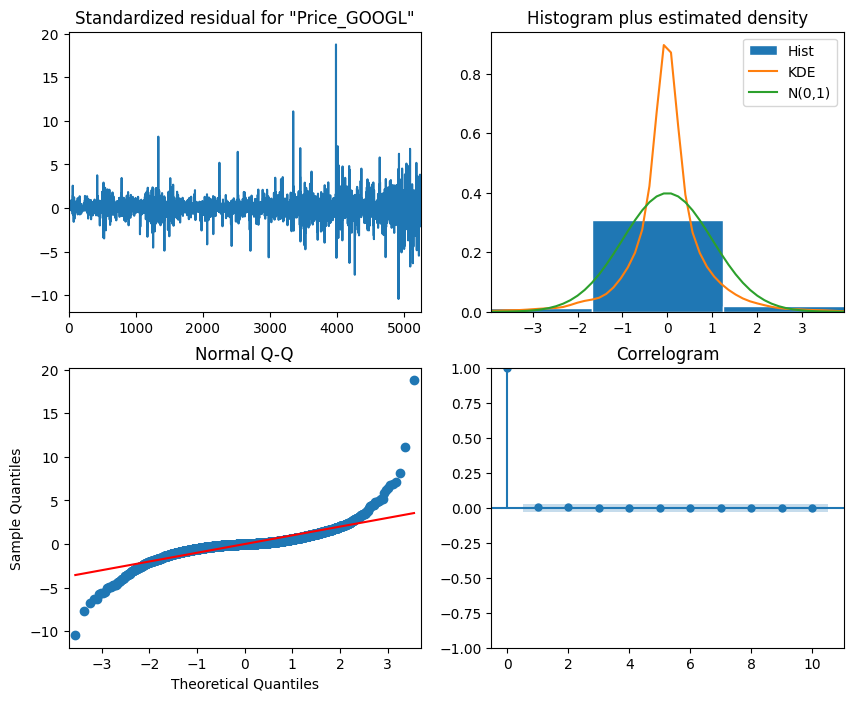

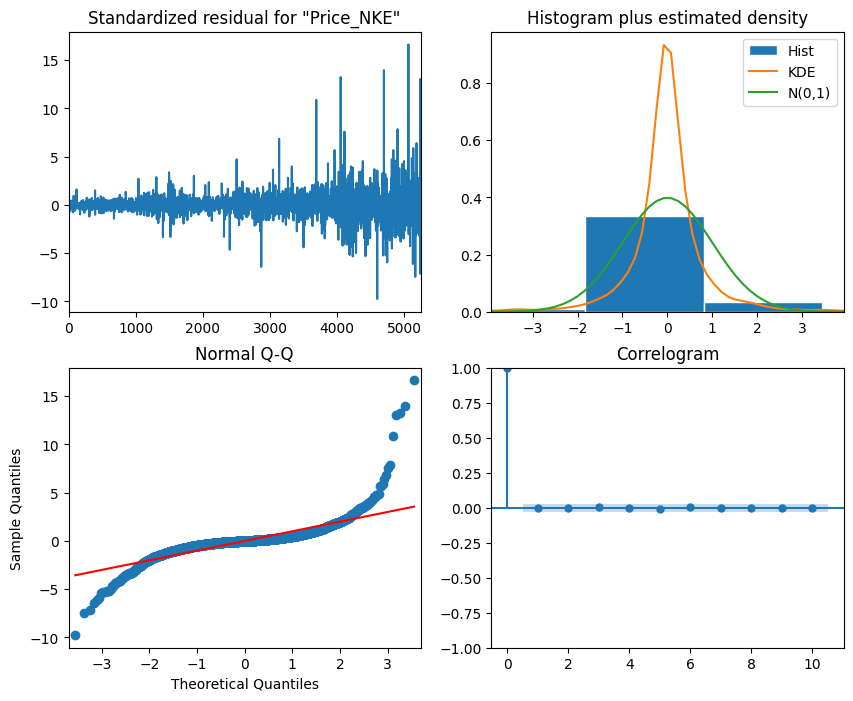

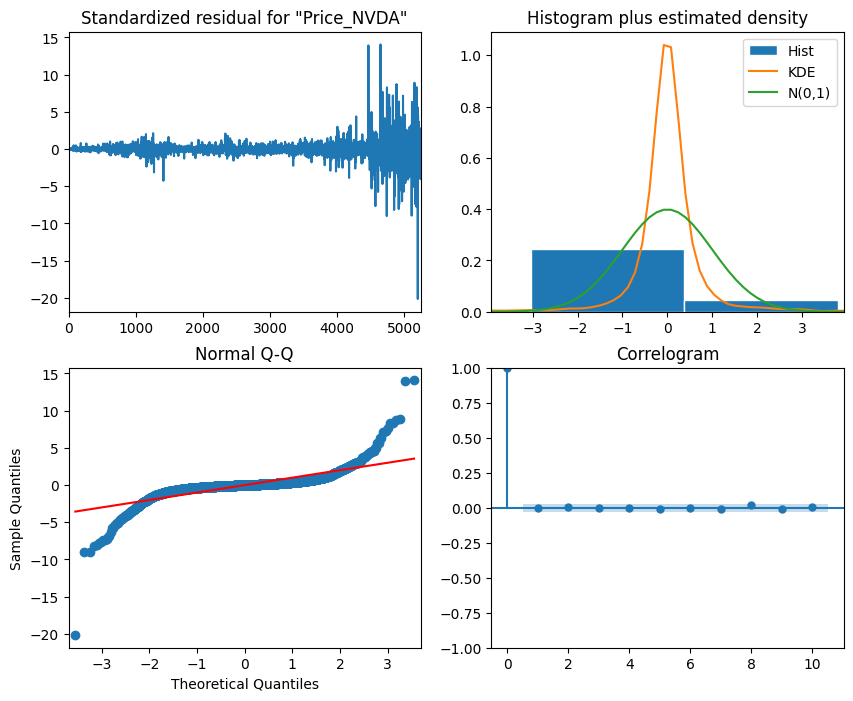

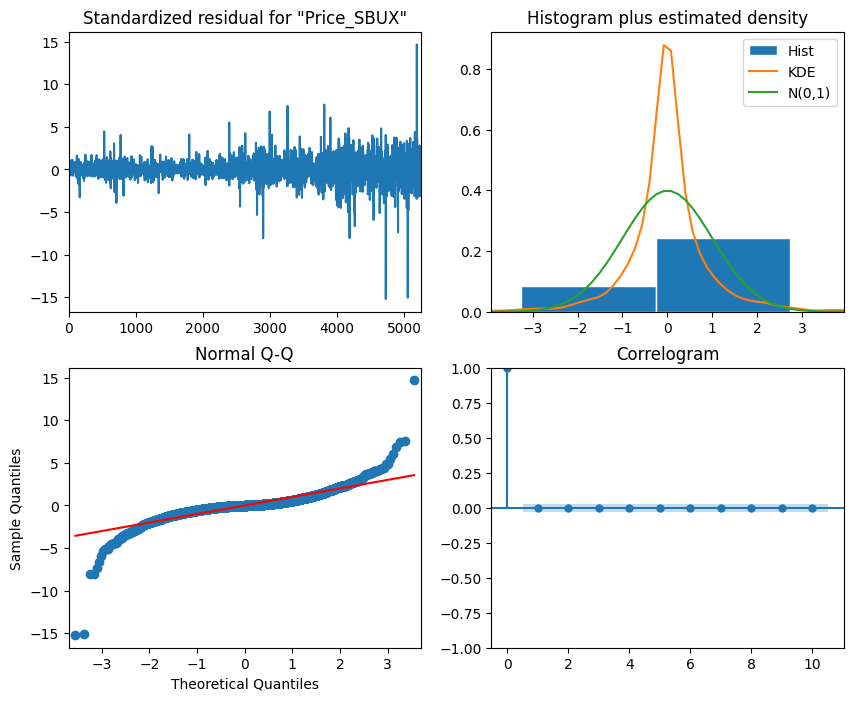

In [ ]:
for i in range(7):
    best_model_fit.plot_diagnostics(figsize=(10, 8), variable=i)

plt.show()

In [ ]:
print(end-start)

4975.649396181107


In [ ]:
TRAIN_LEN = len(diff_data)
HORIZON = len(scaled_test)
WINDOW = HORIZON

In [ ]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> pd.DataFrame:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    predictions_dict = {col: [] for col in df.columns}

    for i in range(train_len, total_len, window):
        model = VARMAX(df[:i], order=(14,0))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)

        for col in df.columns:
            oos_pred = predictions.predicted_mean.iloc[-window:][col]
            predictions_dict[col].extend(oos_pred)

    predictions_df = pd.DataFrame(predictions_dict)
    return predictions_df

In [ ]:
pred_VAR = rolling_forecast(diff_data, TRAIN_LEN, HORIZON, WINDOW)
last_value = VAR_train.iloc[-1, :].values
pred_VAR = pred_VAR.cumsum(axis=0) + last_value

In [ ]:
pred_VAR.head()

Price_AAPL  Price_AMZN  Price_BA  Price_GOOGL  Price_NKE  Price_NVDA  \
0    0.362006    0.470233  0.619057     0.608029   0.688726   -0.084803   
1    0.374971    0.486030  0.641613     0.611740   0.687134   -0.075033   
2    0.360985    0.472641  0.633755     0.602487   0.680124   -0.088690   
3    0.366352    0.470999  0.638105     0.604638   0.691517   -0.090457   
4    0.367051    0.472674  0.635451     0.602519   0.693336   -0.087065   

   Price_SBUX  
0    0.867797  
1    0.869716  
2    0.870648  
3    0.869920  
4    0.865210

In [ ]:
VAR_test.head()

Price_AAPL  Price_AMZN  Price_BA  Price_GOOGL  Price_NKE  Price_NVDA  \
0    0.353305    0.466048  0.615363     0.610602   0.701089   -0.091941   
1    0.354871    0.502960  0.622582     0.626337   0.698993   -0.072885   
2    0.218015    0.464369  0.551441     0.579050   0.664675   -0.130543   
3    0.270826    0.538978  0.640602     0.664202   0.714449   -0.073095   
4    0.270826    0.538978  0.640602     0.664202   0.714449   -0.073095   

   Price_SBUX  
0    0.867352  
1    0.864896  
2    0.779228  
3    0.841867  
4    0.841867

### Model Evaluation
#### Scaled data

In [ ]:
for i in range(7):
    print(f'MSE for {VAR_test.columns[i]}: {mean_squared_error(VAR_test.iloc[:, i], pred_VAR.iloc[:, i])}')
    
print(f'MSE total: {mean_squared_error(VAR_test, pred_VAR)}')

MSE for Price_AAPL: 0.4318493382842644
MSE for Price_AMZN: 0.07564527242864695
MSE for Price_BA: 0.11472285294544483
MSE for Price_GOOGL: 0.07917524505106446
MSE for Price_NKE: 0.13246557606131615
MSE for Price_NVDA: 0.1961230654032497
MSE for Price_SBUX: 0.300370386473322
MSE total: 0.19005024809247267


In [ ]:
for i in range(7):
    print(f'RMSE for {VAR_test.columns[i]}: {mean_squared_error(VAR_test.iloc[:, i], pred_VAR.iloc[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(VAR_test, pred_VAR, squared=False)}')

RMSE for Price_AAPL: 0.6571524467612249
RMSE for Price_AMZN: 0.27503685649135634
RMSE for Price_BA: 0.3387076216229048
RMSE for Price_GOOGL: 0.2813809607117448
RMSE for Price_NKE: 0.363958206476123
RMSE for Price_NVDA: 0.4428578388187904
RMSE for Price_SBUX: 0.5480605682525628
RMSE total: 0.41530778559067244


In [ ]:
for i in range(7):
    print(f'MAE for {VAR_test.columns[i]}: {mean_absolute_error(VAR_test.iloc[:, i], pred_VAR.iloc[:, i])}')
    
print(f'MAE total: {mean_absolute_error(VAR_test, pred_VAR)}')

MAE for Price_AAPL: 0.5339885421973752
MAE for Price_AMZN: 0.2541238011200103
MAE for Price_BA: 0.2304497723663873
MAE for Price_GOOGL: 0.23118840487206352
MAE for Price_NKE: 0.32676842297896996
MAE for Price_NVDA: 0.3578970661425766
MAE for Price_SBUX: 0.4838385270505836
MAE total: 0.34546493381828086


In [ ]:
for i in range(7):
    print(f'R2 for {VAR_test.columns[i]}: {r2_score(VAR_test.iloc[:, i], pred_VAR.iloc[:, i])}')
    
print(f'R2 total: {r2_score(VAR_test, pred_VAR)}')

R2 for Price_AAPL: -1.4446183600527958
R2 for Price_AMZN: -4.36436314101396
R2 for Price_BA: -0.22000025434694215
R2 for Price_GOOGL: -1.1942551250394309
R2 for Price_NKE: -2.226439408915645
R2 for Price_NVDA: -1.5185879979230594
R2 for Price_SBUX: -2.353719576065699
R2 total: -1.9031405519082187


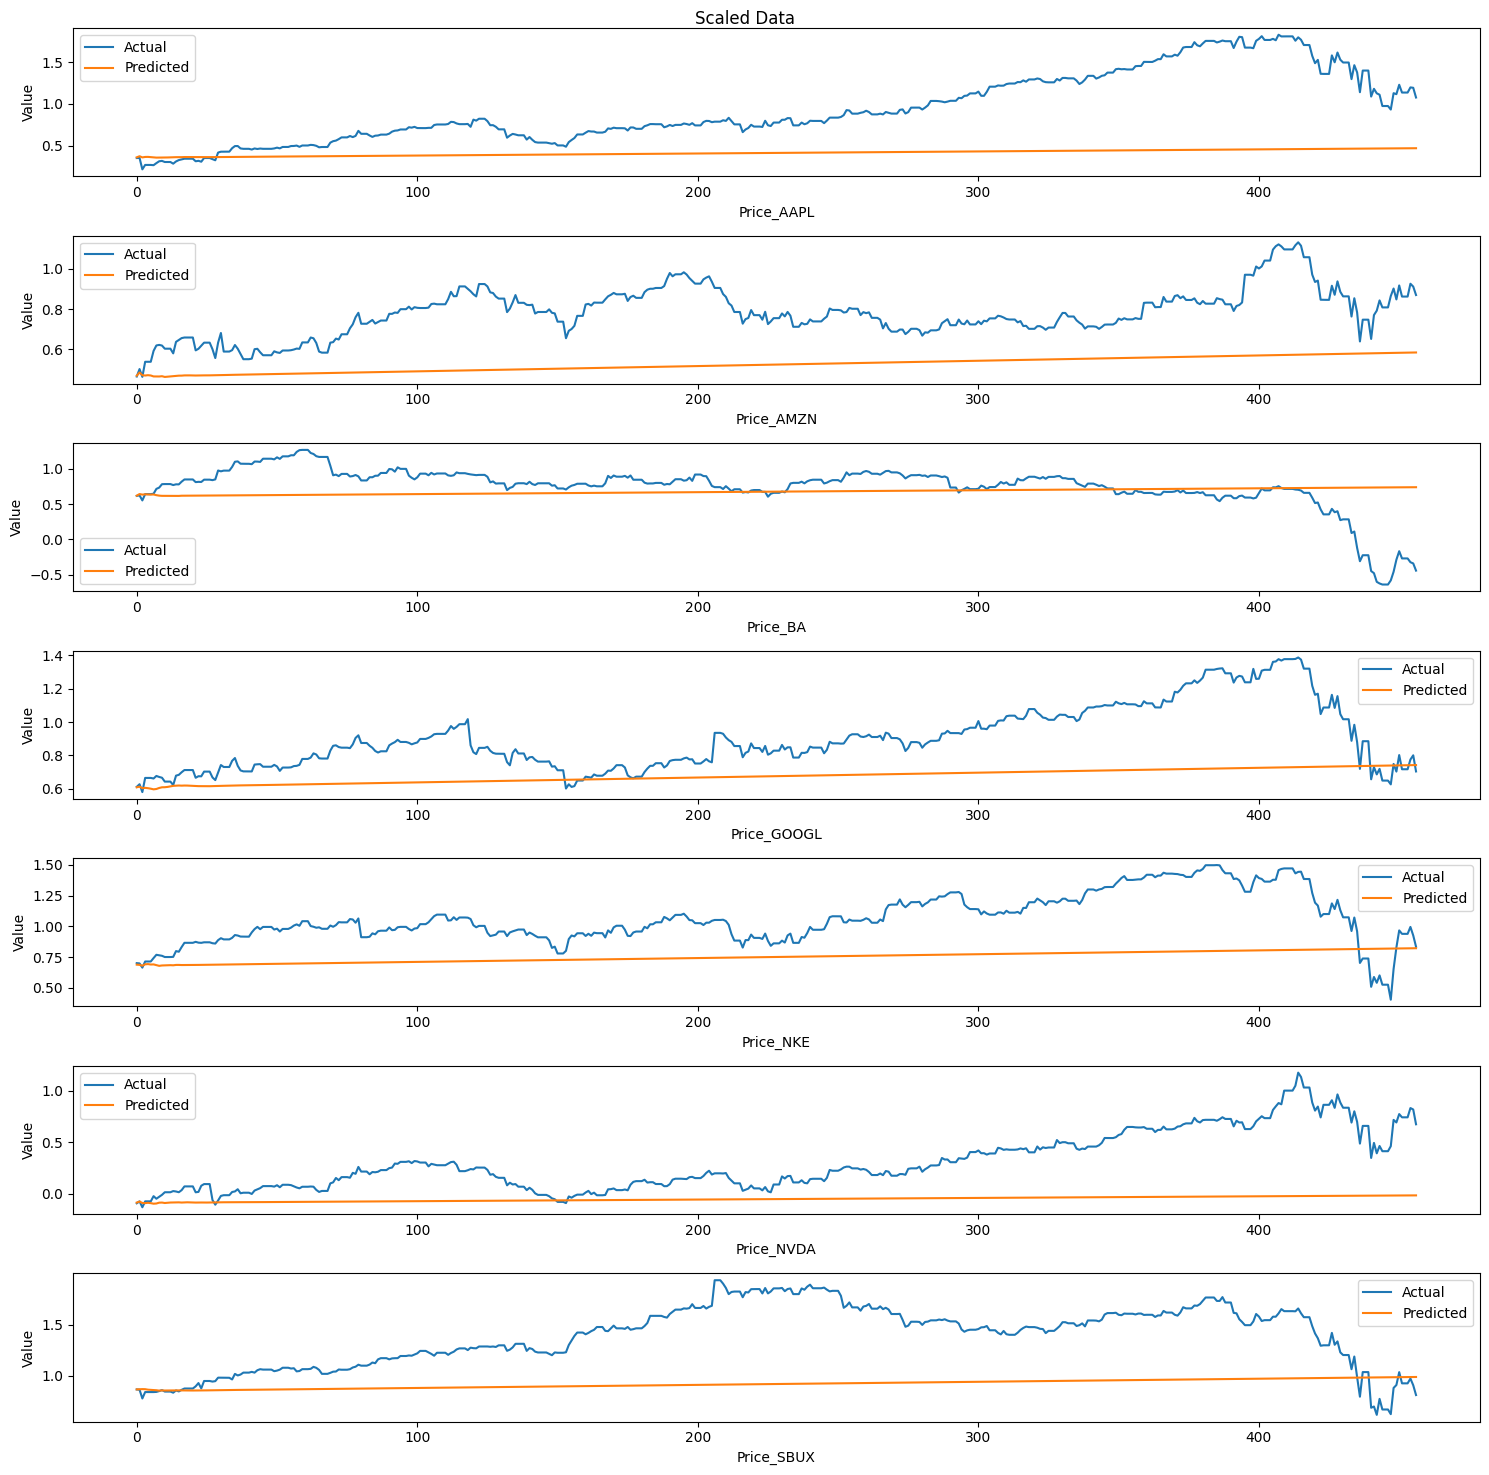

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(VAR_test.iloc[:, i], label='Actual')
    plt.plot(pred_VAR.iloc[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{VAR_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

#### Unscaled data

In [ ]:
def inverse(dataset):
    temp = dataset.copy()
    for index, i in enumerate(dataset.columns):
        scaler = scalers['scaler_' + i]
        temp.iloc[:, index] = scaler.inverse_transform(np.reshape(dataset.iloc[:, index], (-1, 1))).flatten()
    return temp

In [ ]:
inverse_VAR = inverse(pred_VAR)
inverse_VAR.head()

Price_AAPL   Price_AMZN    Price_BA  Price_GOOGL  Price_NKE  Price_NVDA  \
0  158.740066  1506.183128  323.170249  1043.370683  73.668108  134.518773   
1  160.230264  1522.086180  327.263431  1045.662804  73.607324  135.913370   
2  158.622736  1508.607142  325.837588  1039.947264  73.339750  133.963988   
3  159.239672  1506.953928  326.626901  1041.276005  73.774623  133.711769   
4  159.319942  1508.640765  326.145277  1039.966867  73.844064  134.195902   

   Price_SBUX  
0   64.414465  
1   64.476971  
2   64.507340  
3   64.483622  
4   64.330218

In [ ]:
temp_df = test_df.drop(columns=['Price_INTC', 'Price_MSFT', 'Price_DIS'])
temp_df.head()

Price_AAPL   Price_AMZN    Price_BA  Price_GOOGL  Price_NKE  Price_NVDA  \
0  157.740005  1501.969971  322.500000  1044.959961  74.139999  133.500000   
1  157.919998  1539.130005  323.809998  1054.680054  74.059998  136.220001   
2  142.190002  1500.280029  310.899994  1025.469971  72.750000  127.989998   
3  148.259995  1575.390015  327.079987  1078.069946  74.650002  136.190002   
4  148.259995  1575.390015  327.079987  1078.069946  74.650002  136.190002   

   Price_SBUX  
0   64.400002  
1   64.320000  
2   61.529999  
3   63.570000  
4   63.570000

In [ ]:
for i in range(7):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(temp_df.iloc[:, i], inverse_VAR.iloc[:, i])}')
    
print(f'MSE total: {mean_squared_error(temp_df, inverse_VAR)}')

MSE for Price_AAPL: 5705.072628303793
MSE for Price_AMZN: 76665.36167648625
MSE for Price_BA: 3777.9794069821105
MSE for Price_DIS: 30211.77344365917
MSE for Price_GOOGL: 193.01455105414033
MSE for Price_INTC: 3995.7630695836688
MSE for Price_MSFT: 318.58547591380545
MSE total: 17266.79289314042


In [ ]:
for i in range(7):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(temp_df.iloc[:, i], inverse_VAR.iloc[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(temp_df, inverse_VAR, squared=False)}')

RMSE for Price_AAPL: 75.53193118346566
RMSE for Price_AMZN: 276.885105551899
RMSE for Price_BA: 61.465269925235916
RMSE for Price_DIS: 173.81534294664314
RMSE for Price_GOOGL: 13.892967683477146
RMSE for Price_INTC: 63.212048452677664
RMSE for Price_MSFT: 17.848962880621535
RMSE total: 97.52166123200288


In [ ]:
for i in range(7):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(temp_df.iloc[:, i], inverse_VAR.iloc[:, i])}')
    
print(f'MAE total: {mean_absolute_error(temp_df, inverse_VAR)}')

MAE for Price_AAPL: 61.375691471276355
MAE for Price_AMZN: 255.83151434315184
MAE for Price_BA: 41.81971871444682
MAE for Price_DIS: 142.81027321991024
MAE for Price_GOOGL: 12.473363863346345
MAE for Price_INTC: 51.08503159031319
MAE for Price_MSFT: 15.757411515802994
MAE total: 83.02185781689255


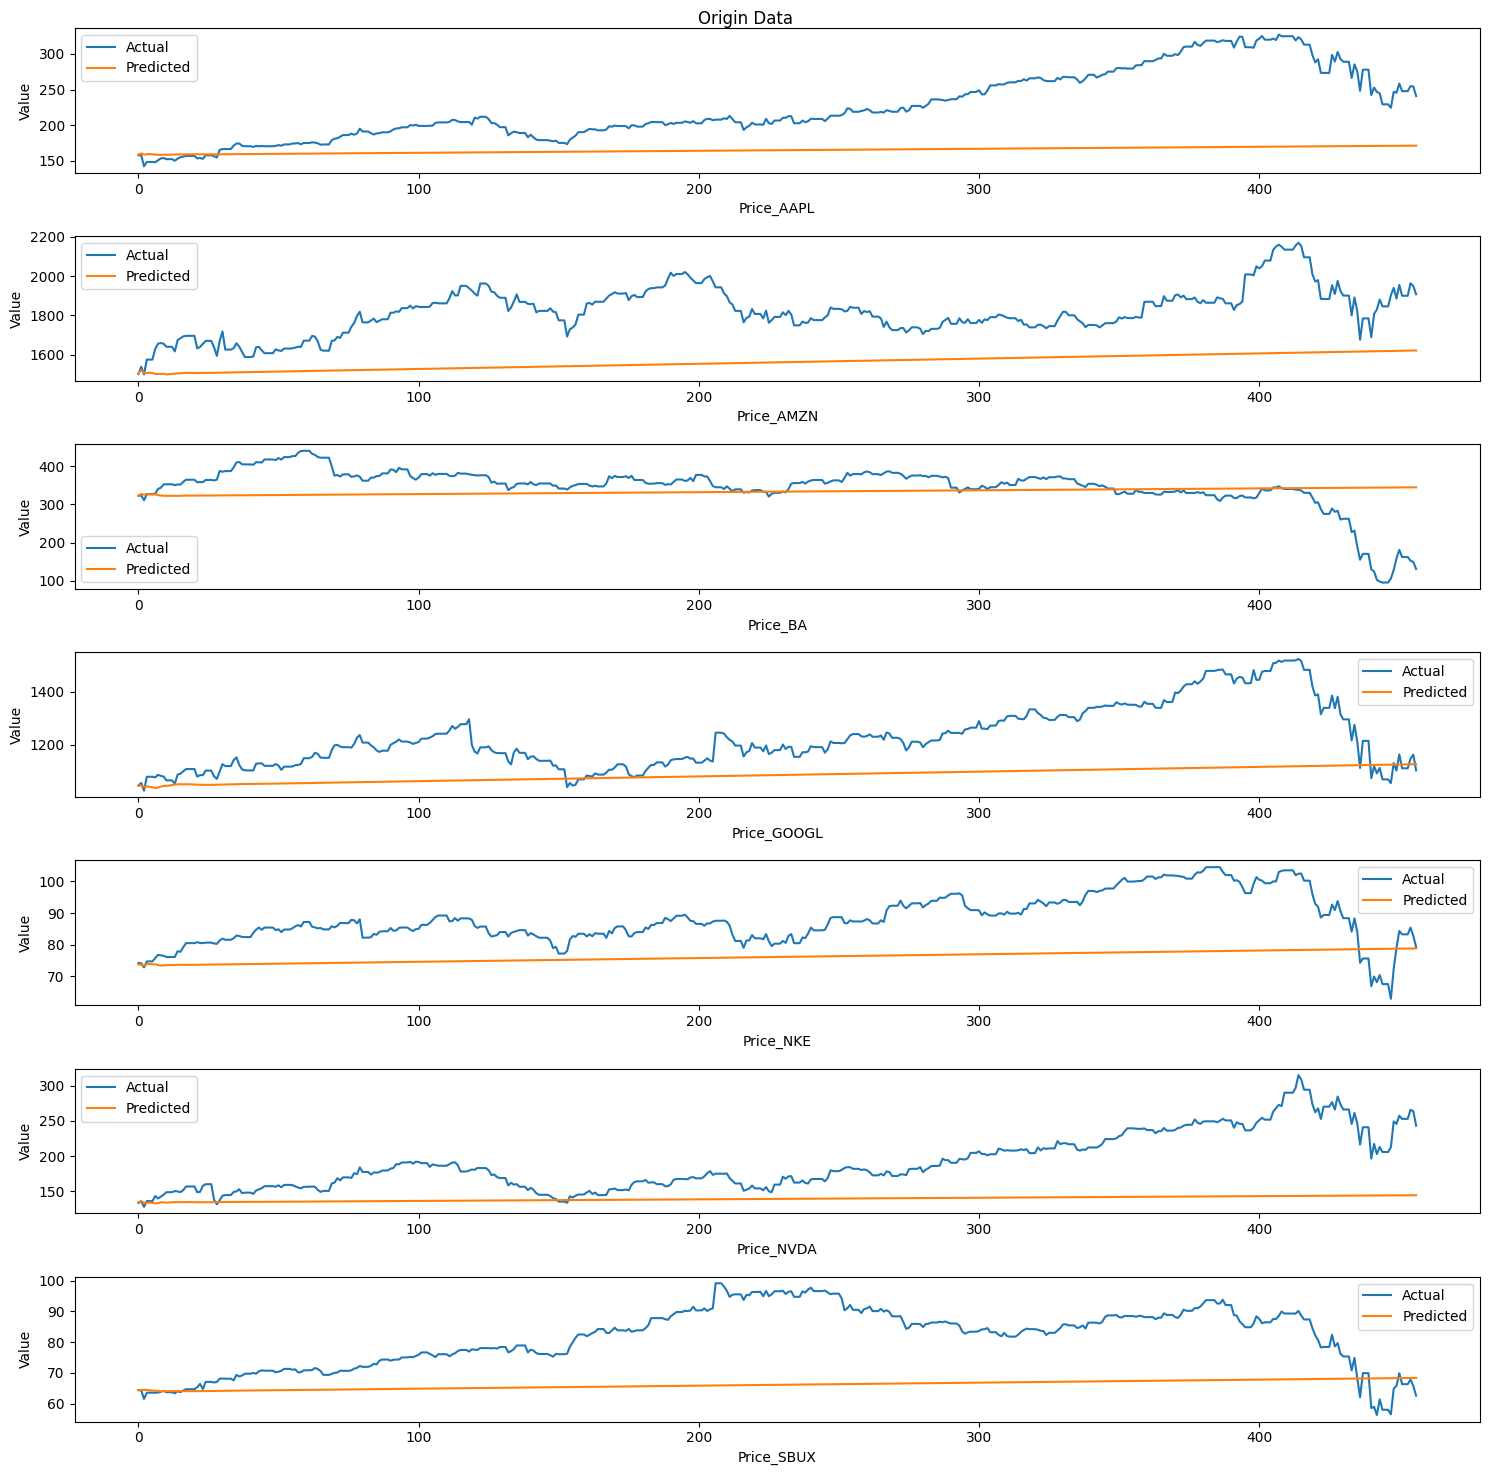

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(temp_df.iloc[:, i], label='Actual')
    plt.plot(inverse_VAR.iloc[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{temp_df.columns[i]}')
    plt.ylabel('Value')
    plt.legend()

plt.suptitle('Origin Data')
plt.tight_layout()
plt.show()

# CNN
### Split data

In [ ]:
def to_sequences_multivariate(dataset, p):
    x = []
    y = []
    for i in range(p, len(dataset)):
        x.append(dataset.iloc[i - p:i, 0:dataset.shape[1]])
        y.append(dataset.iloc[i:i + 1, 0:dataset.shape[1]])
    x = np.array(x)
    y = np.array(y)
    return x,y.reshape(y.shape[0], y.shape[2])

In [ ]:
def difference(dataset, order=1):
    return dataset.diff(periods=order).dropna()

VAR_train_diff = difference(VAR_train, order=1)
VAR_test_diff = difference(VAR_test, order=1)

In [ ]:
p = 14

trainX, trainY = to_sequences_multivariate(VAR_train_diff, p)
testX, testY = to_sequences_multivariate(VAR_test_diff, p)

### Find optimal parameters

In [ ]:
def build_cnn_model(filters, kernel_size, n_past, n_features):
    with strategy.scope():
        inputs = layers.Input(shape=(n_past, n_features), name='input_layer') # (batch_size, n_past, n_features)
        
        # Reshape input to (samples, n_past, n_features, 1) to work with Conv2D
        x = layers.Reshape((n_past, n_features, 1), name='reshape_layer')(inputs)
        
        # Lớp 1: Conv2D với kernel_size (7, n_features) và padding='same'
        conv1 = layers.Conv2D(
            filters=filters,  # Số lượng filter
            kernel_size=(kernel_size, n_features),  # Kích thước kernel (7, n_features)
            activation='relu',
            padding='same', 
            name='conv1_layer')(x) # (batch_size, n_past, n_features, filters)
        
        # Batch Normalization sau lớp Conv1
        conv1 = layers.BatchNormalization(name='conv1_bn')(conv1)
        
        # MaxPooling sau lớp Conv1 với pool_size (2, 2)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool1')(conv1)
        
        # Lớp 2: Conv2D với kernel_size (3, 3) và padding='same'
        conv2 = layers.Conv2D(
            filters=filters,  # Số lượng filter
            kernel_size=(3, 3),  # Kích thước kernel (3, 3)
            activation='relu',
            padding='same', 
            name='conv2_layer')(pool1)
        
        # Batch Normalization sau lớp Conv2
        conv2 = layers.BatchNormalization(name='conv2_bn')(conv2)
        
        # MaxPooling sau lớp Conv2 với pool_size (2, 2)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool2')(conv2)
        
        # Flatten để đưa đầu ra vào lớp Dense
        flatten = layers.Flatten(name='flatten')(pool2)
        
        # Output layer: dự đoán cho mỗi đặc trưng (n_features)
        outputs = layers.Dense(n_features, name='output')(flatten)
        
        # Tạo và biên dịch mô hình
        model_CNN = tf.keras.models.Model(inputs, outputs)
        model_CNN.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model_CNN

In [ ]:
print('Starting find optimal parameters for CNN model')

# Tập giá trị tham số cần quét
param_grid = {
    'batch_size': [16, 32, 64],
    'filters': [16, 32, 64],
    'kernel_size': [5, 7, 10]
}

# Lưu kết quả
results = []
grid = ParameterGrid(param_grid)

# Lặp qua từng tổ hợp tham số
for params in grid:
    print(f"Testing with parameters: {params}")
    model = build_cnn_model(params['filters'], params['kernel_size'], p, 7)
    
    # Huấn luyện mô hình
    history = model.fit(
        trainX, trainY,
        batch_size=params['batch_size'],
        epochs=5,
        verbose=0,
        validation_split=0.2
    )
    
    # Lưu kết quả
    loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    results.append({
        'batch_size': params['batch_size'],
        'filters': params['filters'],
        'kernel_size': params['kernel_size'],
        'loss': loss,
        'val_loss': val_loss
    })

# Sắp xếp kết quả theo val_loss
results = sorted(results, key=lambda x: x['val_loss'])

# Hiển thị kết quả tốt nhất
print("Best parameters:", results[0])
best_para_CNN = results[0]

Starting find optimal parameters for CNN model
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 5}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 7}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 10}
Testing with parameters: {'batch_size': 16, 'filters': 32, 'kernel_size': 5}
Testing with parameters: {'batch_size': 16, 'filters': 32, 'kernel_size': 7}
Testing with parameters: {'batch_size': 16, 'filters': 32, 'kernel_size': 10}
Testing with parameters: {'batch_size': 16, 'filters': 64, 'kernel_size': 5}
Testing with parameters: {'batch_size': 16, 'filters': 64, 'kernel_size': 7}
Testing with parameters: {'batch_size': 16, 'filters': 64, 'kernel_size': 10}
Testing with parameters: {'batch_size': 32, 'filters': 16, 'kernel_size': 5}
Testing with parameters: {'batch_size': 32, 'filters': 16, 'kernel_size': 7}
Testing with parameters: {'batch_size': 32, 'filters': 16, 'kernel_size': 10}
Testing with parameters: 

### Model initialization

In [ ]:
class CNN:
    def __init__(self, n_past, n_features, best_para_CNN, strategy):
        self.n_past = n_past
        self.n_features = n_features
        self.best_para_CNN = best_para_CNN
        self.strategy = strategy

        # Build the CNN model using the best parameters
        with self.strategy.scope():
            self.model_CNN = self._build_model()

    def _build_model(self):
        filters = self.best_para_CNN['filters']
        kernel_size = self.best_para_CNN['kernel_size']
        
        inputs = layers.Input(shape=(self.n_past, self.n_features), name='input_layer')
        x = layers.Reshape((self.n_past, self.n_features, 1), name='reshape_layer')(inputs)

        conv1 = layers.Conv2D(
            filters=filters,
            kernel_size=(kernel_size, self.n_features),
            activation='relu',
            padding='same',
            name='conv1_layer')(x)
        conv1 = layers.BatchNormalization(name='conv1_bn')(conv1)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool1')(conv1)

        conv2 = layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
            name='conv2_layer')(pool1)
        conv2 = layers.BatchNormalization(name='conv2_bn')(conv2)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool2')(conv2)

        flatten = layers.Flatten(name='flatten')(pool2)
        outputs = layers.Dense(self.n_features, name='output')(flatten)

        model_CNN = tf.keras.models.Model(inputs, outputs)
        model_CNN.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model_CNN

    def train(self, trainX, trainY):
        print('Start training CNN')

        reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        start = time.time()
        with self.strategy.scope():
            history_CNN = self.model_CNN.fit(
                trainX,
                trainY,
                validation_split=0.2,
                epochs=100,
                batch_size=self.best_para_CNN['batch_size'],
                verbose=0,
                callbacks=[reduce_lr, early_stop]
            )
        end = time.time()
        
        print('Complete training model')
        print(f'Training time: {end - start:.2f} seconds')
        return history_CNN

    def summary(self):
        self.model_CNN.summary()

    def plot_loss(self, history_CNN):
        loss = history_CNN.history['loss']
        val_loss = history_CNN.history['val_loss']
        epochs = range(1, len(loss) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss, 'bo-', label='Training loss')
        plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def predict(self, testX):
        # Phương thức dự đoán
        return self.model_CNN.predict(testX)

In [ ]:
model_CNN = CNN(p, 7, best_para_CNN, strategy)
model_CNN.summary()

Model: "functional_443"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (Reshape)         │ (None, 14, 7, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_layer (Conv2D)            │ (None, 14, 7, 64)      │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 14, 7, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_layer (Conv2D)            │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_bn (BatchNormalization)   │ (None, 7, 4, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 4, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,231 (172.78 KB)

 Trainable params: 43,975 (171.78 KB)

 Non-trainable params: 256 (1.00 KB)

### Model training

In [ ]:
history_CNN = model_CNN.train(trainX, trainY)

Start training CNN
Complete training model
Training time: 7.19 seconds


In [ ]:
pred_CNN = model_CNN.predict(testX)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
def reverse_difference(original_data, differenced_data, order=1):
    reversed_data = []
    last_original_value = original_data.iloc[-len(differenced_data) - order:-order].values
    for i in range(len(differenced_data)):
        restored = differenced_data[i] + last_original_value[i]
        reversed_data.append(restored)
    return np.array(reversed_data)

In [ ]:
last_test_values = VAR_test.iloc[p:]
testY_original = reverse_difference(last_test_values, testY)
pred_CNN_original = reverse_difference(last_test_values, pred_CNN)

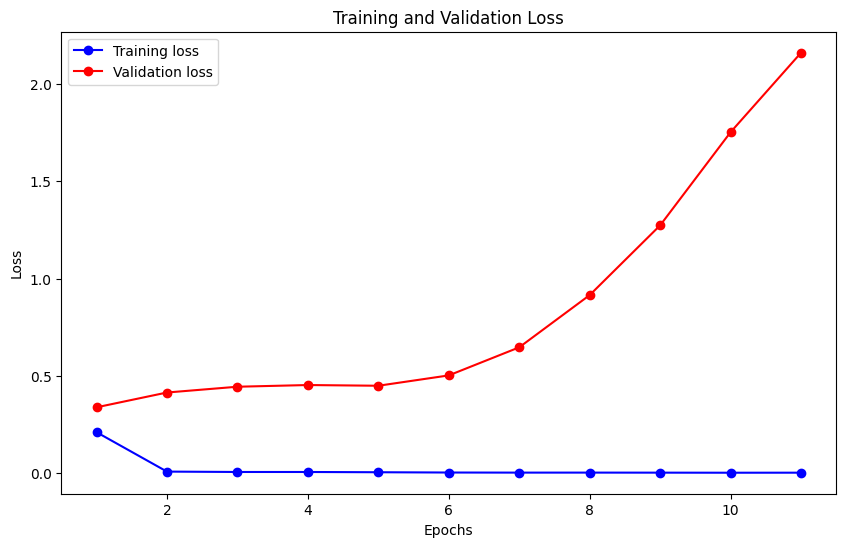

In [ ]:
model_CNN.plot_loss(history_CNN)

### Model Score
#### Scaled data

In [ ]:
for i in range(7):
    print(f'MSE for {VAR_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_CNN_original[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY_original, pred_CNN_original)}')

MSE for Price_AAPL: 0.4732762338054163
MSE for Price_AMZN: 0.20470565855041647
MSE for Price_BA: 0.09861377139211387
MSE for Price_GOOGL: 0.2570572194853489
MSE for Price_NKE: 0.14545227010269313
MSE for Price_NVDA: 0.1612162555858809
MSE for Price_SBUX: 0.2243141924942589
MSE total: 0.22351937163087546


In [ ]:
for i in range(7):
    print(f'RMSE for {VAR_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_CNN_original[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(testY_original, pred_CNN_original, squared=False)}')

RMSE for Price_AAPL: 0.68795074954928
RMSE for Price_AMZN: 0.45244409439224254
RMSE for Price_BA: 0.31402829712004277
RMSE for Price_GOOGL: 0.5070081059365312
RMSE for Price_NKE: 0.3813820526751267
RMSE for Price_NVDA: 0.40151744119761584
RMSE for Price_SBUX: 0.4736181927399526
RMSE total: 0.4597069905158274


In [ ]:
for i in range(7):
    print(f'MAE for {VAR_test.columns[i]}: {mean_absolute_error(testY_original[:, i], pred_CNN_original[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY_original, pred_CNN_original)}')

MAE for Price_AAPL: 0.5119768502684474
MAE for Price_AMZN: 0.38038916214895324
MAE for Price_BA: 0.2024021547454301
MAE for Price_GOOGL: 0.4391946719070914
MAE for Price_NKE: 0.2785812373173638
MAE for Price_NVDA: 0.35452529460163495
MAE for Price_SBUX: 0.4108207692493525
MAE total: 0.3682700200340393


In [ ]:
for i in range(7):
    print(f'R2 for {VAR_test.columns[i]}: {r2_score(testY_original[:, i], pred_CNN_original[:, i])}')
    
print(f'R2 total: {r2_score(testY_original, pred_CNN_original)}')

R2 for Price_AAPL: -0.8188927111098345
R2 for Price_AMZN: -0.7507751942247614
R2 for Price_BA: 0.07540308333528734
R2 for Price_GOOGL: -0.1984508762254642
R2 for Price_NKE: -0.12561088597342351
R2 for Price_NVDA: 0.09705176387500847
R2 for Price_SBUX: -0.17026026541710015
R2 total: -0.2702192979628972


#### Unscaled data

In [ ]:
unscaled_CNN = unscale(pred_CNN_original)
originY = unscale(testY_original)

In [ ]:
for i in range(7):
    print(f'MSE for {VAR_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_CNN[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_CNN)}')

MSE for Price_AAPL: 216.53907011414475
MSE for Price_AMZN: 93.6594043009642
MSE for Price_BA: 45.11896458650142
MSE for Price_GOOGL: 117.61192306691781
MSE for Price_NKE: 66.54907769913336
MSE for Price_NVDA: 73.76160733540227
MSE for Price_SBUX: 102.63093523151691
MSE total: 102.2672831906544


In [ ]:
for i in range(7):
    print(f'RMSE for {VAR_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_CNN[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(originY, unscaled_CNN, squared=False)}')

RMSE for Price_AAPL: 14.715266566193925
RMSE for Price_AMZN: 9.67777889295701
RMSE for Price_BA: 6.717065176585785
RMSE for Price_GOOGL: 10.844903091633315
RMSE for Price_NKE: 8.157761806962334
RMSE for Price_NVDA: 8.588457797265017
RMSE for Price_SBUX: 10.130692732065114
RMSE total: 9.833132294808928


In [ ]:
for i in range(7):
    print(f'MAE for {VAR_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_CNN[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_CNN)}')

MAE for Price_AAPL: 10.95118504973513
MAE for Price_AMZN: 8.136523889537523
MAE for Price_BA: 4.329381957174639
MAE for Price_GOOGL: 9.394373731729202
MAE for Price_NKE: 5.958852473715719
MAE for Price_NVDA: 7.583295737301886
MAE for Price_SBUX: 8.787455883844173
MAE total: 7.877295531862614


### Plot predict data

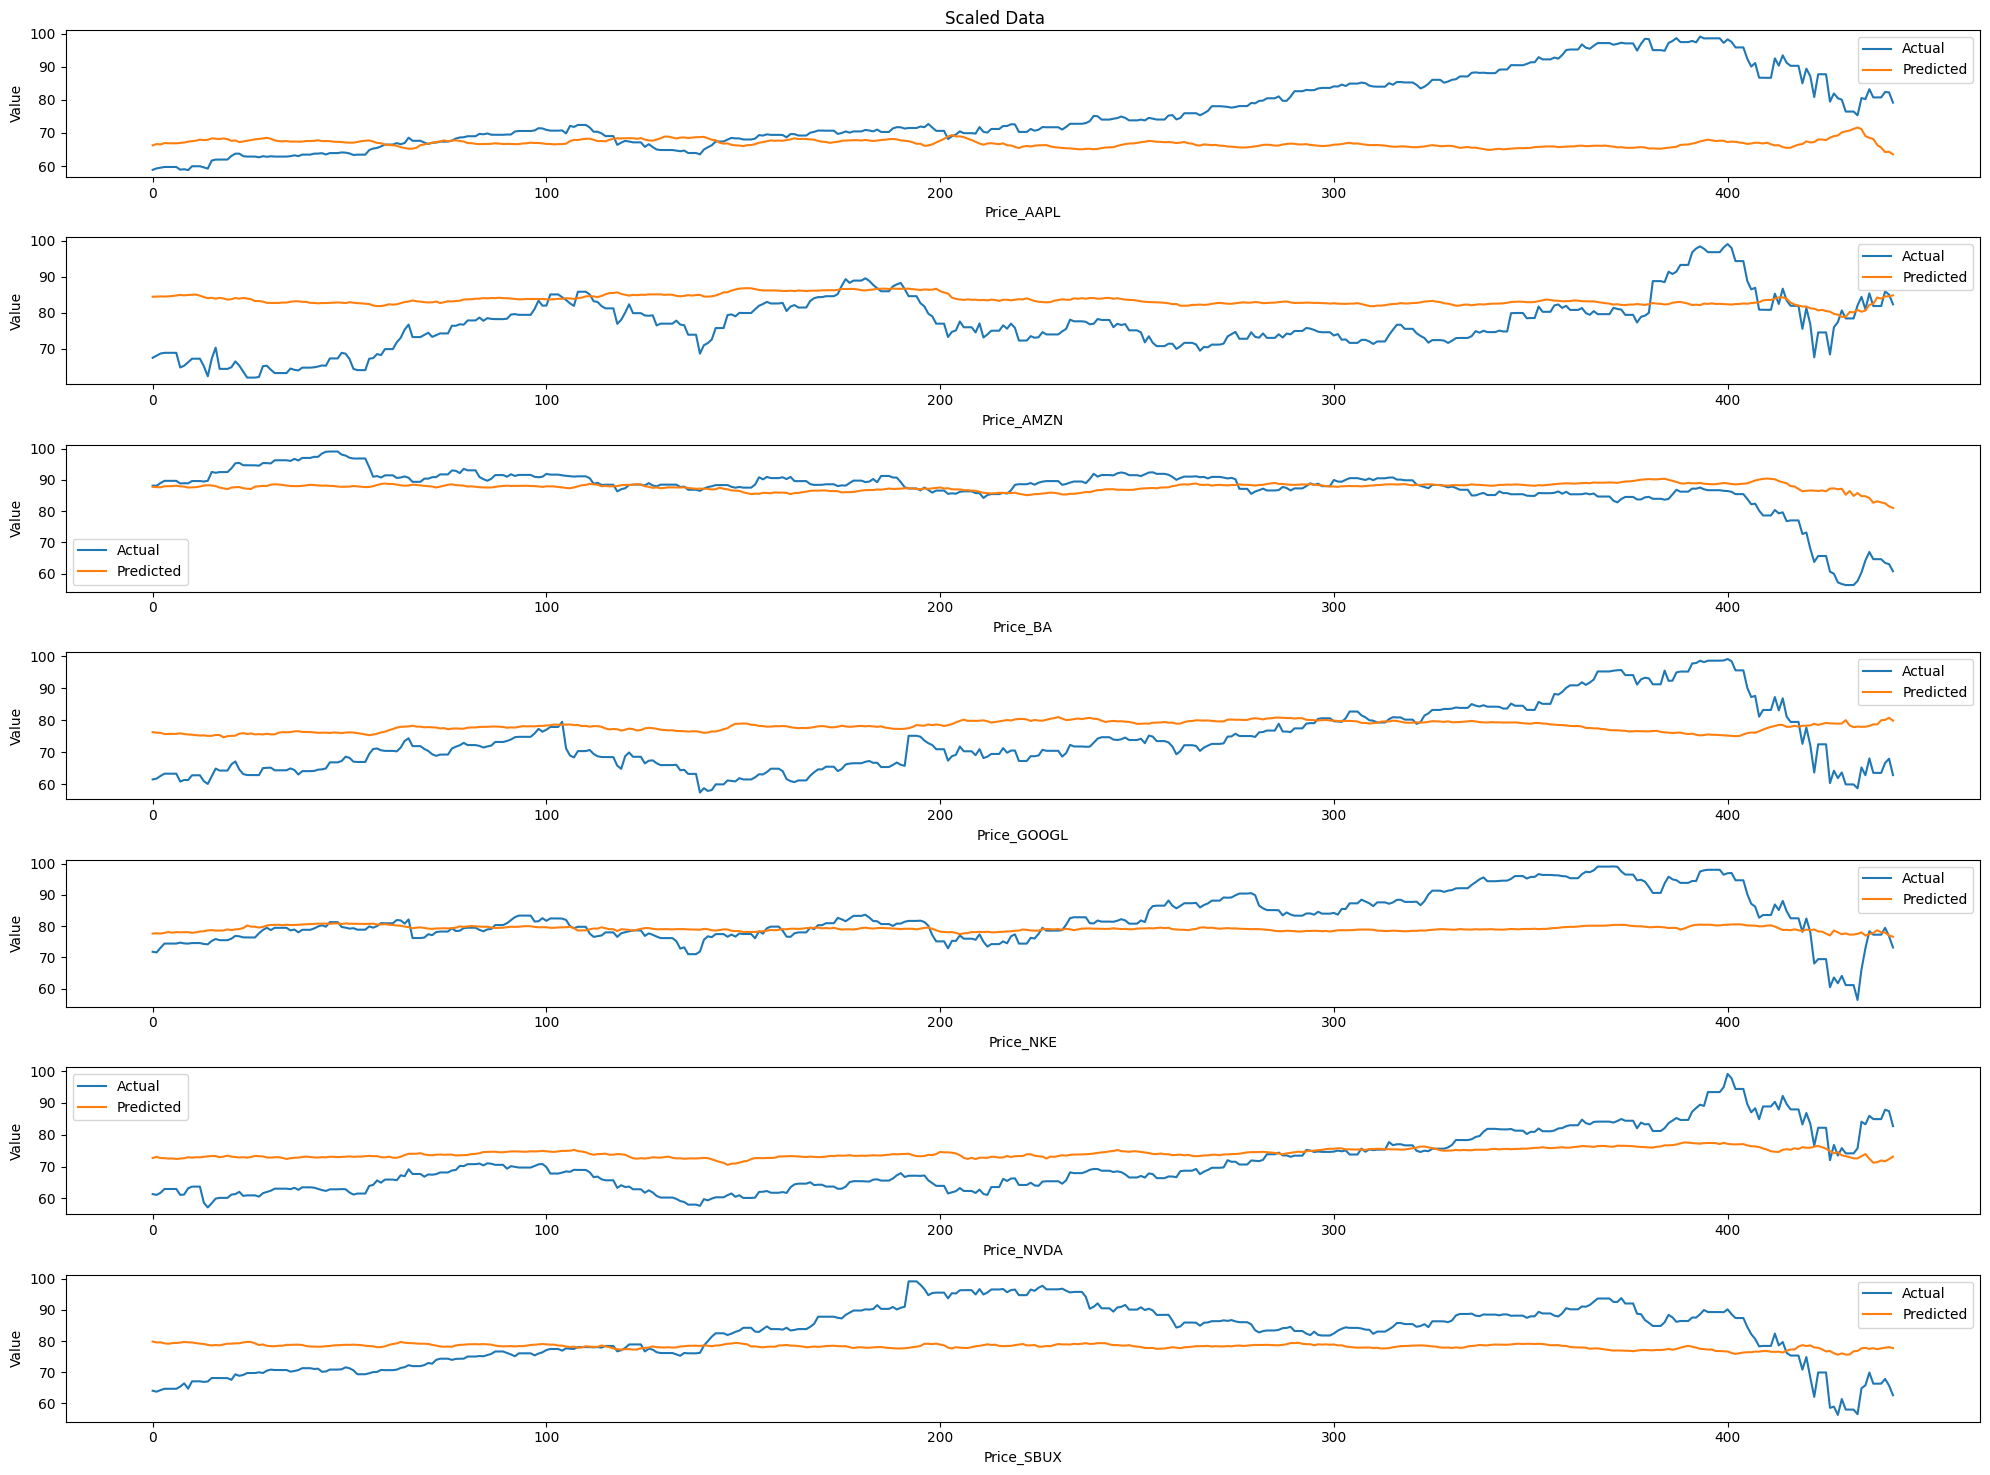

In [ ]:
plt.figure(figsize=(20, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_CNN[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{VAR_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

# LSTM
### Find optimal parameters

In [ ]:
print('Starting find optimal parameters for LSTM model')
def build_lstm_model(n_units, n_past, n_features):
    inputs = tf.keras.layers.Input(shape=(n_past, n_features))
    lstm = tf.keras.layers.LSTM(n_units, return_state=True)
    _, state_h, _ = lstm(inputs)
    outputs = tf.keras.layers.Dense(n_features)(state_h)
    
    model_LSTM = tf.keras.models.Model(inputs, outputs)
    model_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model_LSTM

# Tập giá trị tham số cần quét
param_grid = {
    'batch_size': [16, 32, 64],
    'units': [32, 64, 128]
}

# Lưu tham số và kết quả
results = []
grid = ParameterGrid(param_grid)

# Lặp qua từng tham số
for params in grid:
    print(f"Testing with parameters: {params}")
    model = build_lstm_model(params['units'], p, 7)
    
    # Huấn luyện mô hình
    history = model.fit(
        trainX, trainY,
        batch_size=params['batch_size'],
        epochs=5,
        verbose=0
    )
    
    # Lưu lại kết quả
    loss = history.history['loss'][-1]
    mae = history.history['mae'][-1]
    results.append({
        'batch_size': params['batch_size'],
        'units': params['units'],
        'loss': loss,
        'mae': mae
    })

# Sắp xếp kết quả theo loss
results = sorted(results, key=lambda x: x['loss'])

# Hiển thị kết quả tốt nhất
print("Best parameters:", results[0])
best_para_LSTM = results[0]

Starting find optimal parameters for LSTM model
Testing with parameters: {'batch_size': 16, 'units': 32}
Testing with parameters: {'batch_size': 16, 'units': 64}
Testing with parameters: {'batch_size': 16, 'units': 128}
Testing with parameters: {'batch_size': 32, 'units': 32}
Testing with parameters: {'batch_size': 32, 'units': 64}
Testing with parameters: {'batch_size': 32, 'units': 128}
Testing with parameters: {'batch_size': 64, 'units': 32}
Testing with parameters: {'batch_size': 64, 'units': 64}
Testing with parameters: {'batch_size': 64, 'units': 128}
Best parameters: {'batch_size': 16, 'units': 128, 'loss': 0.000459738977951929, 'mae': 0.014648760668933392}


### Model initialization

In [ ]:
class LSTM_Model:
    def __init__(self, n_past, n_features, best_para_LSTM, strategy):
        self.n_past = n_past
        self.n_features = n_features
        self.best_para_LSTM = best_para_LSTM
        self.strategy = strategy

        # Xây dựng mô hình LSTM
        with self.strategy.scope():
            self.model_LSTM = self._build_model()

    def _build_model(self):
        inputs = tf.keras.layers.Input(shape=(self.n_past, self.n_features))
        
        # Lớp LSTM
        lstm = tf.keras.layers.LSTM(self.best_para_LSTM['units'], return_state=True)
        _, state_h, state_c = lstm(inputs)
        
        # Lớp Dense để đưa ra kết quả dự đoán
        outputs = tf.keras.layers.Dense(self.n_features)(state_h)

        # Tạo mô hình
        model = tf.keras.models.Model(inputs, outputs)
        return model

    def train(self, trainX, trainY):
        print('Start training LSTM')

        reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        with self.strategy.scope():
            self.model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())

        start = time.time()
        history_LSTM = self.model_LSTM.fit(
            trainX,
            trainY,
            epochs=50,
            validation_split=0.2,
            batch_size=self.best_para_LSTM['batch_size'],
            verbose=0,
            callbacks=[reduce_lr, early_stopping]
        )
        end = time.time()
        print('Complete training model')
        print(f'Training time: {end - start:.2f} seconds')
        return history_LSTM

    def summary(self):
        self.model_LSTM.summary()

    def plot_loss(self, history_LSTM):
        loss = history_LSTM.history['loss']
        val_loss = history_LSTM.history['val_loss']
        epochs = range(1, len(loss) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss, 'bo-', label='Training loss')
        plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def predict(self, testX):
        # Phương thức dự đoán
        return self.model_LSTM.predict(testX)

In [ ]:
lstm_model = LSTM_Model(n_past=p, n_features=7, best_para_LSTM=best_para_LSTM, strategy=strategy)
lstm_model.summary()

Model: "functional_463"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 14, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ [(None, 128), (None,   │        69,632 │
│                                 │ 128), (None, 128)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,535 (275.53 KB)

 Trainable params: 70,535 (275.53 KB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [ ]:
history = lstm_model.train(trainX, trainY)

Start training LSTM
Complete training model
Training time: 86.91 seconds


In [ ]:
pred_LSTM = lstm_model.predict(testX)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
last_test_values = scaled_test.iloc[p:]
testY_original = reverse_difference(last_test_values, testY)
pred_LSTM_original = reverse_difference(last_test_values, pred_LSTM)

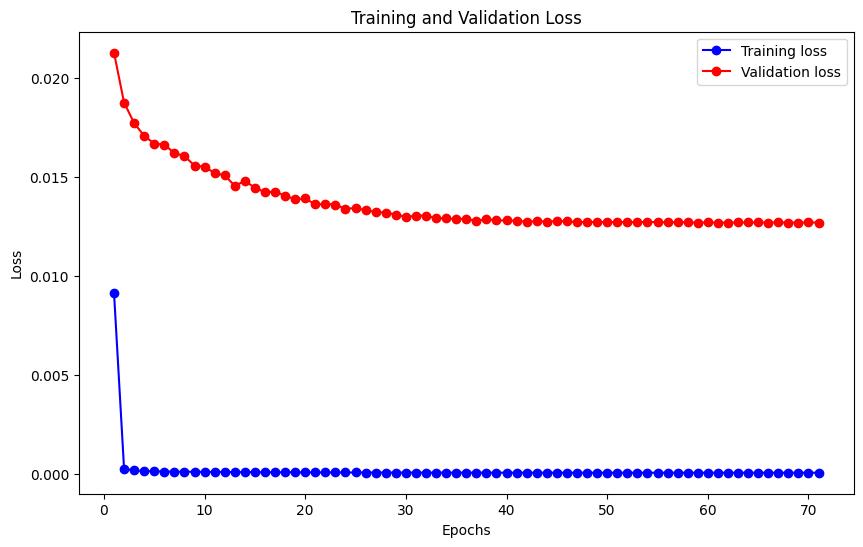

In [ ]:
lstm_model.plot_loss(history)

### Model Score
#### Scaled data

In [ ]:
for i in range(7):
    print(f'MSE for {VAR_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_LSTM_original[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY_original, pred_LSTM_original)}')

MSE for Price_AAPL: 0.014375697125374487
MSE for Price_AMZN: 0.0336932705537722
MSE for Price_BA: 0.02205511302984193
MSE for Price_GOOGL: 0.02963738410996167
MSE for Price_NKE: 0.02540714662418152
MSE for Price_NVDA: 0.037018240019527734
MSE for Price_SBUX: 0.011146147081742707
MSE total: 0.024761856934914617


In [ ]:
for i in range(7):
    print(f'RMSE for {VAR_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_LSTM_original[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(testY_original, pred_LSTM_original, squared=False)}')

RMSE for Price_AAPL: 0.11989869526135173
RMSE for Price_AMZN: 0.18355726777704062
RMSE for Price_BA: 0.1485096395182546
RMSE for Price_GOOGL: 0.1721551164210976
RMSE for Price_NKE: 0.15939619388235568
RMSE for Price_NVDA: 0.19240124744795117
RMSE for Price_SBUX: 0.10557531473665
RMSE total: 0.1544990678635288


In [ ]:
for i in range(7):
    print(f'MAE for {VAR_test.columns[i]}: {mean_absolute_error(testY_original[:, i], pred_LSTM_original[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY_original, pred_LSTM_original)}')

MAE for Price_AAPL: 0.10072695758252362
MAE for Price_AMZN: 0.13570805250656365
MAE for Price_BA: 0.12774306461401475
MAE for Price_GOOGL: 0.1372326685419451
MAE for Price_NKE: 0.13151355260442396
MAE for Price_NVDA: 0.14448109590922062
MAE for Price_SBUX: 0.07217334482293362
MAE total: 0.12136839094023222


In [ ]:
for i in range(7):
    print(f'R2 for {VAR_test.columns[i]}: {r2_score(testY[:, i], pred_LSTM[:, i])}')
    
print(f'R2 total: {r2_score(testY, pred_LSTM)}')

R2 for Price_AAPL: 0.9447513970684259
R2 for Price_AMZN: 0.7118333576337382
R2 for Price_BA: 0.7932125582845894
R2 for Price_GOOGL: 0.8618247368164711
R2 for Price_NKE: 0.8033818186439421
R2 for Price_NVDA: 0.7926663511157028
R2 for Price_SBUX: 0.9418498985854759
R2 total: 0.8356457311640495


#### Unscaled data

In [ ]:
unscaled_LSTM = unscale(pred_LSTM_original)
originY = unscale(testY_original)

In [ ]:
for i in range(7):
    print(f'MSE for {VAR_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_LSTM[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_LSTM)}')

MSE for Price_AAPL: 6.57734361990634
MSE for Price_AMZN: 15.415752573599237
MSE for Price_BA: 10.09092502473281
MSE for Price_GOOGL: 13.560052126606086
MSE for Price_NKE: 11.62458569137198
MSE for Price_NVDA: 16.937030469219298
MSE for Price_SBUX: 5.099720673178352
MSE total: 11.329344311230587


In [ ]:
for i in range(7):
    print(f'RMSE for {VAR_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_LSTM[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(originY, unscaled_LSTM, squared=False)}')

RMSE for Price_AAPL: 2.564633233019166
RMSE for Price_AMZN: 3.926289924801687
RMSE for Price_BA: 3.1766216370120017
RMSE for Price_GOOGL: 3.682397605719144
RMSE for Price_NKE: 3.409484666540089
RMSE for Price_NVDA: 4.11546236396584
RMSE for Price_SBUX: 2.2582561132826258
RMSE total: 3.304735077762936


In [ ]:
for i in range(7):
    print(f'MAE for {VAR_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_LSTM[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_LSTM)}')

MAE for Price_AAPL: 2.1545497367336153
MAE for Price_AMZN: 2.902795419719971
MAE for Price_BA: 2.7324245465848174
MAE for Price_GOOGL: 2.9354064125260213
MAE for Price_NKE: 2.813074927715806
MAE for Price_NVDA: 3.090450394538631
MAE for Price_SBUX: 1.543788040195577
MAE total: 2.5960699254306334


### Plot predict data

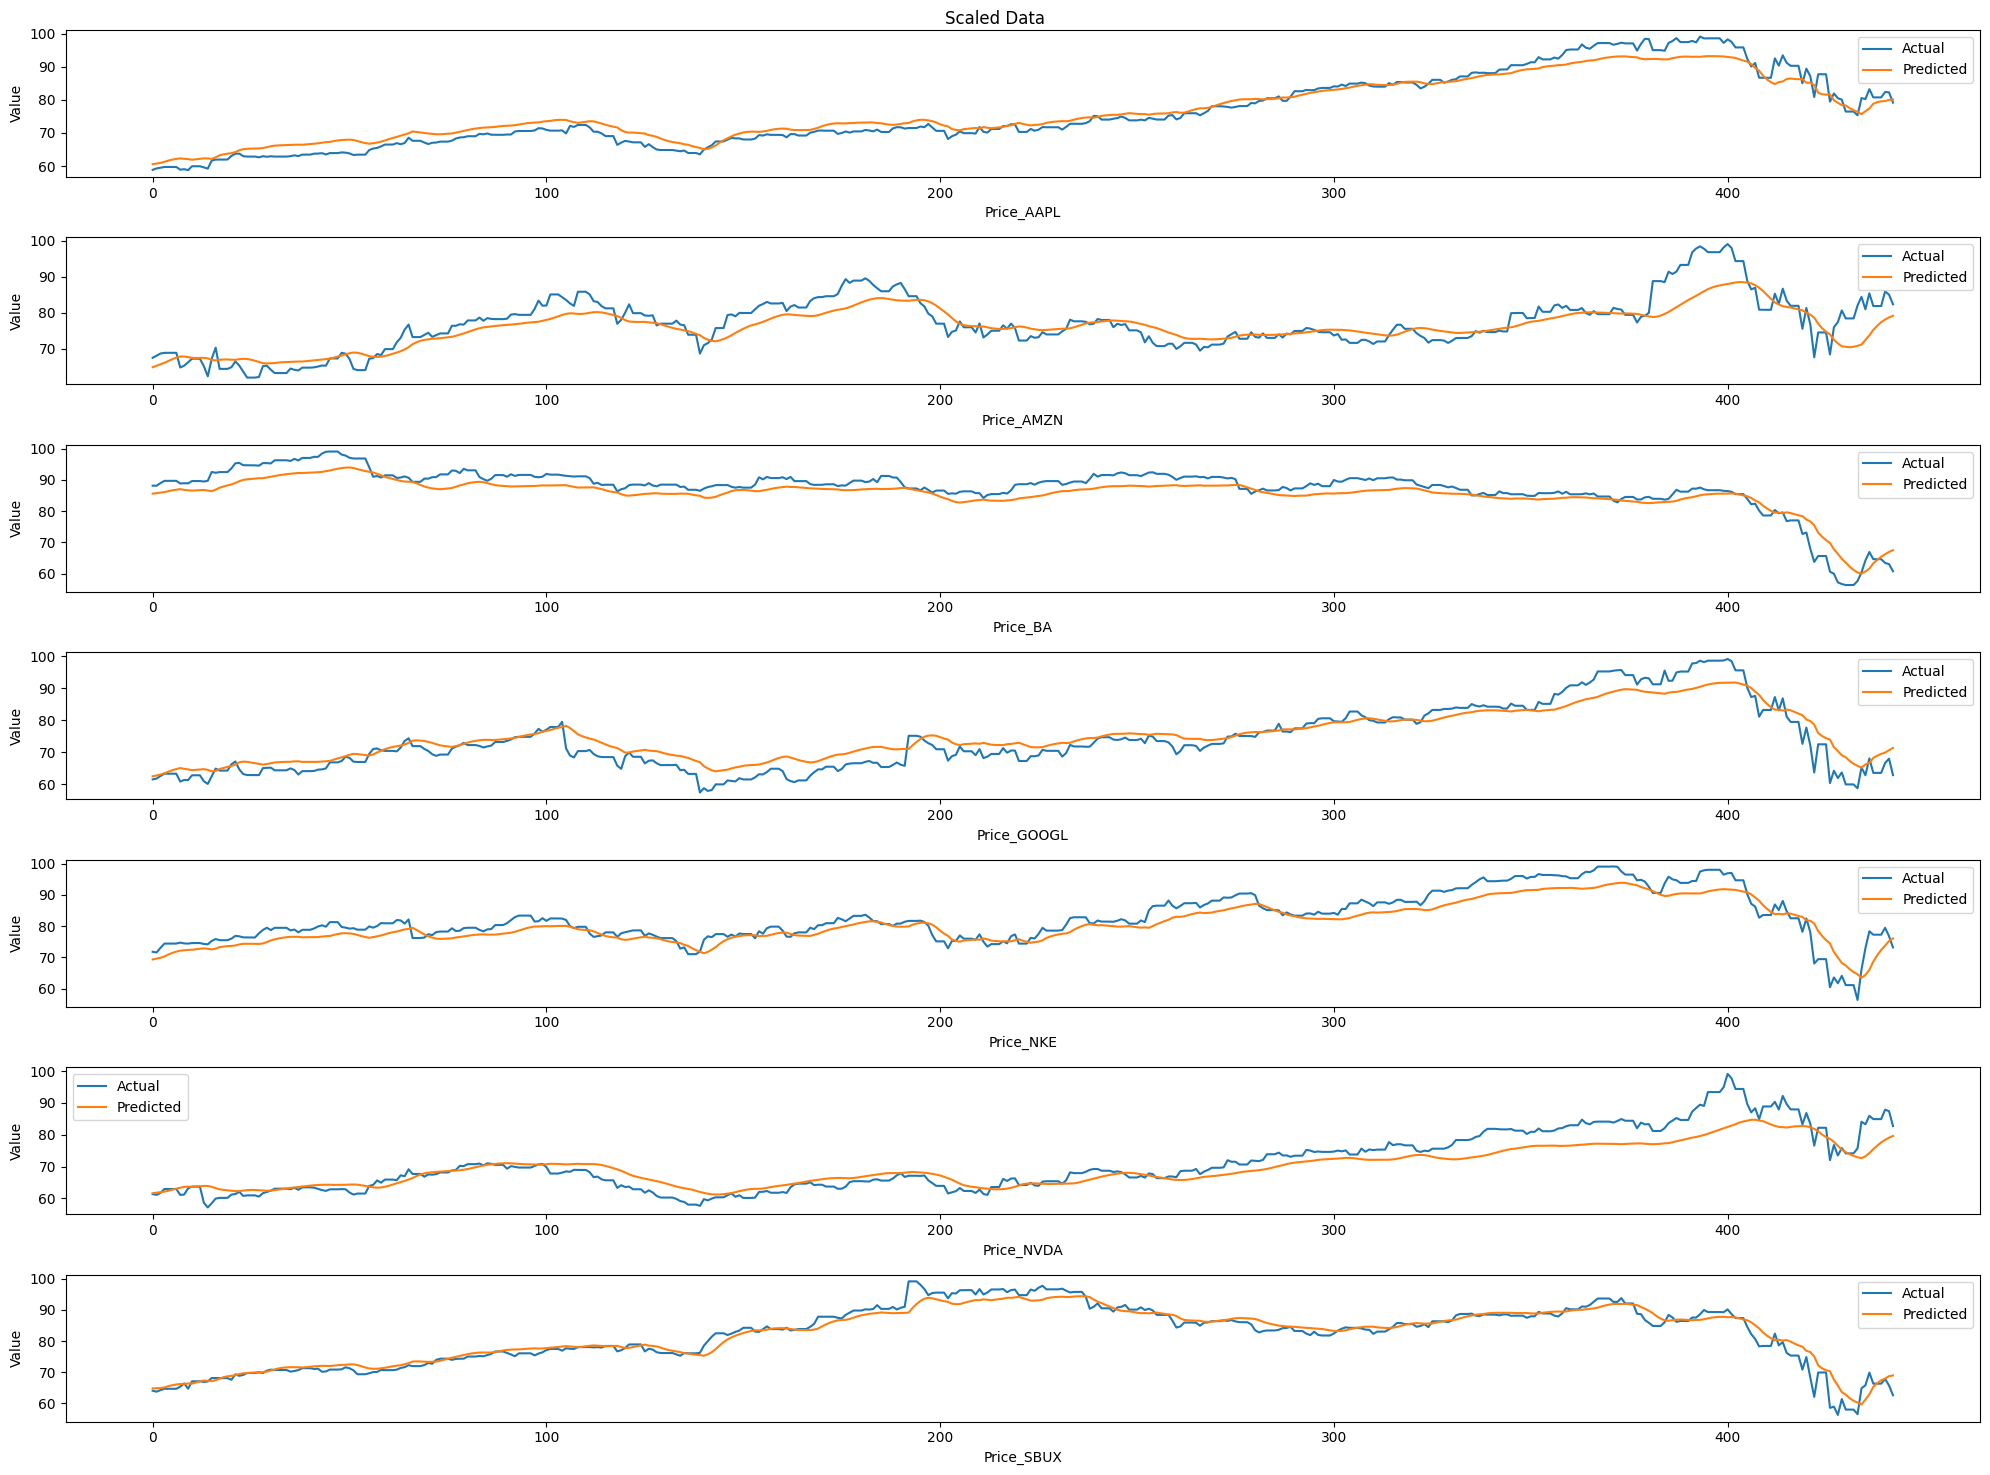

In [ ]:
plt.figure(figsize=(20, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_LSTM[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{VAR_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

# CNN + LSTM
### Find optimal parameters

In [ ]:
def build_cnn_lstm_model(filters, kernel_size, lstm_units, n_past, n_features):
    with strategy.scope():
        inputs = layers.Input(shape=(n_past, n_features), name='input_layer')
        x = layers.Reshape((n_past, n_features, 1), name='reshape_layer')(inputs)
    
        conv1 = layers.Conv2D(
            filters=filters,
            kernel_size=(kernel_size, n_features),
            activation='relu',
            padding='same',
            name='conv1')(x)
        conv1_bn = layers.BatchNormalization(name='conv1_bn')(conv1)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool1')(conv1_bn)
    
        conv2 = layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
            name='conv2')(pool1)
        conv2_bn = layers.BatchNormalization(name='conv2_bn')(conv2)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool2')(conv2_bn)
    
        flatten = layers.Flatten(name='flatten')(pool2)
    
        lstm_input = layers.Reshape((1, flatten.shape[-1]), name='lstm_input')(flatten)
    
        lstm = layers.LSTM(lstm_units, return_state=True, name='lstm')
        _, state_h, _ = lstm(lstm_input)
        
        outputs = layers.Dense(n_features, name='outputs')(state_h)
        
        model_CNN_LSTM = tf.keras.models.Model(inputs, outputs)
        model_CNN_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
    return model_CNN_LSTM

In [ ]:
print('Starting find optimal parameters for CNN + LSTM model')
# Tập giá trị tham số cần quét
param_grid = {
    'filters': [16, 32, 64],
    'kernel_size': [5, 7, 10],
    'lstm_units': [32, 64, 128],
    'batch_size': [16, 32, 64]
}

# Lưu kết quả
results = []
grid = ParameterGrid(param_grid)

# Lặp qua từng tổ hợp tham số
for params in grid:
    print(f"Testing with parameters: {params}")
    cnn_lstm_model = build_cnn_lstm_model(params['filters'], params['kernel_size'], 
                                 params['lstm_units'], p, 7)
    with strategy.scope():
        # Huấn luyện mô hình
        history = cnn_lstm_model.fit(
            trainX, trainY,
            batch_size=params['batch_size'],
            epochs=5,
            verbose=0,
            validation_split=0.2
        )
    
    # Lưu kết quả
    loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    results.append({
        'filters': params['filters'],
        'kernel_size': params['kernel_size'],
        'lstm_units': params['lstm_units'],
        'batch_size': params['batch_size'],
        'loss': loss,
        'val_loss': val_loss
    })

# Sắp xếp kết quả theo val_loss
results = sorted(results, key=lambda x: x['val_loss'])

# Hiển thị kết quả tốt nhất
print("Best parameters:", results[0])
best_para_cnn_lstm = results[0]

Starting find optimal parameters for CNN + LSTM model
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 5, 'lstm_units': 32}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 5, 'lstm_units': 64}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 5, 'lstm_units': 128}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 7, 'lstm_units': 32}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 7, 'lstm_units': 64}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 7, 'lstm_units': 128}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 10, 'lstm_units': 32}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 10, 'lstm_units': 64}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 10, 'lstm_units': 128}
Testing with parameters: {'batch_size': 16, 'filters': 32, 'kernel_size': 5, 'lstm_un

### Model initialization

In [ ]:
class CNN_LSTM_Model:
    def __init__(self, n_past, n_features, best_para_cnn_lstm, strategy):
        self.n_past = n_past
        self.n_features = n_features
        self.best_para_cnn_lstm = best_para_cnn_lstm
        self.strategy = strategy

        # Xây dựng mô hình CNN + LSTM
        with self.strategy.scope():
            self.model_CNN_LSTM = self._build_model()

    def _build_model(self):
        filters = self.best_para_cnn_lstm['filters']
        kernel_size = self.best_para_cnn_lstm['kernel_size']
        lstm_units = self.best_para_cnn_lstm['lstm_units']
        with strategy.scope():
            inputs = layers.Input(shape=(self.n_past, self.n_features), name='input_layer')
            x = layers.Reshape((self.n_past, self.n_features, 1), name='reshape_layer')(inputs)
        
            conv1 = layers.Conv2D(
                filters=filters,
                kernel_size=(kernel_size, self.n_features),
                activation='relu',
                padding='same',
                name='conv1')(x)
            conv1_bn = layers.BatchNormalization(name='conv1_bn')(conv1)
            pool1 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool1')(conv1_bn)
        
            conv2 = layers.Conv2D(
                filters=filters,
                kernel_size=(3, 3),
                activation='relu',
                padding='same',
                name='conv2')(pool1)
            conv2_bn = layers.BatchNormalization(name='conv2_bn')(conv2)
            pool2 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool2')(conv2_bn)
        
            flatten = layers.Flatten(name='flatten')(pool2)
        
            lstm_input = layers.Reshape((1, flatten.shape[-1]), name='lstm_input')(flatten)
        
            lstm = layers.LSTM(lstm_units, return_state=True, name='lstm')
            _, state_h, _ = lstm(lstm_input)
            
            outputs = layers.Dense(self.n_features, name='outputs')(state_h)
            
            model_CNN_LSTM = tf.keras.models.Model(inputs, outputs)
            model_CNN_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])
            
        return model_CNN_LSTM

    def train(self, trainX, trainY):
        print('Start training CNN + LSTM')

        reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        start = time.time()
        with self.strategy.scope():        
            history_CNN_LSTM = self.model_CNN_LSTM.fit(
                trainX,
                trainY,
                epochs=100,
                validation_split=0.2,
                batch_size=self.best_para_cnn_lstm['batch_size'],
                verbose=0,
                callbacks=[reduce_lr, early_stopping]
            )
        end = time.time()
        print('Complete training model')
        print(f'Training time: {end - start:.2f} seconds')
        return history_CNN_LSTM

    def summary(self):
        self.model_CNN_LSTM.summary()

    def plot_loss(self, history_CNN_LSTM):
        loss = history_CNN_LSTM.history['loss']
        val_loss = history_CNN_LSTM.history['val_loss']
        epochs = range(1, len(loss) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss, 'bo-', label='Training loss')
        plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def predict(self, testX):
        # Phương thức dự đoán
        return self.model_CNN_LSTM.predict(testX)

In [ ]:
cnn_lstm_model = CNN_LSTM_Model(n_past=p, n_features=7, best_para_cnn_lstm=best_para_cnn_lstm, strategy=strategy)
cnn_lstm_model.summary()

Model: "functional_219"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (Reshape)         │ (None, 14, 7, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 14, 7, 64)      │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 14, 7, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_bn (BatchNormalization)   │ (None, 7, 4, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 4, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_input (Reshape)            │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 64), (None,    │       147,712 │
│                                 │ 64), (None, 64)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,911 (734.03 KB)

 Trainable params: 187,655 (733.03 KB)

 Non-trainable params: 256 (1.00 KB)

### Model training

In [ ]:
history = cnn_lstm_model.train(trainX, trainY)

Start training CNN + LSTM
Complete training model
Training time: 14.15 seconds


In [ ]:
pred_CNN_LSTM = cnn_lstm_model.predict(testX)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
last_test_values = scaled_test.iloc[p:]
testY_original = reverse_difference(last_test_values, testY)
pred_CNN_LSTM_original = reverse_difference(last_test_values, pred_CNN_LSTM)

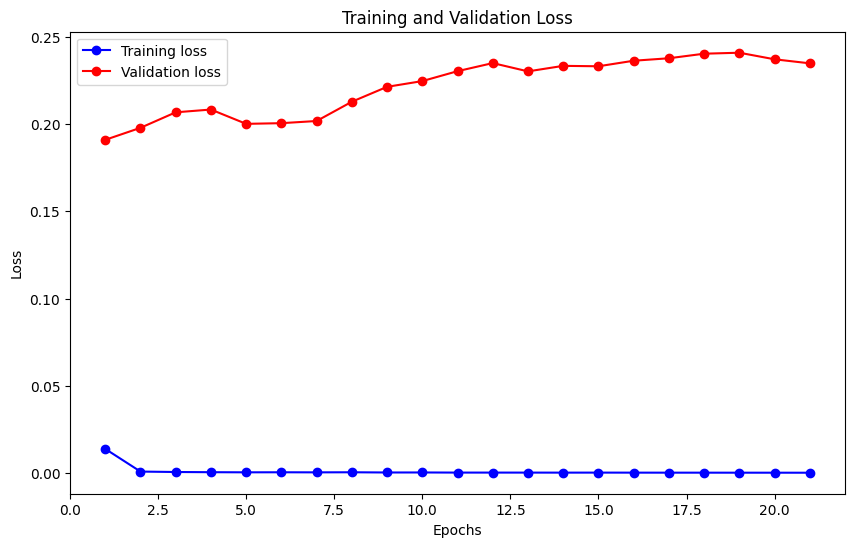

In [ ]:
cnn_lstm_model.plot_loss(history)

### Model Score
#### Scaled data

In [ ]:
for i in range(7):
    print(f'MSE for {VAR_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_CNN_LSTM_original[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY_original, pred_CNN_LSTM_original)}')

MSE for Price_AAPL: 0.22425925424393459
MSE for Price_AMZN: 0.16113357309698428
MSE for Price_BA: 0.5362638246884933
MSE for Price_GOOGL: 0.09039371813154211
MSE for Price_NKE: 0.14972541835942826
MSE for Price_NVDA: 0.304738458750256
MSE for Price_SBUX: 0.15498290981892035
MSE total: 0.23164245101279415


In [ ]:
for i in range(7):
    print(f'RMSE for {VAR_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_CNN_LSTM_original[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(testY_original, pred_CNN_LSTM_original, squared=False)}')

RMSE for Price_AAPL: 0.4735601907296839
RMSE for Price_AMZN: 0.401414465480486
RMSE for Price_BA: 0.7323003650746689
RMSE for Price_GOOGL: 0.30065548079411775
RMSE for Price_NKE: 0.3869436888740121
RMSE for Price_NVDA: 0.5520312117536978
RMSE for Price_SBUX: 0.39367868855060006
RMSE total: 0.4629405844653238


In [ ]:
for i in range(7):
    print(f'MAE for {VAR_test.columns[i]}: {mean_absolute_error(testY_original[:, i], pred_CNN_LSTM_original[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY_original, pred_CNN_LSTM_original)}')

MAE for Price_AAPL: 0.34984533677689084
MAE for Price_AMZN: 0.3011114324791079
MAE for Price_BA: 0.6350536301321528
MAE for Price_GOOGL: 0.25036461583466124
MAE for Price_NKE: 0.2957615915986004
MAE for Price_NVDA: 0.4162745407330778
MAE for Price_SBUX: 0.3296135484458371
MAE total: 0.3682892422857615


In [ ]:
for i in range(7):
    print(f'R2 for {VAR_test.columns[i]}: {r2_score(testY_original[:, i], pred_CNN_LSTM_original[:, i])}')
    
print(f'R2 total: {r2_score(testY_original, pred_CNN_LSTM_original)}')

R2 for Price_AAPL: 0.13812802374748845
R2 for Price_AMZN: -0.378118537282752
R2 for Price_BA: -4.02797805850328
R2 for Price_GOOGL: 0.578566861818099
R2 for Price_NKE: -0.15867948085862893
R2 for Price_NVDA: -0.7067947199741971
R2 for Price_SBUX: 0.19144509242567798
R2 total: -0.6233472598039411


#### Unscaled data

In [ ]:
unscaled_CNN_LSTM = unscale(pred_CNN_LSTM_original)
originY = unscale(testY_original)

In [ ]:
for i in range(7):
    print(f'MSE for {VAR_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_CNN_LSTM[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_CNN_LSTM)}')

MSE for Price_AAPL: 102.60580447086589
MSE for Price_AMZN: 73.72378156077862
MSE for Price_BA: 245.35790590068027
MSE for Price_GOOGL: 41.358026134138186
MSE for Price_NKE: 68.50418069880511
MSE for Price_NVDA: 139.4276293592971
MSE for Price_SBUX: 70.90964703348828
MSE total: 105.9838535940077


In [ ]:
for i in range(7):
    print(f'RMSE for {VAR_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_CNN_LSTM[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(originY, unscaled_CNN_LSTM, squared=False)}')

RMSE for Price_AAPL: 10.12945232827846
RMSE for Price_AMZN: 8.586255386417214
RMSE for Price_BA: 15.66390455476157
RMSE for Price_GOOGL: 6.431020613723625
RMSE for Price_NKE: 8.276725240021268
RMSE for Price_NVDA: 11.807947720044204
RMSE for Price_SBUX: 8.420786604200838
RMSE total: 9.902298921063887


In [ ]:
for i in range(7):
    print(f'MAE for {VAR_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_CNN_LSTM[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_CNN_LSTM)}')

MAE for Price_AAPL: 7.483191700233776
MAE for Price_AMZN: 6.440773535870592
MAE for Price_BA: 13.583796959951584
MAE for Price_GOOGL: 5.355299094617413
MAE for Price_NKE: 6.3263401779693655
MAE for Price_NVDA: 8.904112758355827
MAE for Price_SBUX: 7.050433277276515
MAE total: 7.8777067863250085


### Plot predict data

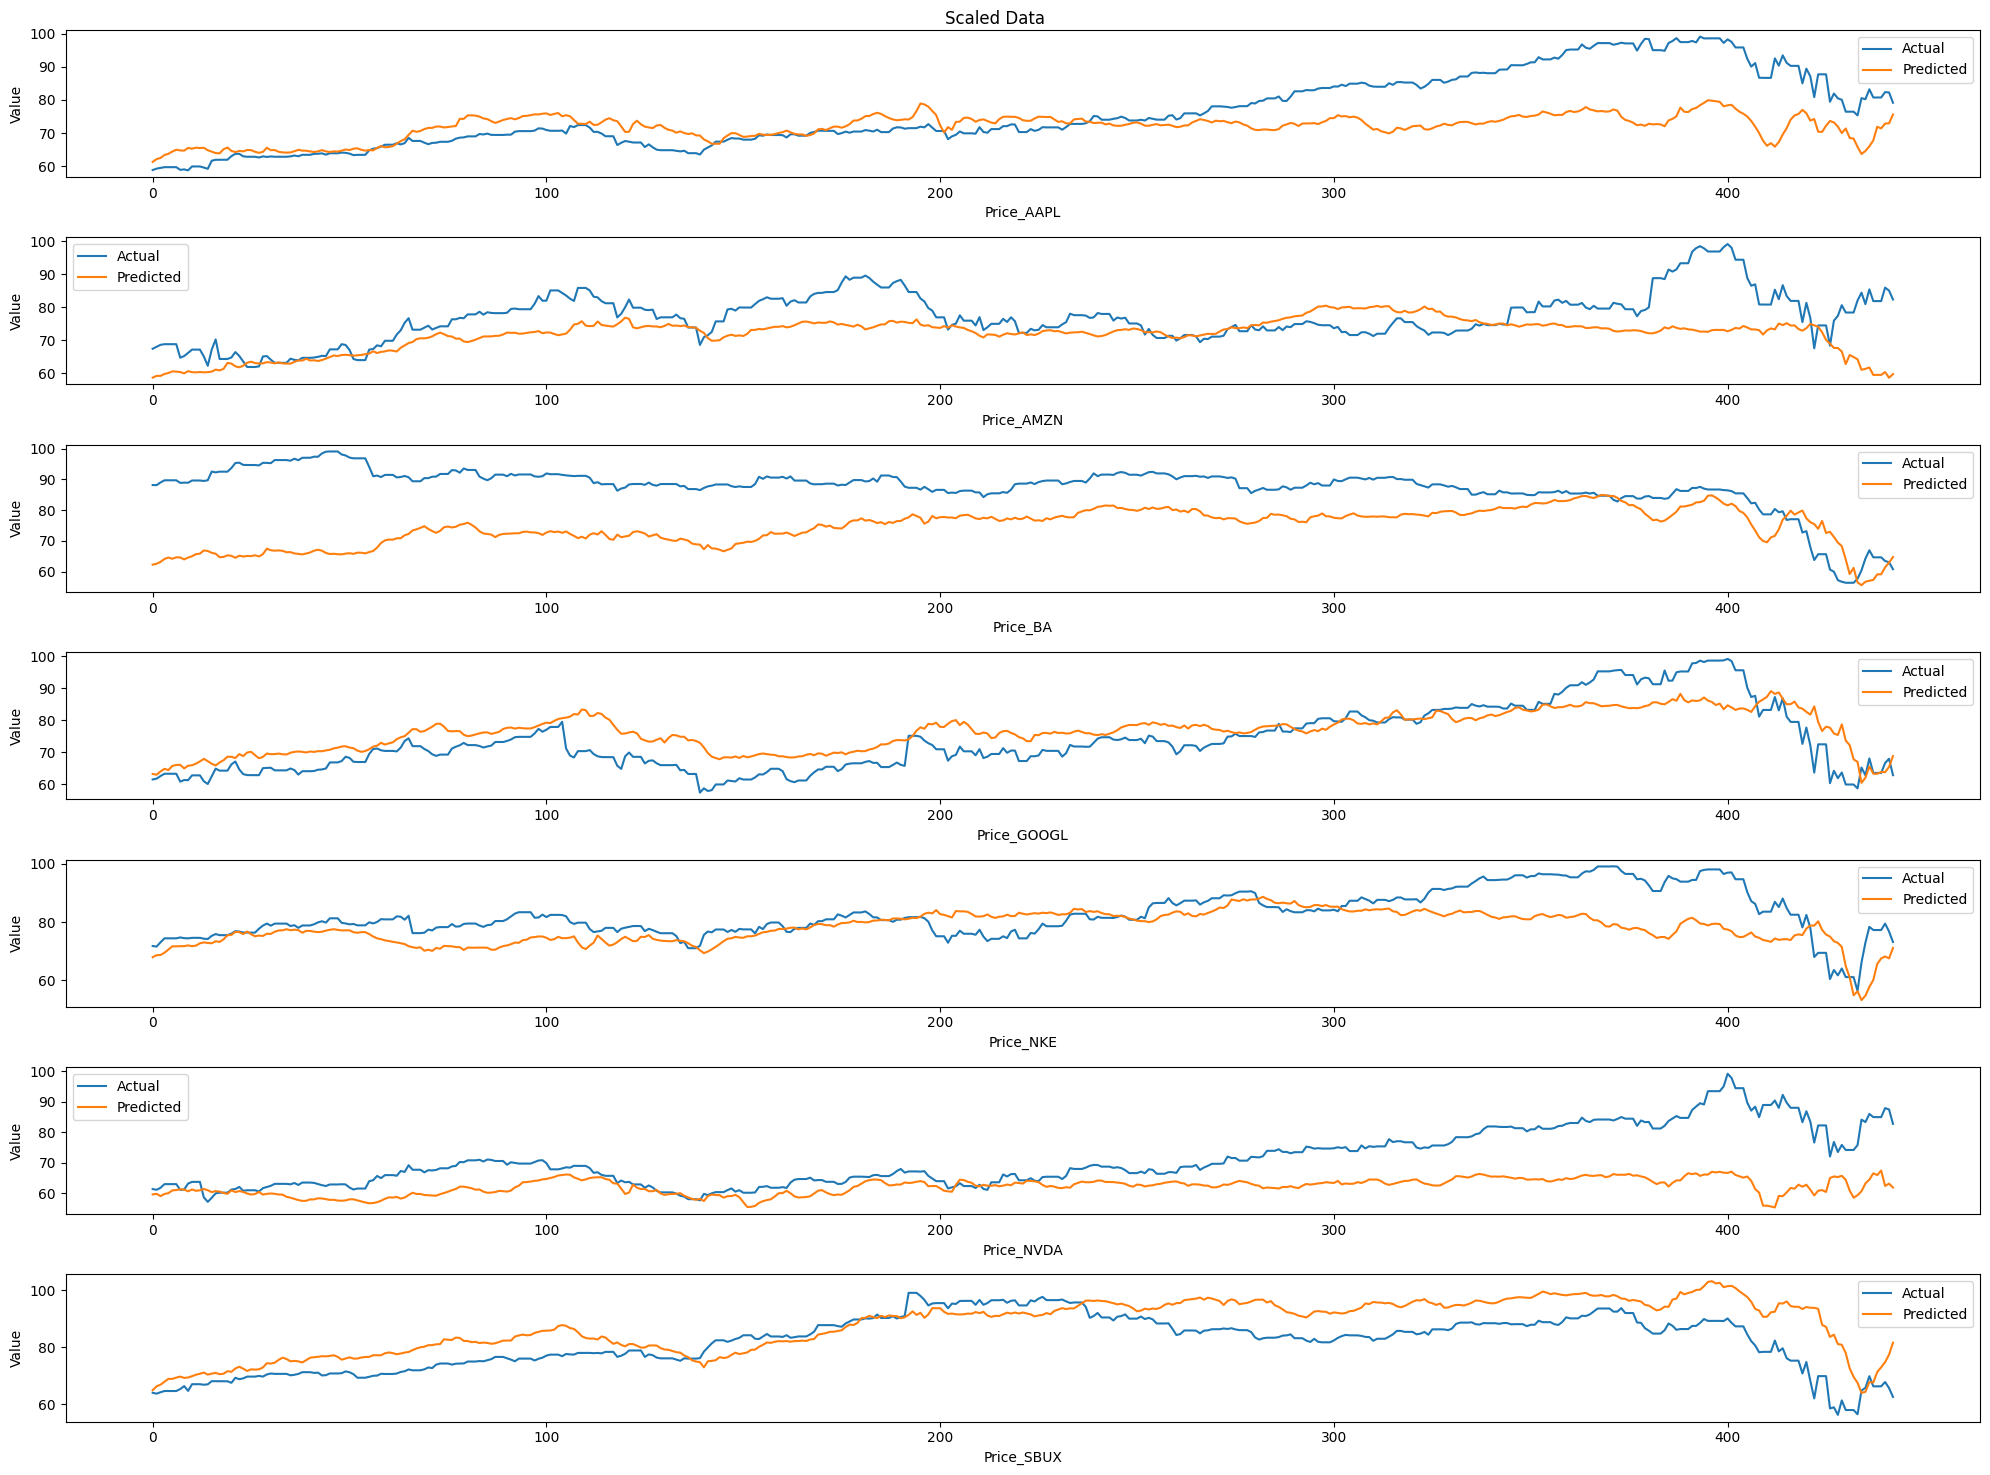

In [ ]:
plt.figure(figsize=(20, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_CNN_LSTM[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{VAR_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

## VARNN
### Define model

In [ ]:
var_model = VAR(VAR_train_diff)
var_results = var_model.fit(p)
var_coefficients = var_results.params

In [ ]:
class VARNN(tf.keras.Model):
    def __init__(self, var_weights, var_bias, hidden_units):
        super(VARNN, self).__init__()
        self.ffnn_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(p, 7)),  
            tf.keras.layers.Dense(hidden_units, activation='sigmoid')
        ])
        self.var_weights = tf.cast(var_weights, tf.float32)
        self.var_bias = tf.cast(var_bias, tf.float32)
        self.hidden_units = hidden_units

    def call(self, inputs):
        ffnn_output = self.ffnn_model(inputs)
        ffnn_output = tf.reshape(ffnn_output, [-1, self.hidden_units])
        var_output = tf.matmul(ffnn_output, self.var_weights) + self.var_bias
        return var_output

In [ ]:
num_outputs = 7
var_bias = var_coefficients.loc['const'].values
var_weights = var_coefficients.drop('const').values

### Model training

In [ ]:
VARNN_model = VARNN(var_weights, var_bias, num_outputs * p)
start = time.time()
VARNN_model.compile(optimizer='adam', loss='mse')
history = VARNN_model.fit(trainX, trainY, verbose=0, epochs=100, batch_size=32, validation_split=0.2)
end = time.time()

In [ ]:
print(end-start)

26.792221784591675


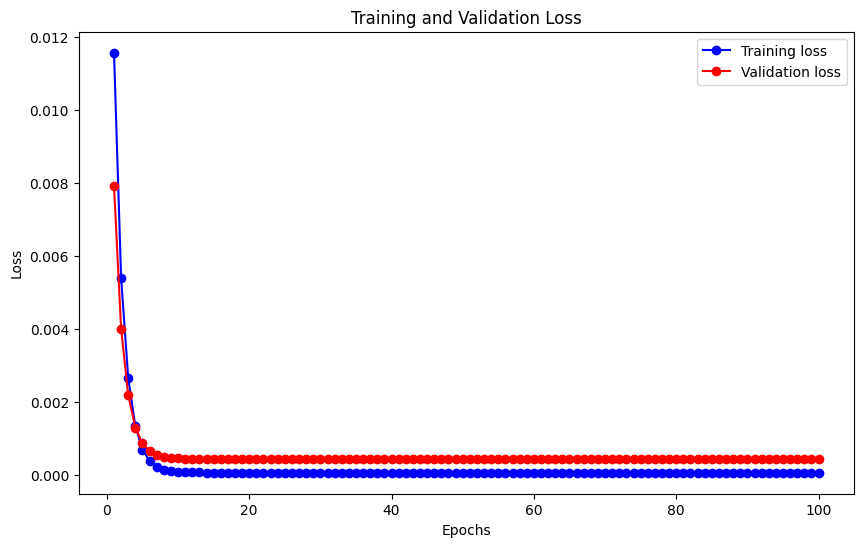

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pred_VARNN = VARNN_model.predict(testX)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
def reverse_difference(original_data, differenced_data, order=1):
    reversed_data = []
    last_original_value = original_data.iloc[-len(differenced_data) - order:-order].values
    for i in range(len(differenced_data)):
        restored = differenced_data[i] + last_original_value[i]
        reversed_data.append(restored)
    return np.array(reversed_data)

In [ ]:
last_test_values = VAR_test.iloc[p:]
testY_original = reverse_difference(last_test_values, testY)
pred_VARNN_original = reverse_difference(last_test_values, pred_VARNN)

### Model Evaluation
#### Scaled data

In [ ]:
for i in range(7):
    print(f'MSE for {VAR_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_VARNN_original[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY_original, pred_VARNN_original)}')

MSE for Price_AAPL: 0.0021411159363882598
MSE for Price_AMZN: 0.0009142705397732164
MSE for Price_BA: 0.0017154203396539866
MSE for Price_GOOGL: 0.0013836863541191772
MSE for Price_NKE: 0.0017496787811592696
MSE for Price_NVDA: 0.0019621622756972852
MSE for Price_SBUX: 0.002185312634656502
MSE total: 0.0017216638373496707


In [ ]:
for i in range(7):
    print(f'RMSE for {VAR_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_VARNN_original[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(testY_original, pred_VARNN_original, squared=False)}')

RMSE for Price_AAPL: 0.04627219398719127
RMSE for Price_AMZN: 0.03023690691478241
RMSE for Price_BA: 0.04141763319715392
RMSE for Price_GOOGL: 0.037197934809867834
RMSE for Price_NKE: 0.04182916185102529
RMSE for Price_NVDA: 0.04429630092566743
RMSE for Price_SBUX: 0.04674732756700111
RMSE total: 0.041142494178955616


In [ ]:
for i in range(7):
    print(f'MAE for {VAR_test.columns[i]}: {mean_absolute_error(testY_original[:, i], pred_VARNN_original[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY_original, pred_VARNN_original)}')

MAE for Price_AAPL: 0.02507422347969491
MAE for Price_AMZN: 0.018804586500414618
MAE for Price_BA: 0.02472442362780673
MAE for Price_GOOGL: 0.021579997062490065
MAE for Price_NKE: 0.02376160327381793
MAE for Price_NVDA: 0.02505209958739057
MAE for Price_SBUX: 0.025332934609444073
MAE total: 0.023475695448722696


In [ ]:
for i in range(7):
    print(f'R2 for {VAR_test.columns[i]}: {r2_score(testY_original[:, i], pred_VARNN_original[:, i])}')
    
print(f'R2 total: {r2_score(testY_original, pred_VARNN_original)}')

R2 for Price_AAPL: 0.9872525587313493
R2 for Price_AMZN: 0.9292577721703799
R2 for Price_BA: 0.9823026578167062
R2 for Price_GOOGL: 0.960471535507587
R2 for Price_NKE: 0.9546885065846104
R2 for Price_NVDA: 0.9743008673761165
R2 for Price_SBUX: 0.9734112780957429
R2 total: 0.9659550251832132


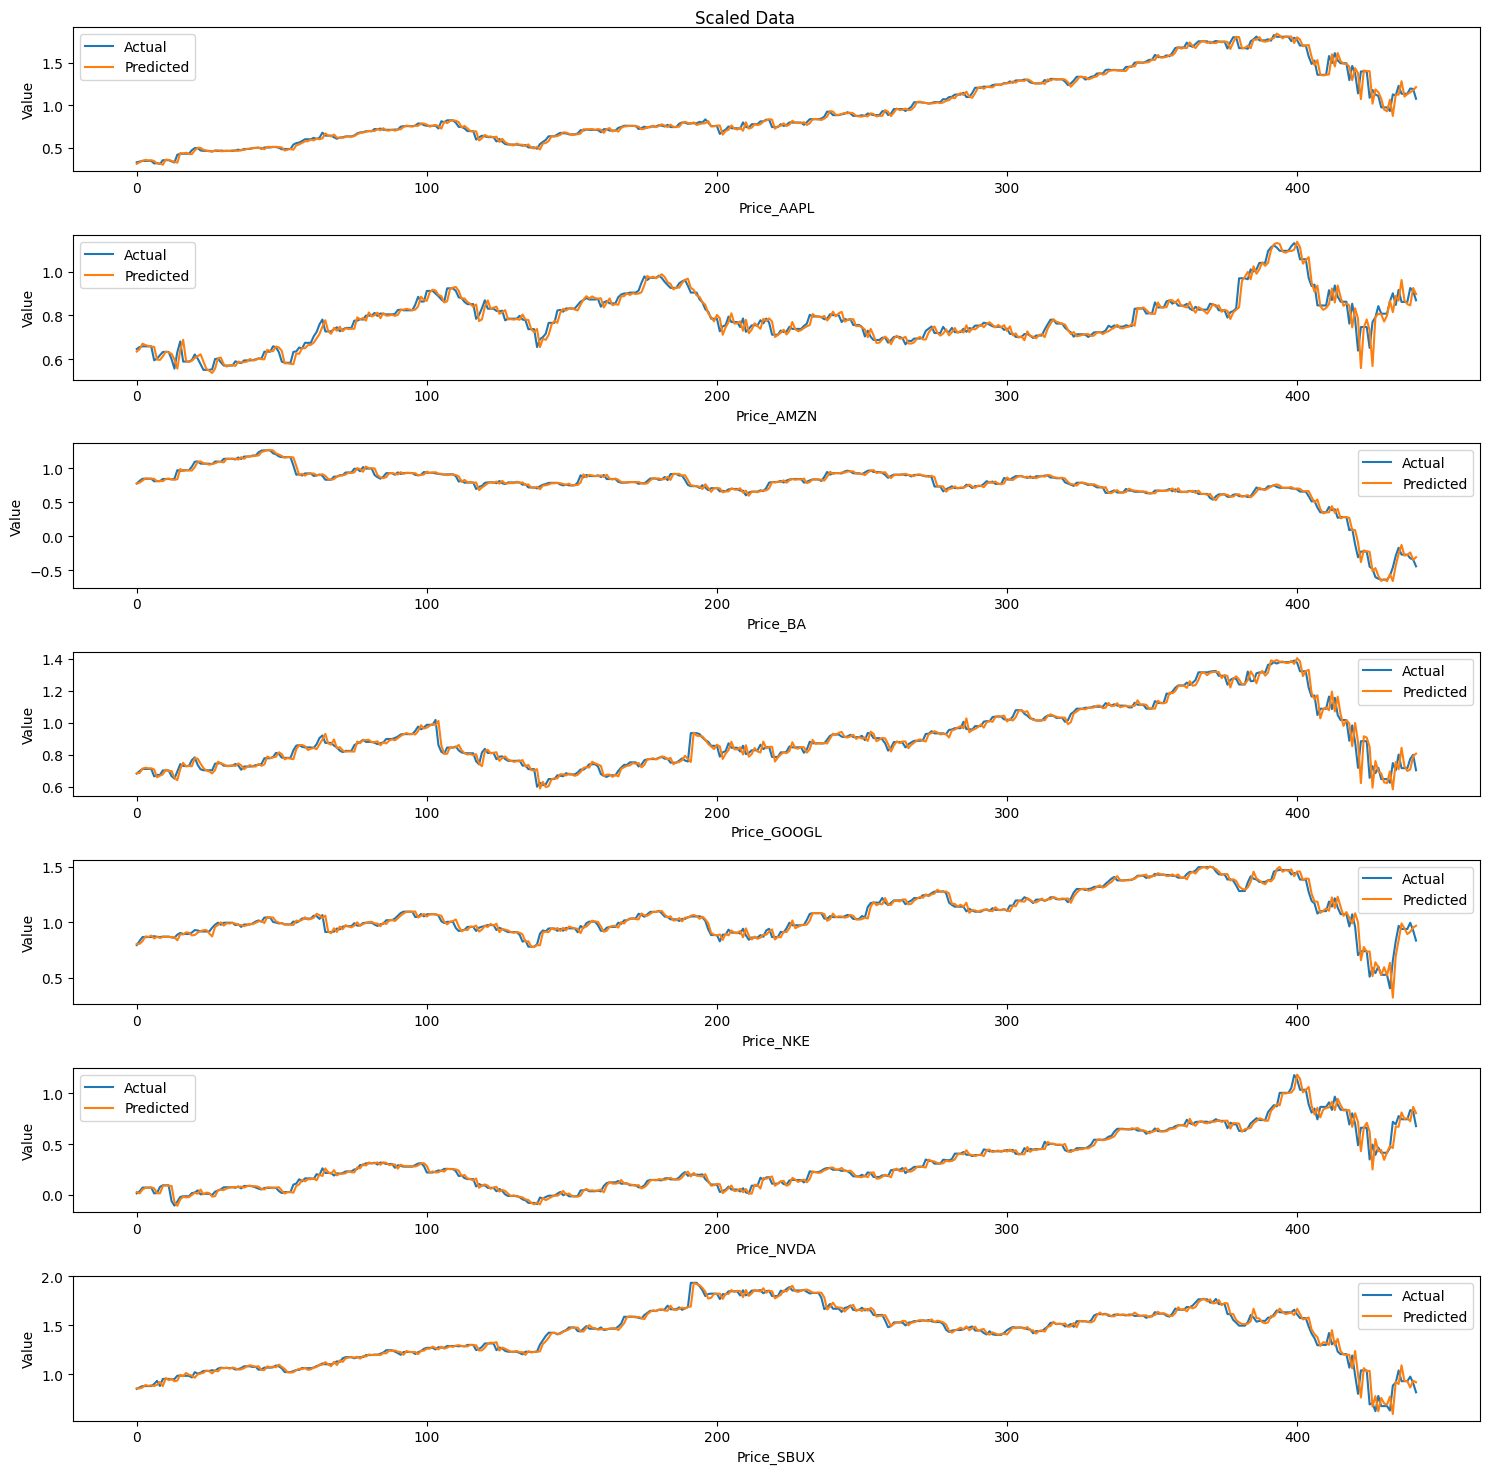

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(testY_original[:, i], label='Actual')
    plt.plot(pred_VARNN_original[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{VAR_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

#### Unscaled data

In [ ]:
def unscale(data):
    temp = data.copy()
    for index, i in enumerate(temp_df.columns):
        scaler = scalers['scaler_' + i]
        temp[:, index] = scaler.inverse_transform(np.reshape(data[:, index], (-1, 1))).flatten()
    return temp

In [ ]:
unscaled_VARNN = unscale(pred_VARNN_original)
originY = unscale(testY_original)

In [ ]:
for i in range(7):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_VARNN[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_VARNN)}')

MSE for Price_AAPL: 28.285841472502252
MSE for Price_AMZN: 926.599632091823
MSE for Price_BA: 56.491122310329054
MSE for Price_DIS: 527.9884971719366
MSE for Price_GOOGL: 2.549443217444581
MSE for Price_INTC: 39.97661132636749
MSE for Price_MSFT: 2.3178345705338996
MSE total: 226.31556888013392


In [ ]:
for i in range(7):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_VARNN[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(originY, unscaled_VARNN, squared=False)}')

RMSE for Price_AAPL: 5.318443519724756
RMSE for Price_AMZN: 30.440099081504695
RMSE for Price_BA: 7.516057630854693
RMSE for Price_DIS: 22.978000286620606
RMSE for Price_GOOGL: 1.5966975973692017
RMSE for Price_INTC: 6.322706012963713
RMSE for Price_MSFT: 1.5224436181789787
RMSE total: 10.813492535316666


In [ ]:
for i in range(7):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_VARNN[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_VARNN)}')

MAE for Price_AAPL: 2.8819865644284843
MAE for Price_AMZN: 18.930953416386036
MAE for Price_BA: 4.486740997286887
MAE for Price_DIS: 13.330449155893083
MAE for Price_GOOGL: 0.9070249839590151
MAE for Price_INTC: 3.5758530032645948
MAE for Price_MSFT: 0.8250303628718786
MAE total: 6.4197197834414235


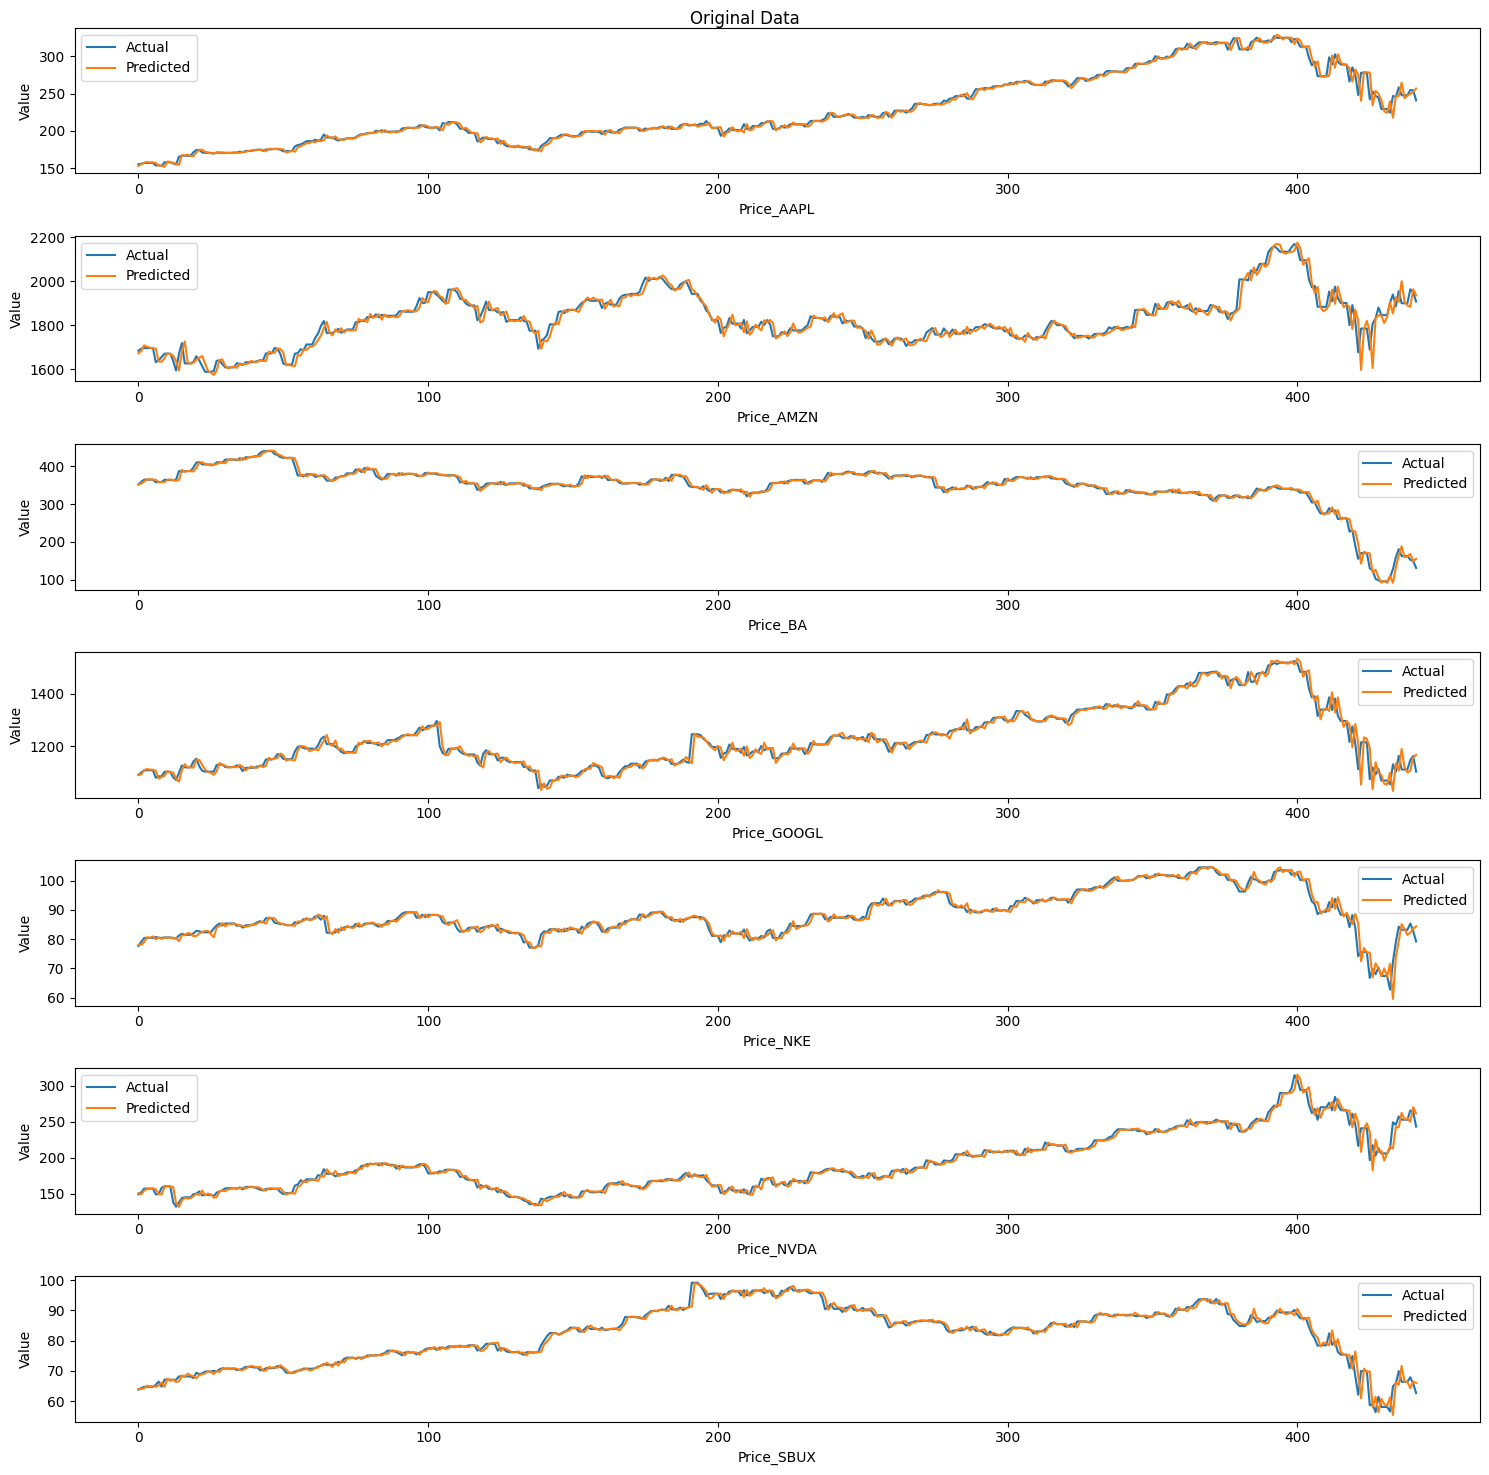

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_VARNN[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{VAR_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Original Data')
plt.tight_layout()
plt.show()

## SrVAR
### Define model

In [ ]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return h_n[-1] 

In [ ]:
class StateRegularizedUnit(nn.Module):
    def __init__(self, hidden_dim, num_states, tau=1.0):
        super(StateRegularizedUnit, self).__init__()
        self.state_encodings = nn.Parameter(torch.randn(num_states, hidden_dim))
        self.tau = tau

    def forward(self, u_t):
        # Proximity scores
        proximity_scores = torch.matmul(u_t, self.state_encodings.T)
        alpha = torch.softmax(proximity_scores / self.tau, dim=-1) 

        h_t = torch.matmul(alpha, self.state_encodings)  

        # Tính entropy regularization
        entropy_reg = -torch.sum(alpha * torch.log(alpha + 1e-10), dim=-1).mean()

        return h_t, alpha, entropy_reg

In [ ]:
class GraphGeneration(nn.Module):
    def __init__(self, hidden_dim, num_vars):
        super(GraphGeneration, self).__init__()
        self.g_a = nn.Linear(hidden_dim, num_vars * num_vars)
        self.g_d = nn.Linear(hidden_dim, num_vars)

    def forward(self, c_st):
        A_st = self.g_a(c_st).view(-1, num_vars, num_vars)

        D_st = torch.diag_embed(self.g_d(c_st))

        # Ràng buộc tính không chu kỳ (Acyclicity constraint)
        exp_A = torch.matrix_exp(A_st * A_st)  
        trace_exp_A = torch.sum(torch.diagonal(exp_A, dim1=-2, dim2=-1), dim=-1)
        acyclic_penalty = torch.mean(trace_exp_A - A_st.size(-1))

        return A_st, D_st, acyclic_penalty

In [ ]:
class DynamicVAR(nn.Module):
    def __init__(self, num_vars):
        super(DynamicVAR, self).__init__()
        self.var_weights = nn.Parameter(torch.randn(num_vars, num_vars))

    def forward(self, x_t, A_st, D_st):
        batch_size = x_t.size(0)
        x_t = x_t.unsqueeze(-1)

        x_hat_A = torch.matmul(A_st, x_t).squeeze(-1)

        weighted_x_t = torch.matmul(self.var_weights, x_t.squeeze(-1).unsqueeze(-1)).squeeze(-1)
        x_hat_D = torch.matmul(D_st, weighted_x_t.unsqueeze(-1)).squeeze(-1)

        x_hat = x_hat_A + x_hat_D
        return x_hat

In [ ]:
class SrVARModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_states, num_vars, tau=10.0):
        super(SrVARModel, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim)
        self.state_regularized_unit = StateRegularizedUnit(hidden_dim, num_states, tau)
        self.graph_generation = GraphGeneration(hidden_dim, num_vars)
        self.dynamic_var = DynamicVAR(num_vars)

    def forward(self, x):
        u_t = self.encoder(x)
        h_t, alpha, entropy_reg = self.state_regularized_unit(u_t)
        A_st, D_st, acyclic_penalty = self.graph_generation(h_t)
        x_hat = self.dynamic_var(x[:, -1, :], A_st, D_st)

        return x_hat, alpha, entropy_reg, acyclic_penalty

In [ ]:
def train_srvarm(model, trainX, trainY, valX, valY, num_epochs=100, batch_size=32, lr=0.001, tau=1.0, verbose=0):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    # Lagrangian parameters
    rho = 1.0
    lagrangian_multiplier = 0.0
    max_rho = 10.0

    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        train_epoch_loss = 0

        for i in range(0, len(trainX), batch_size):
            batch_x = torch.tensor(trainX[i:i + batch_size], dtype=torch.float32)
            batch_y = torch.tensor(trainY[i:i + batch_size], dtype=torch.float32)

            x_hat, alpha, entropy_reg, acyclic_penalty = model(batch_x)

            loss = (
                mse_loss(x_hat, batch_y)
                + 0.01 * entropy_reg
                + rho / 2 * acyclic_penalty.pow(2).mean()
                + lagrangian_multiplier * acyclic_penalty.mean()
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()

        train_avg_loss = train_epoch_loss / (len(trainX) / batch_size)
        train_loss_history.append(train_avg_loss)

        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for i in range(0, len(valX), batch_size):
                batch_val_x = torch.tensor(valX[i:i + batch_size], dtype=torch.float32)
                batch_val_y = torch.tensor(valY[i:i + batch_size], dtype=torch.float32)

                x_hat, alpha, entropy_reg, acyclic_penalty = model(batch_val_x)

                val_loss = mse_loss(x_hat, batch_val_y) + 0.01 * entropy_reg
                val_epoch_loss += val_loss.item()

        val_avg_loss = val_epoch_loss / (len(valX) / batch_size)
        val_loss_history.append(val_avg_loss)

        if verbose == 1:
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_avg_loss:.4f}, Val Loss: {val_avg_loss:.4f}")

    return model, train_loss_history, val_loss_history

In [ ]:
Xtrain, valX, Ytrain, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

input_dim = trainX.shape[2]
hidden_dim = 64
num_vars = trainX.shape[2]

for num_states in range(1, 6):
    model = SrVARModel(input_dim=input_dim, hidden_dim=hidden_dim, num_states=num_states, num_vars=num_vars)
    trained_model_SrVAR, train_loss_history_SrVAR, val_loss_history_SrVAR = train_srvarm(
        model, Xtrain, Ytrain, valX, valY, num_epochs=100, batch_size=32, lr=0.001, tau=1.0, verbose=0
    )

    print(f"num_states: {num_states}, train_loss: {train_loss_history_SrVAR[-1]}, val_loss: {val_loss_history_SrVAR[-1]}")

num_states: 1, train_loss: 0.0001241739506867073, val_loss: 0.00013869139260221932
num_states: 2, train_loss: 0.0001301109827845769, val_loss: 0.0001424308739506498
num_states: 3, train_loss: 0.00013351938715631769, val_loss: 0.0001495656862707298
num_states: 4, train_loss: 0.00013301652397073154, val_loss: 0.0001497051362597598
num_states: 5, train_loss: 0.00013048458485999818, val_loss: 0.00014411990516111894


### Model training

In [ ]:
num_states = 2

model_SrVAR = SrVARModel(input_dim=input_dim, hidden_dim=hidden_dim, num_states=num_states, num_vars=num_vars)

start = time.time()
trained_model_SrVAR, train_loss_history_SrVAR, val_loss_history_SrVAR = train_srvarm(
    model_SrVAR, Xtrain, Ytrain, valX, valY, num_epochs=100, batch_size=32, lr=0.001, tau=1.0, verbose=1
)
end = time.time()

print(f"Training completed in {end - start:.2f} seconds")

Epoch 10/100, Train Loss: 0.0002, Val Loss: 0.0003
Epoch 20/100, Train Loss: 0.0002, Val Loss: 0.0002
Epoch 30/100, Train Loss: 0.0002, Val Loss: 0.0002
Epoch 40/100, Train Loss: 0.0002, Val Loss: 0.0002
Epoch 50/100, Train Loss: 0.0002, Val Loss: 0.0002
Epoch 60/100, Train Loss: 0.0002, Val Loss: 0.0002
Epoch 70/100, Train Loss: 0.0002, Val Loss: 0.0002
Epoch 80/100, Train Loss: 0.0002, Val Loss: 0.0002
Epoch 90/100, Train Loss: 0.0001, Val Loss: 0.0002
Epoch 100/100, Train Loss: 0.0001, Val Loss: 0.0002
Training completed in 94.56 seconds


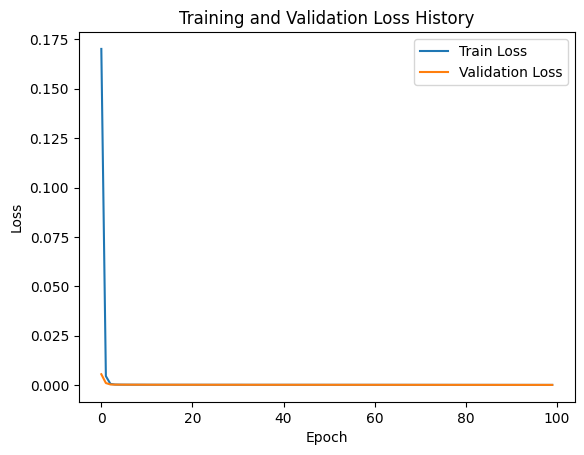

In [ ]:
plt.plot(train_loss_history_SrVAR, label="Train Loss")
plt.plot(val_loss_history_SrVAR, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss History")
plt.legend()
plt.show()

In [ ]:
model_SrVAR.eval() 
predictions_SrVAR = []
batch_size = 32
n_features = 7

with torch.no_grad():
    for i in range(0, len(testX), batch_size):
        batch_x = torch.tensor(testX[i:i+batch_size], dtype=torch.float32)

        batch_pred, _, _, _ = model_SrVAR(batch_x)

        predictions_SrVAR.append(batch_pred.cpu().numpy())

predictions_SrVAR = np.concatenate(predictions_SrVAR, axis=0)

In [ ]:
last_test_values = VAR_test.iloc[p:]
testY_original = reverse_difference(last_test_values, testY)
pred_SrVAR_original = reverse_difference(last_test_values, predictions_SrVAR)

### Model Evaluation
#### Scaled data

In [ ]:
for i in range(n_features):
    print(f'MSE for {VAR_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_SrVAR_original[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY_original, pred_SrVAR_original)}')

MSE for Price_AAPL: 0.0018510908787755514
MSE for Price_AMZN: 0.0007462099684035805
MSE for Price_BA: 0.0015160114666111432
MSE for Price_GOOGL: 0.0010471751038168215
MSE for Price_NKE: 0.0013996087102181223
MSE for Price_NVDA: 0.0016312659494365426
MSE for Price_SBUX: 0.0018666948372013615
MSE total: 0.0014368652734947317


In [ ]:
for i in range(n_features):
    print(f'RMSE for {VAR_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_SrVAR_original[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(testY_original, pred_SrVAR_original, squared=False)}')

RMSE for Price_AAPL: 0.043024305674531825
RMSE for Price_AMZN: 0.02731684404179188
RMSE for Price_BA: 0.038935991917647905
RMSE for Price_GOOGL: 0.03236008504032122
RMSE for Price_NKE: 0.0374113446726808
RMSE for Price_NVDA: 0.040388933502093646
RMSE for Price_SBUX: 0.04320526399874628
RMSE total: 0.03752039554968766


In [ ]:
for i in range(n_features):
    print(f'MAE for {VAR_test.columns[i]}: {mean_absolute_error(testY_original[:, i], pred_SrVAR_original[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY_original, pred_SrVAR_original)}')

MAE for Price_AAPL: 0.022616526242569532
MAE for Price_AMZN: 0.01625646292700705
MAE for Price_BA: 0.02253713431496714
MAE for Price_GOOGL: 0.01773166514296936
MAE for Price_NKE: 0.020576860041780713
MAE for Price_NVDA: 0.023001098632463194
MAE for Price_SBUX: 0.022028697238974514
MAE total: 0.0206783492201045


In [ ]:
for i in range(n_features):
    print(f'R2 for {VAR_test.columns[i]}: {r2_score(testY_original[:, i], pred_SrVAR_original[:, i])}')
    
print(f'R2 total: {r2_score(testY_original, pred_SrVAR_original)}')

R2 for Price_AAPL: 0.9889792645698904
R2 for Price_AMZN: 0.9422615590275567
R2 for Price_BA: 0.9843598836633672
R2 for Price_GOOGL: 0.9700848217622902
R2 for Price_NKE: 0.9637542836204758
R2 for Price_NVDA: 0.9786347334781487
R2 for Price_SBUX: 0.9772879042022008
R2 total: 0.9721946357605614


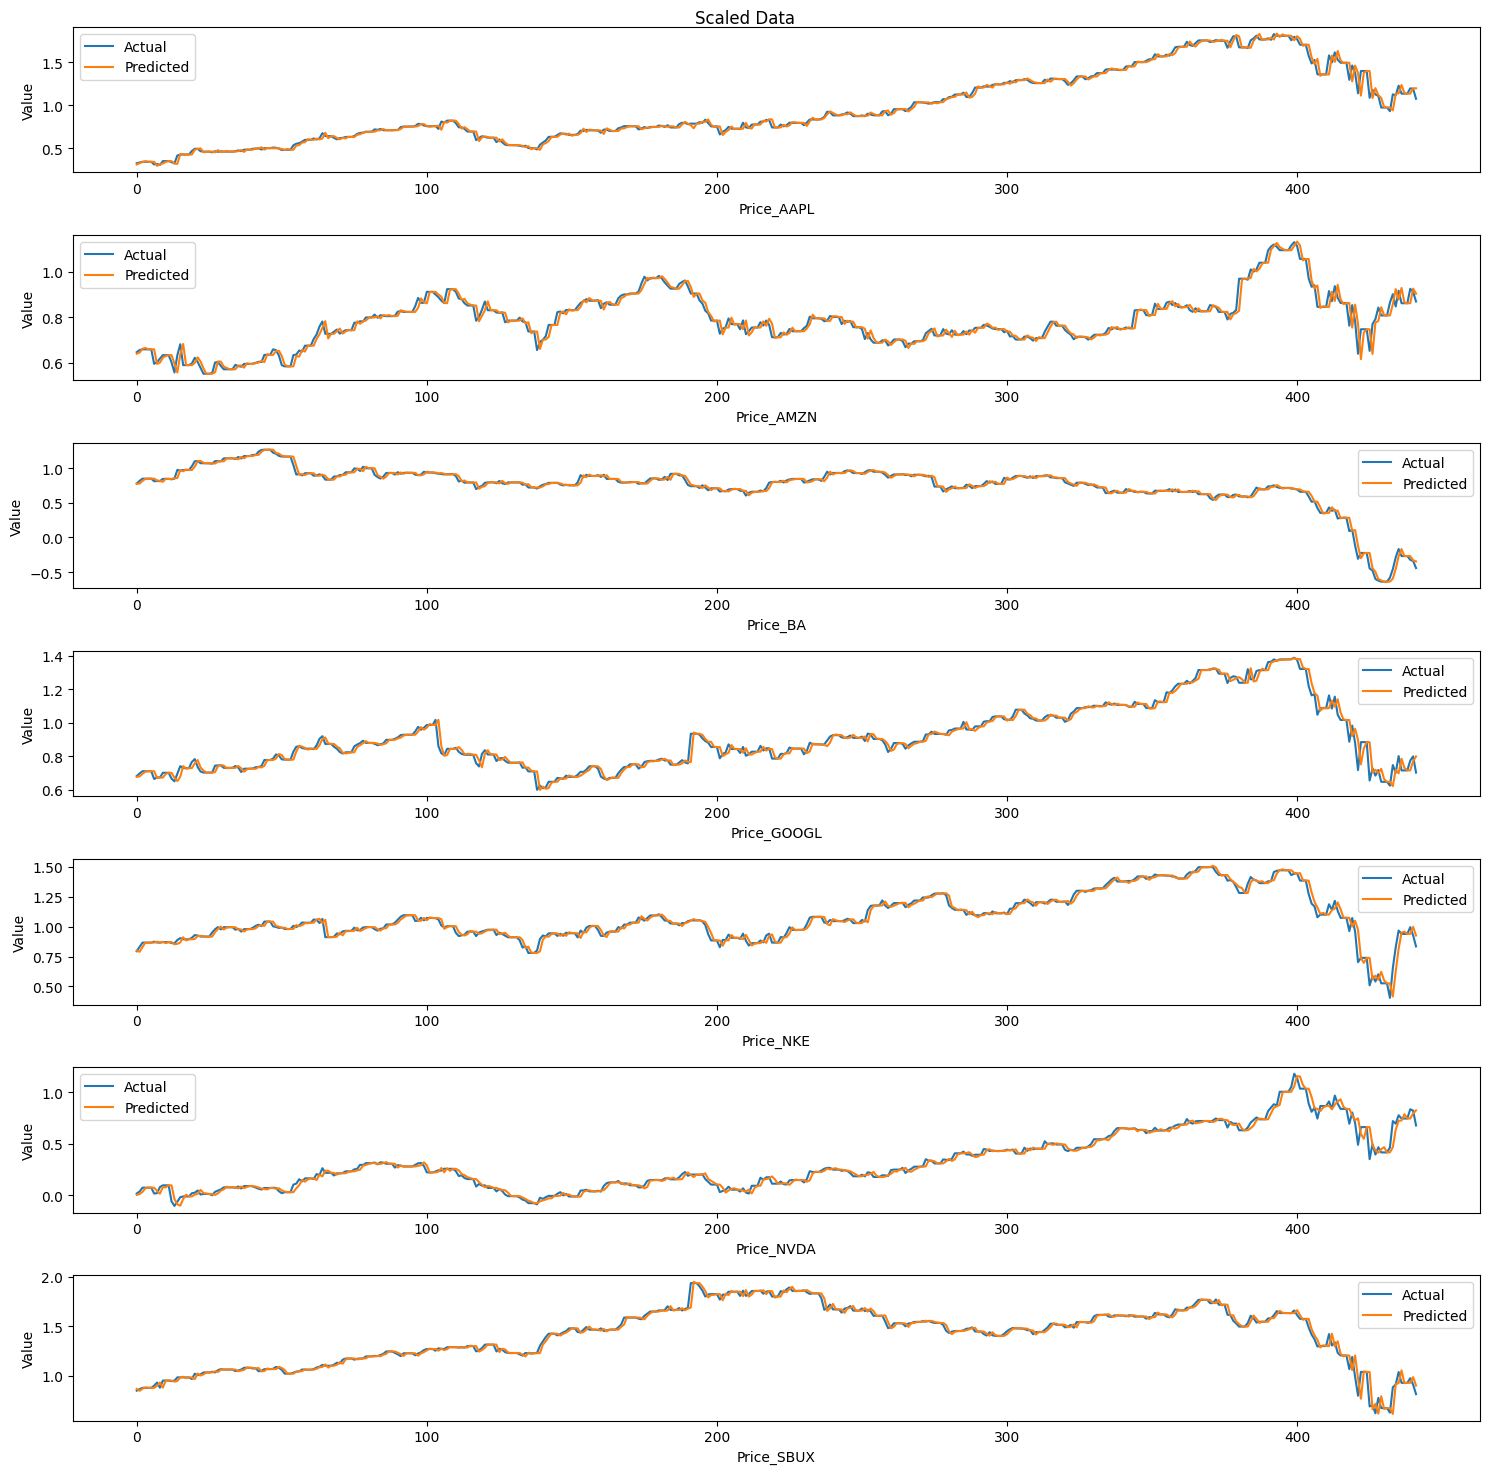

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(n_features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(testY_original[:, i], label='Actual')
    plt.plot(pred_SrVAR_original[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{VAR_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

#### Unscaled data

In [ ]:
unscaled_SrVAR = unscale(pred_SrVAR_original)
originY = unscale(testY_original)

In [ ]:
for i in range(n_features):
    print(f'MSE for {VAR_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_SrVAR[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_SrVAR)}')

MSE for Price_AAPL: 24.454380194172494
MSE for Price_AMZN: 756.2727355925949
MSE for Price_BA: 49.924317209312036
MSE for Price_GOOGL: 399.5821796566546
MSE for Price_NKE: 2.039358865047095
MSE for Price_NVDA: 33.23501100712389
MSE for Price_SBUX: 1.979895122412338
MSE total: 181.06969680675957


In [ ]:
for i in range(n_features):
    print(f'RMSE for {VAR_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_SrVAR[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(originY, unscaled_SrVAR, squared=False)}')

RMSE for Price_AAPL: 4.945137024812608
RMSE for Price_AMZN: 27.500413371303985
RMSE for Price_BA: 7.0657142037668095
RMSE for Price_GOOGL: 19.989551762274576
RMSE for Price_NKE: 1.4280612259448455
RMSE for Price_NVDA: 5.764981440310445
RMSE for Price_SBUX: 1.4070874608254946
RMSE total: 9.728706641319823


In [ ]:
for i in range(n_features):
    print(f'MAE for {VAR_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_SrVAR[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_SrVAR)}')

MAE for Price_AAPL: 2.5995032236157893
MAE for Price_AMZN: 16.365706439734353
MAE for Price_BA: 4.089813619703549
MAE for Price_GOOGL: 10.953248045085706
MAE for Price_NKE: 0.7854573588427821
MAE for Price_NVDA: 3.2830999787609305
MAE for Price_SBUX: 0.7174196103553883
MAE total: 5.5420354680140695


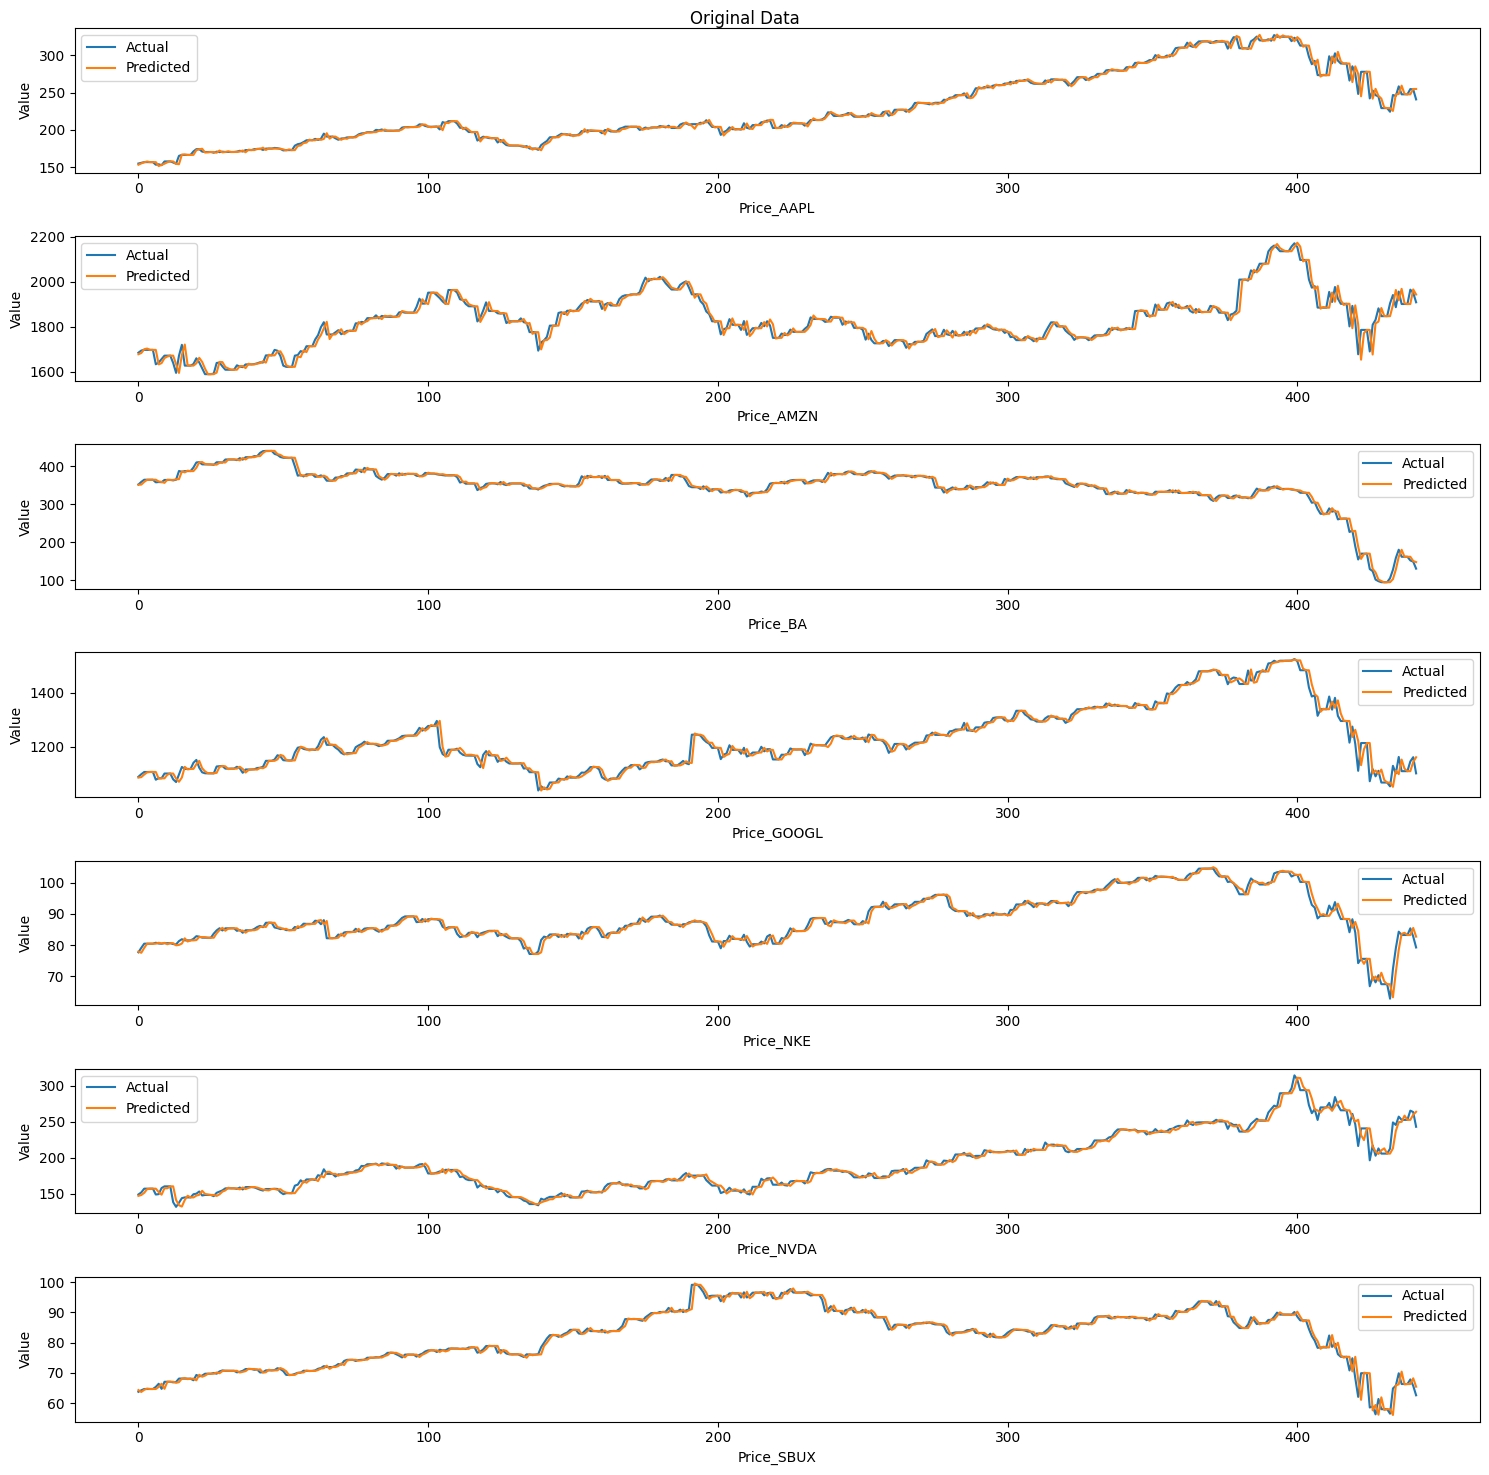

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(n_features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_SrVAR[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{VAR_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Original Data')
plt.tight_layout()
plt.show()

In [ ]:
torch.save(trained_model_SrVAR.state_dict(), "srvar_model_newstock.pth")